In [78]:
import csv
import pickle

import numpy
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
from ripser import Rips, ripser
from persim import plot_diagrams
import math
from sklearn import preprocessing
from tadasets import torus, sphere
import persim
import gudhi

# Import Scikit-Learn tools
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


def sliced_wasserstein(PD1, PD2, M=50):
    """ 
    Translated method from scikit-tda persim to pytorch. Does not work well and takes ages to train.
    """

    diag_theta = torch.tensor([np.cos(0.25 * np.pi), np.sin(0.25 * np.pi)], dtype=torch.float32, device=device)

    l_theta1 = [torch.dot(diag_theta, torch.tensor(x, dtype=torch.float32, device=device)) for x in PD1]
    l_theta2 = [torch.dot(diag_theta, torch.tensor(x, dtype=torch.float32, device=device)) for x in PD2]

    if (len(l_theta1) != PD1.shape[0]) or (len(l_theta2) != PD2.shape[0]):
        raise ValueError("The projected points and origin do not match")

    PD_delta1 = [torch.tensor([torch.sqrt(x ** 2 / 2.0)] * 2, dtype=torch.float32, device=device) for x in l_theta1]
    PD_delta2 = [torch.tensor([torch.sqrt(x ** 2 / 2.0)] * 2, dtype=torch.float32, device=device) for x in l_theta2]

    # i have the input now to compute the sw
    sw = torch.tensor(0, dtype=torch.float32, device=device, requires_grad=True)
    theta = 0.5
    step = 1.0 / M
    for i in range(M):
        l_theta = torch.tensor(
            [np.cos(theta * np.pi), np.sin(theta * np.pi)], dtype=torch.float32, device=device)

        V1 = torch.tensor([torch.dot(l_theta, torch.tensor(x, dtype=torch.float32, device=device)) for x in PD1],
                          dtype=torch.float32) + torch.tensor([torch.dot(l_theta, x) for x in
                                                               PD_delta2], dtype=torch.float32)
        V2 = torch.tensor([torch.dot(l_theta, torch.tensor(x, dtype=torch.float32, device=device)) for x in PD2],
                          dtype=torch.float32) + torch.tensor([torch.dot(l_theta, x) for x in
                                                               PD_delta1], dtype=torch.float32)
        V1.sort()
        V2.sort()
        sw = torch.add(sw, step * torch.sum(torch.abs(V1 - V2)))
        theta += step

    return sw

def plot_data_ae(data, anormal):
    """
    Plots data of the autoencoder 
    :param data: Original input of autoencoder
    :param anormal: Output of the autoencoder
    :return: 
    """
    x = []
    y = []
    x_ae = []
    y_ae = []
    fig, axis = plt.subplots(1)
    for input, target in zip(data, anormal):
        i = input.detach().cpu().numpy()
        t = target.detach().cpu().numpy()
        for j in range(0, len(i), 2):
            x.append(i[j])
            y.append(i[j + 1])
            x_ae.append(t[j])
            y_ae.append(t[j + 1])
    plt.scatter(x, y, color='green', s=2, label='Training Data')
    plt.scatter(x_ae, y_ae, color='blue', s=3, label='Output Autoencoder')
    axis.legend()
    axis.set_xlabel("Birth")
    axis.set_ylabel("Death")
    plt.show()


# Take the points from the highest dimension downward. Ignore ifinity
def transform_data(data_array):
    vec = []
    data_array = data_array['dgms']
    for i in range(len(data_array) - 1, -1, -1):
        array = data_array[i]
        for j in range(len(array) - 1, -1, -2):
            if array[j][1] == float('inf'):
                continue
            vec.append(array[j][0])
            vec.append(array[j][1])
            # If vector has desired input size return vector
            if len(vec) == 10:
                return vec

def my_plot(epochs, loss):
    plt.plot(epochs, loss)

def plot(trainer, dataset):
    """
    Plot Deep SVDD states
    :param trainer: Trainer containing model and c, as well as R for the Deep SVDD hypersphere
    :param dataset: The data set that should be plotted
    :return: 
    """
    figure, axes = plt.subplots()
    uc_3 = plt.Circle(trainer.c, trainer.R, fill=False)

    new_x = []
    new_y = []

    for data in dataset:
        map = dsvdd.forward(data).cpu().detach().numpy()
        new_x.append(map[0])
        new_y.append(map[1])

    an_x = []
    an_y = []
    
    # For this example torus data is always the outlier data
    for outlier in tensors_torus:
        outlier_pos = dsvdd.forward(outlier).cpu().detach().numpy()
        an_x.append(outlier_pos[0])
        an_y.append(outlier_pos[1])

    center = dsvdd_trainer.c.cpu().detach().numpy()
    plt.scatter(new_x, new_y,
                color="green", s=5, label="Normal Class")
    plt.scatter(an_x, an_y,
                color="red", s=5, label="Anomalous Class")
    plt.scatter(center[0], center[1],
                color="blue", s=5, label = "Center")
    axes.add_artist(uc_3)
    plt.gca().add_patch(uc_3)
    plt.axis('equal')
    axes.set_xlabel("x")
    axes.set_ylabel("y")
    axes.legend()
    plt.show()


samples = torus(200, c=2, a=1)

cuda


In [79]:
samples_circle = sphere(n=200, r=2)

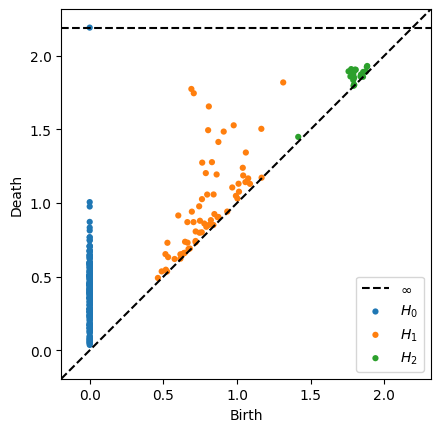

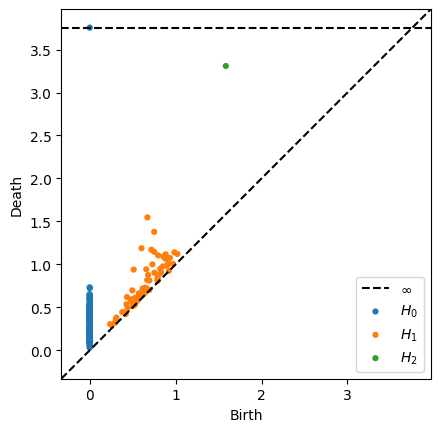

In [80]:
data_torus = ripser(samples, maxdim=2)
data_circle = ripser(samples_circle, maxdim=2)
plot_diagrams(data_torus['dgms'], show=True)
plot_diagrams(data_circle['dgms'], show=True)

In [81]:
trainings_data_circle = []
validation_data_circle = []
validation_data_torus = []
data_torus = []

processed_data_torus = []
processed_data_circle = []
processed_validation_data_circle = []

# Sample points form sphere and torus, then calculate persistence diagrams on them
for i in range(250):
    trainings_data_circle.append(ripser(sphere(n=200, r=2), maxdim=2))
    validation_data_circle.append(ripser(sphere(n=200, r=2), maxdim=2))

for i in range(250):
    data_torus.append(ripser(torus(n=200, a=1, c=2), maxdim=2))

scaled_data_circle = []
scaled_data_torus = []

# Transform data into training vectors.
for d in trainings_data_circle:
    if (t_d := transform_data(d)) is not None:
        processed_data_circle.append(t_d)

for d in validation_data_circle:
    if (t_d := transform_data(d)) is not None:
        processed_validation_data_circle.append(t_d)        

for d in data_torus:
    if (t_d := transform_data(d)) is not None:
        processed_data_torus.append(t_d)


tensors_circle = []
tensors_torus = []
tensor_validation_circle = []

# Convert pre processed data into tensors
for d in processed_data_circle:
    tensors_circle.append(torch.tensor(d, dtype=torch.float32, device=device))

for d in processed_validation_data_circle:
    tensor_validation_circle.append(torch.tensor(d, dtype=torch.float32, device=device))

for d in processed_data_torus:
    tensors_torus.append(torch.tensor(d, dtype=torch.float32, device=device))


In [83]:
from gudhi.wasserstein import wasserstein_distance
from torch.optim import lr_scheduler

class AutoEncoder(nn.Module):
    """
    Autoencoder model for TDA data
    """
    def __init__(self, bias=False):
        """
        :param bias: Controls biases for the network, should be False per default
        """
        super().__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(10, 10, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(10, 5, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(5, 5, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(5, 2, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(2, 5, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(5, 5, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(5, 10, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(10, 10, bias=bias),
        ).to(device)

    def forward(self, x):
        return self.layers(x)


def wasserstein_loss(input, target):
    """
    Helper for wasserstein loss. Data must be reshaped before it can be passed to the wasserstein_distance function from gudhi
    :param input: Actual input into the network
    :param target: Output of the network
    :return: Loss between input to the network and output to the network
    """
    reshaped_input = input.reshape((input.shape[0], input.shape[1] // 2, 2))
    reshaped_target = target.reshape((target.shape[0], target.shape[1] // 2, 2))
    print(reshaped_input, reshaped_target)
    
    for x ,y in zip(reshaped_input, reshaped_target):
        return wasserstein_distance(y, x, enable_autodiff=True, keep_essential_parts=False)


class AETrainer:
    """
    Implementation of a trainer for the autoencoder pretraining stage
    """
    def __init__(self, model):
        self.model = model

    def train(self, training_data, epochs):
        train_loader = torch.utils.data.DataLoader(list(zip(training_data, training_data)), batch_size=1, shuffle=True)
        loss_function = nn.L1Loss(reduction='sum').to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3/2)
        lr_sched = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        losses = []
        for epoch in range(0, epochs):
            epoch_loss = []
            for i, data in enumerate(train_loader, 0):
                inputs, targets = data
                optimizer.zero_grad()
                outputs = self.model(inputs)
                #loss = wasserstein_loss(inputs, outputs)
                loss = loss_function(outputs, targets)  #* loss_function(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())
            lr_sched.step()
            print(f"epoch-{epoch}, done")
            print(sum(epoch_loss) / len(epoch_loss))
            losses.append(sum(epoch_loss) / len(epoch_loss))
            plot_data_ae(training_data, self.model.forward(torch.stack(training_data)))
        return losses

    def model(self):
        return self.model()

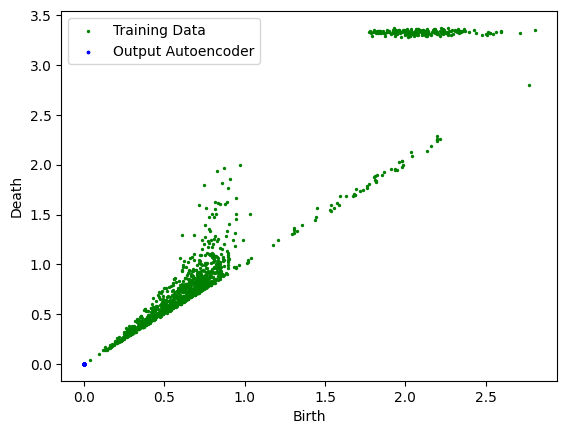

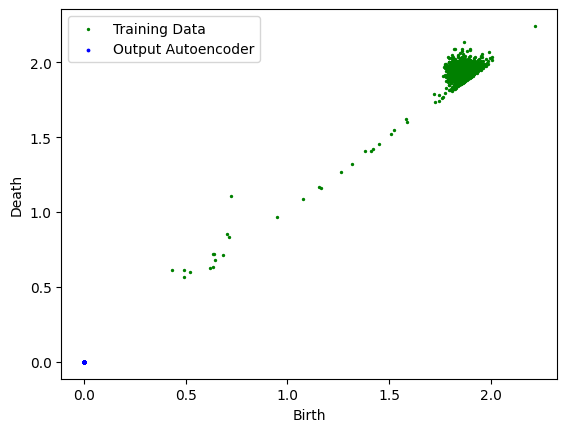

epoch-0, done
10.082823425292968


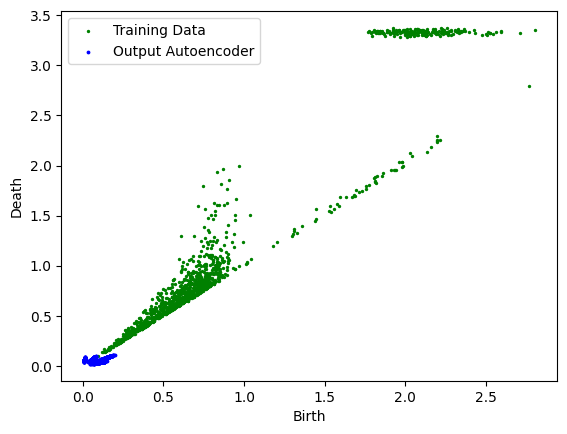

epoch-1, done
4.80723262500763


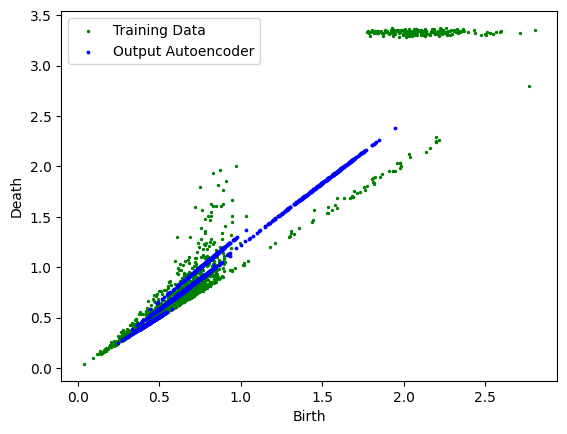

epoch-2, done
1.9744178792238236


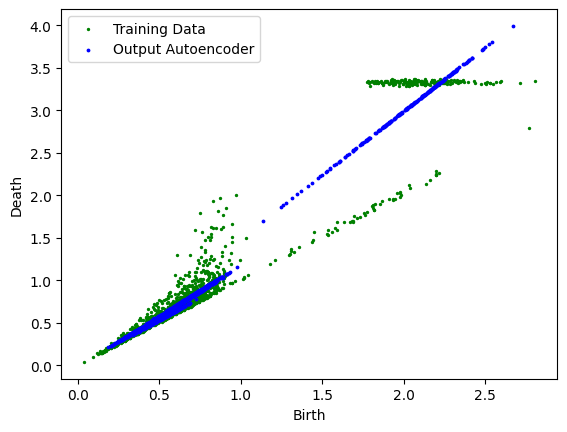

epoch-3, done
1.6288261461257934


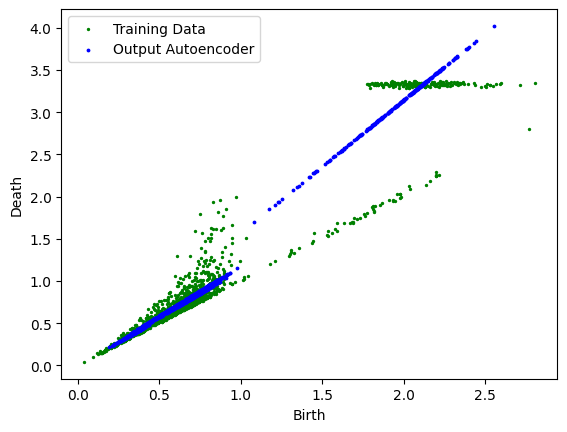

epoch-4, done
1.6277498662471772


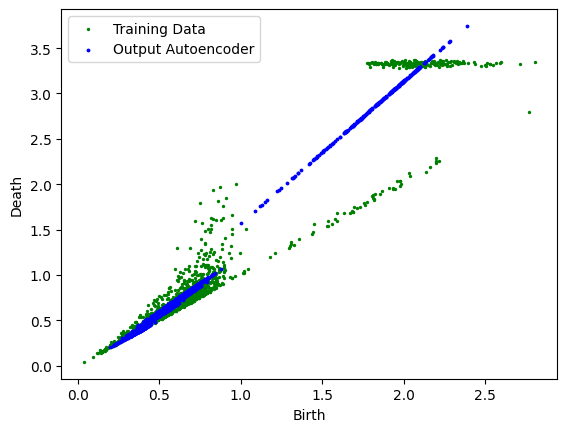

epoch-5, done
1.6243024311065675


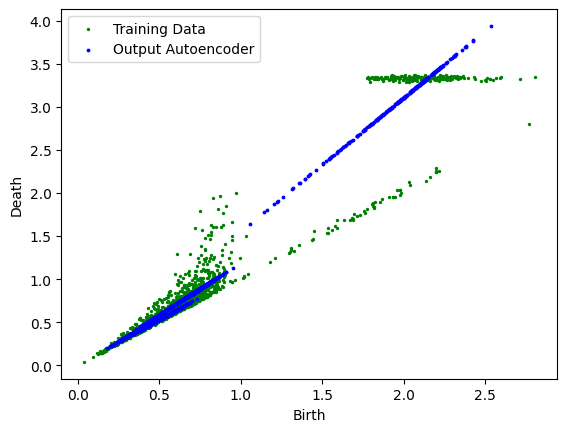

epoch-6, done
1.6148668262958528


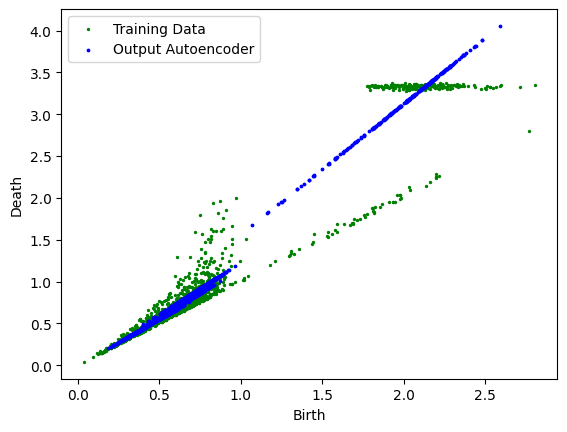

epoch-7, done
1.617075394153595


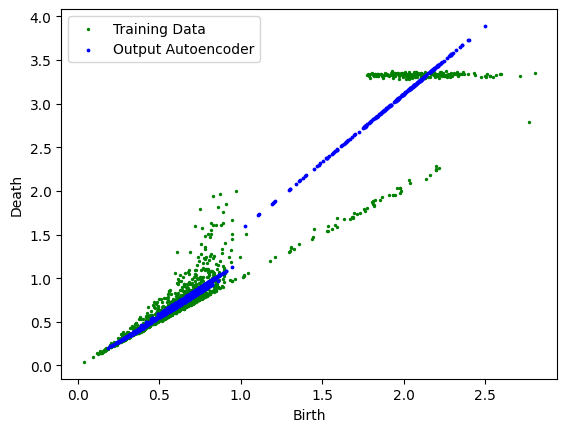

epoch-8, done
1.6072715258598327


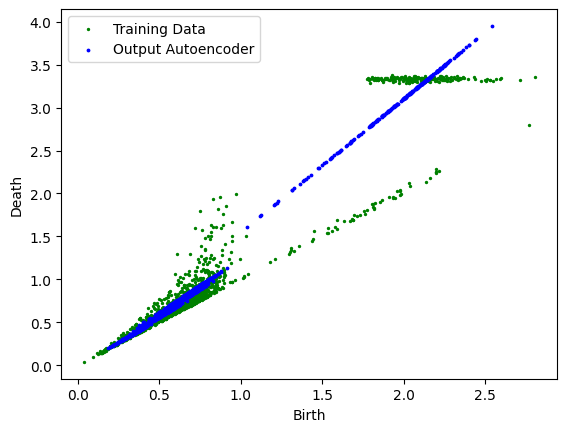

epoch-9, done
1.613950552225113


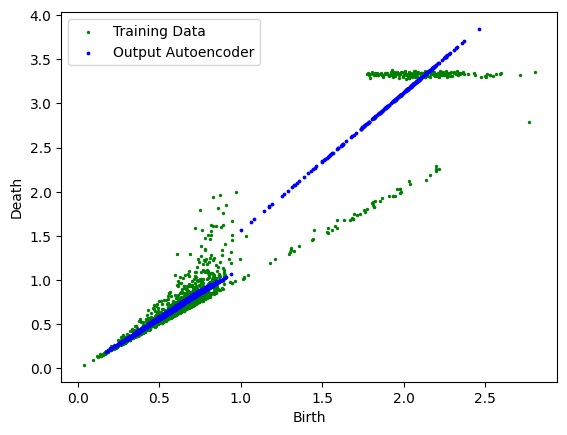

epoch-10, done
1.5959621027708053


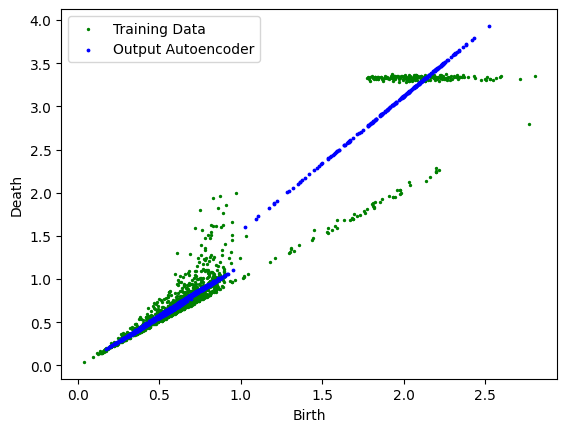

epoch-11, done
1.5920126339197158


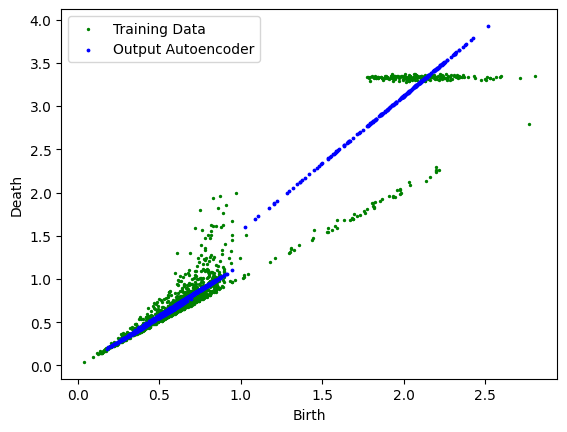

epoch-12, done
1.5916722340583802


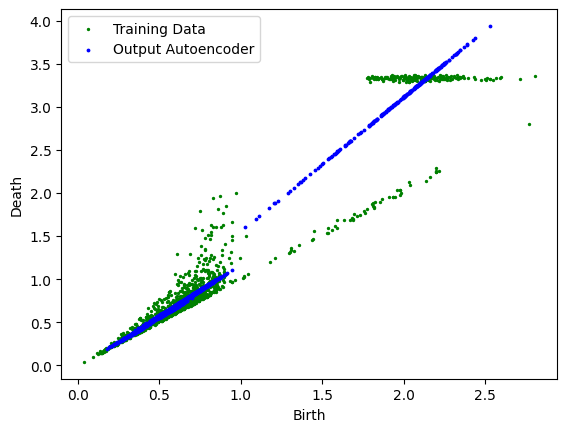

epoch-13, done
1.5913691102266312


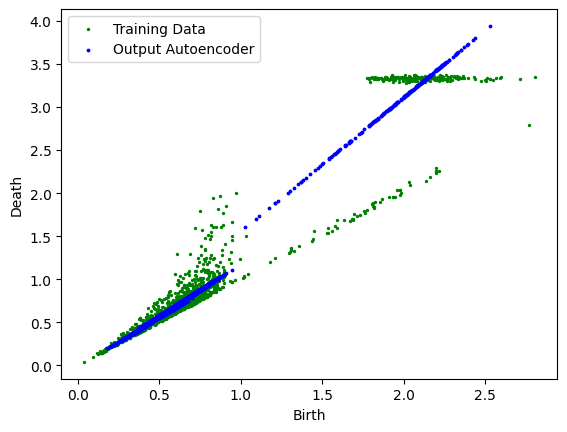

epoch-14, done
1.5917031452655792


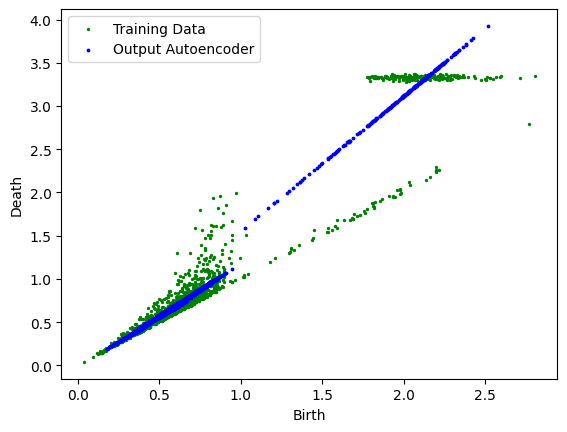

epoch-15, done
1.5913901454210282


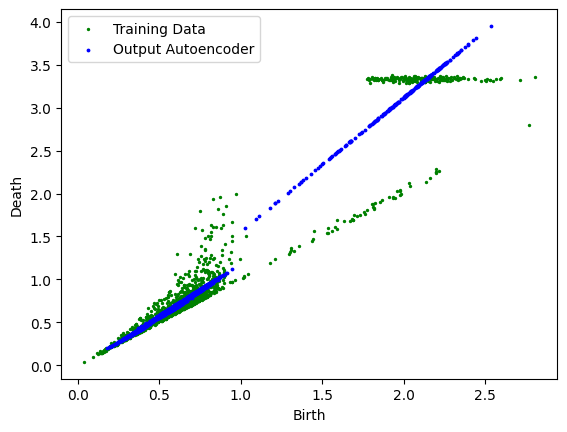

epoch-16, done
1.5914885613918304


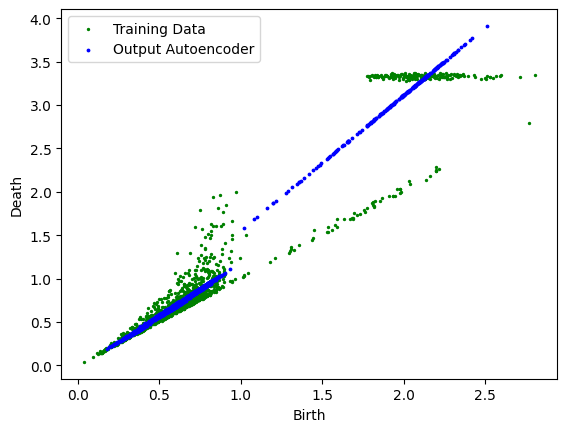

epoch-17, done
1.59045312833786


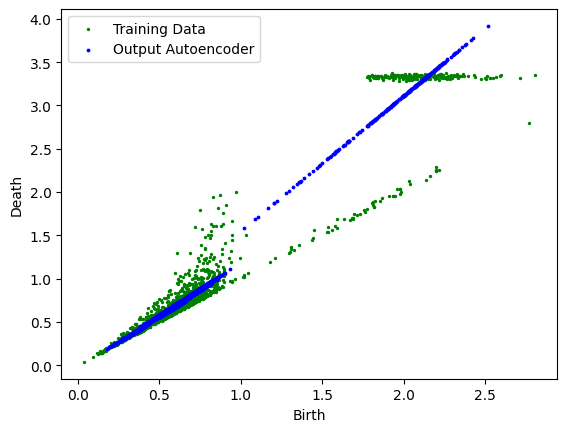

epoch-18, done
1.5907279564142227


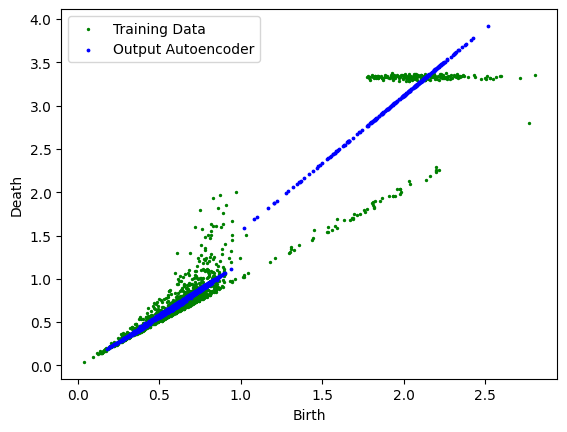

epoch-19, done
1.5902661039829253


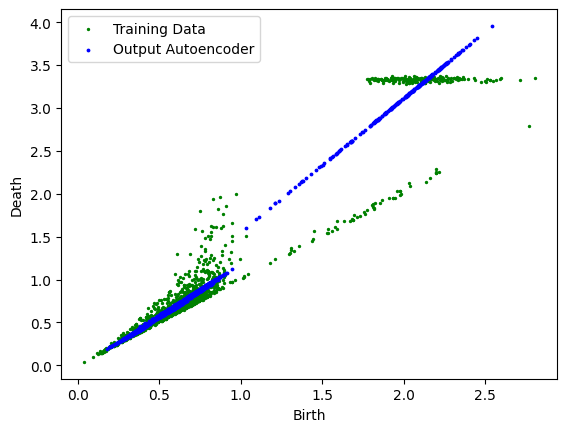

epoch-20, done
1.5894541258811952


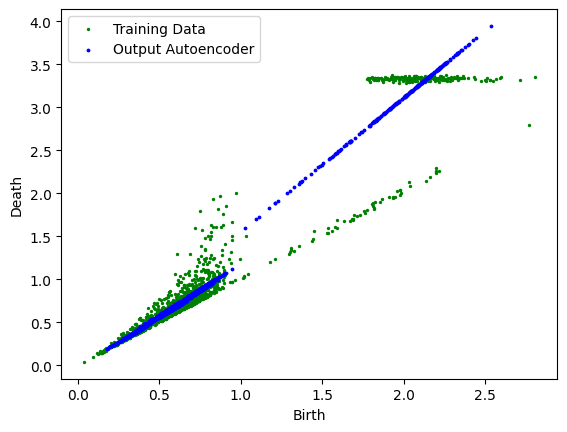

epoch-21, done
1.5889858688116074


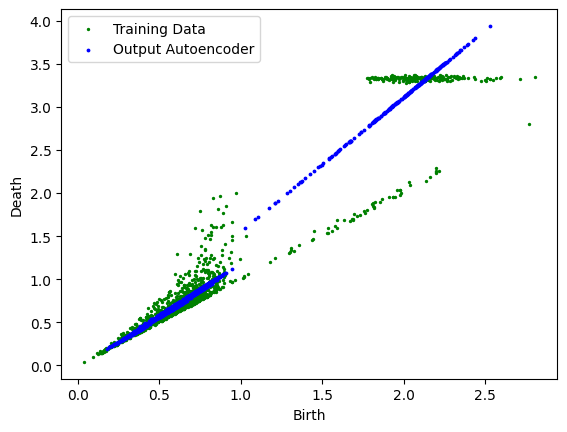

epoch-22, done
1.5888318647146225


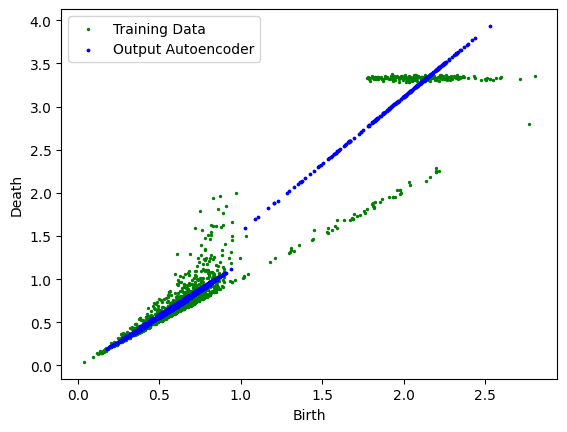

epoch-23, done
1.588647154569626


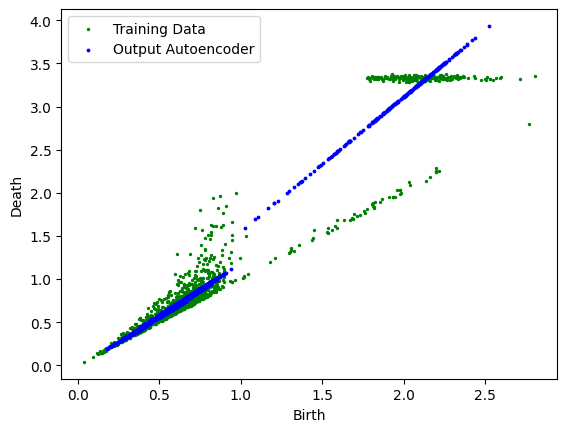

epoch-24, done
1.5886138271093369


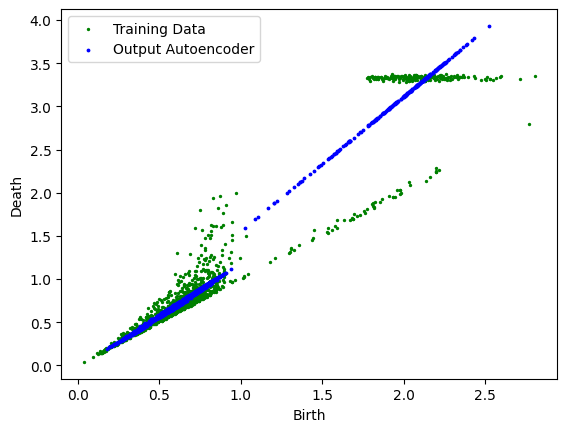

epoch-25, done
1.588558422446251


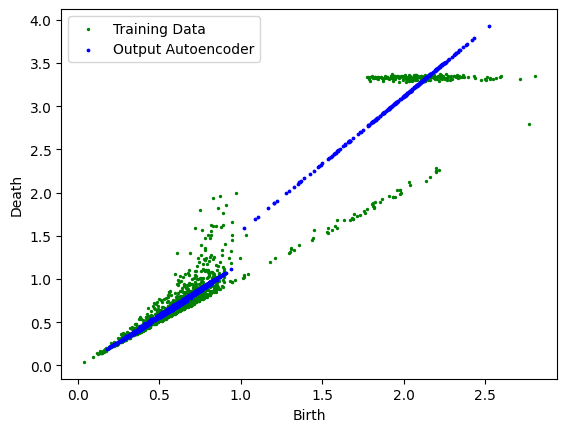

epoch-26, done
1.588600432753563


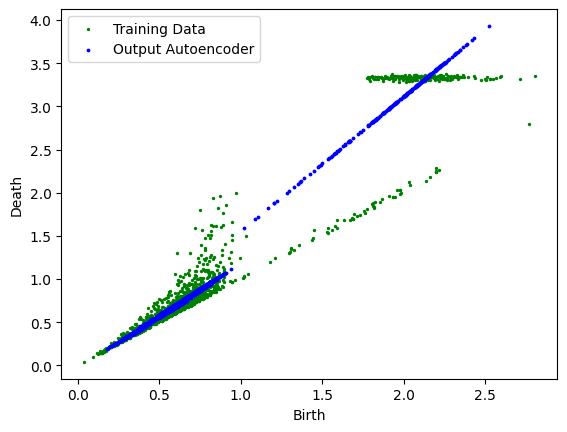

epoch-27, done
1.5885516755580902


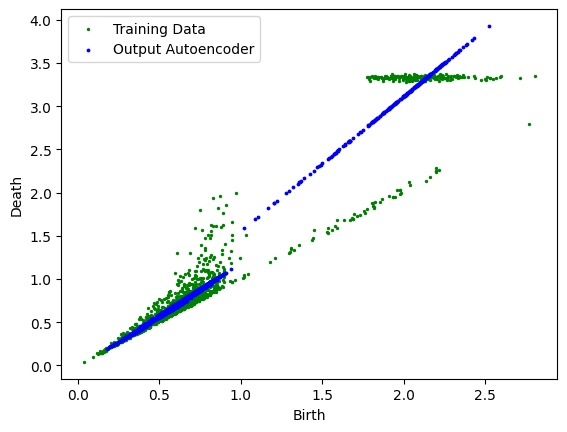

epoch-28, done
1.588553902387619


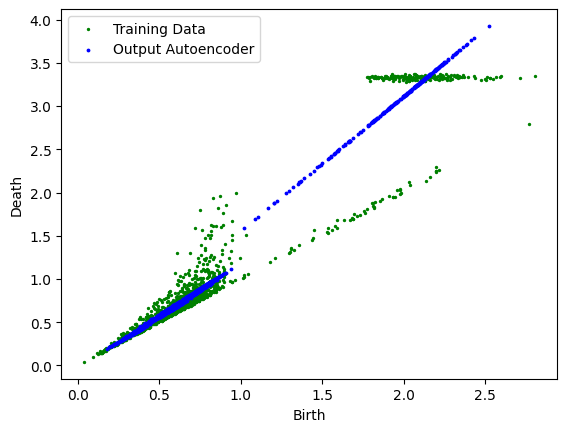

epoch-29, done
1.5884539662599564


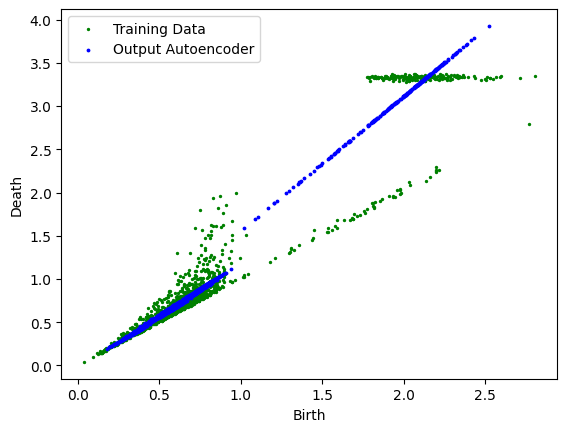

epoch-30, done
1.5882285884618759


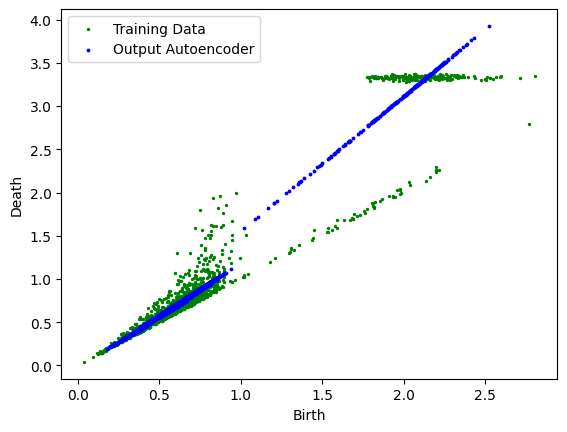

epoch-31, done
1.5882319210767746


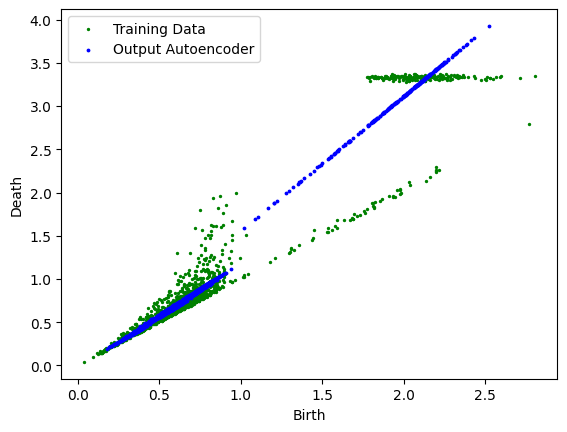

epoch-32, done
1.588236363530159


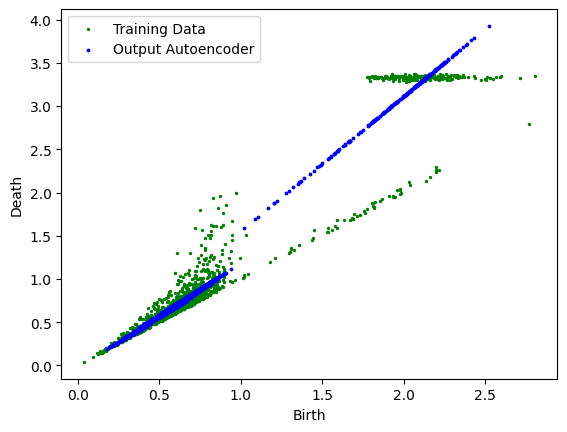

epoch-33, done
1.5882263057231902


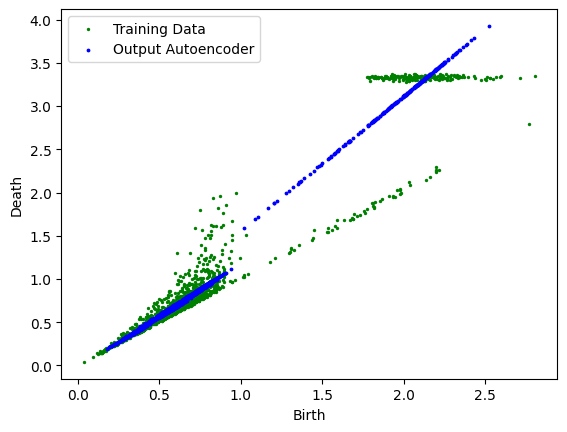

epoch-34, done
1.5882264270782471


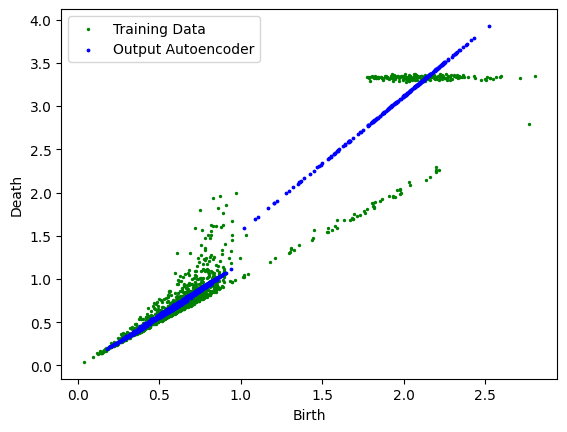

epoch-35, done
1.588222655773163


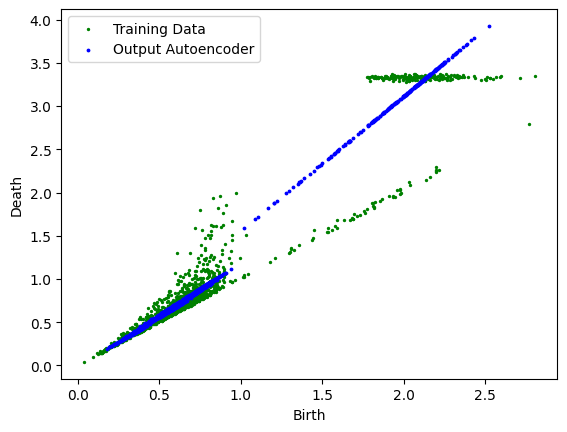

epoch-36, done
1.5882244509458543


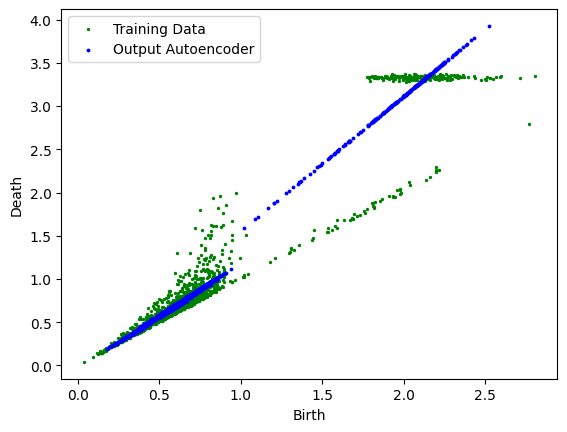

epoch-37, done
1.5882170163393021


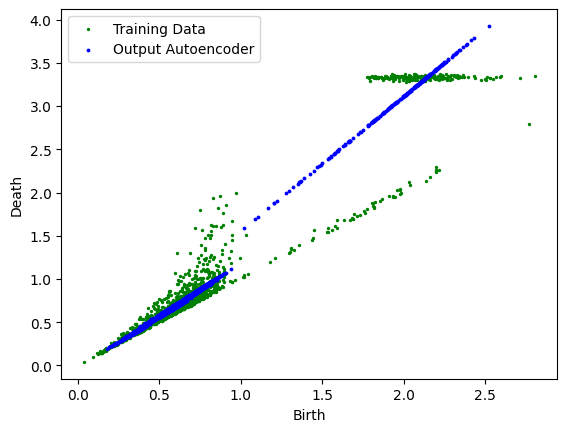

epoch-38, done
1.5882206305265427


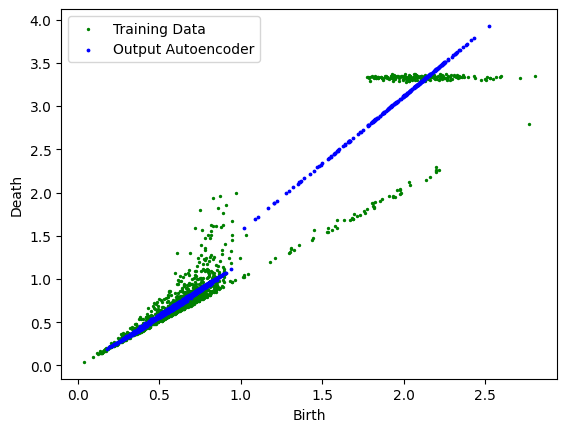

epoch-39, done
1.5882139236927033


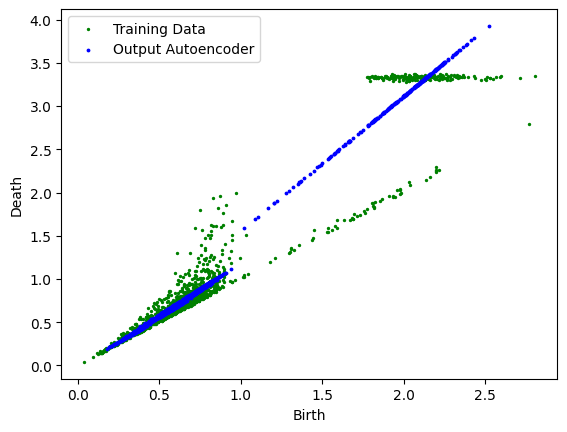

epoch-40, done
1.5881859675645829


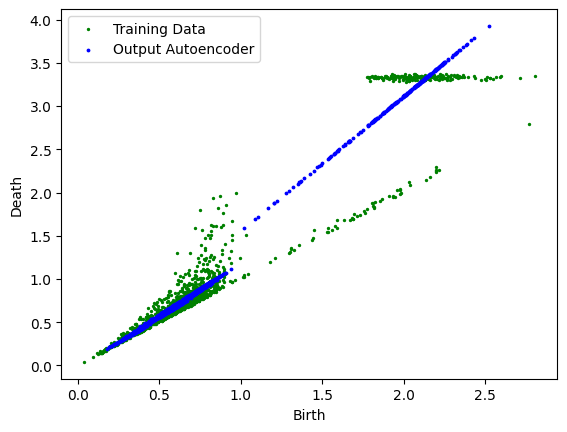

epoch-41, done
1.5881863273382186


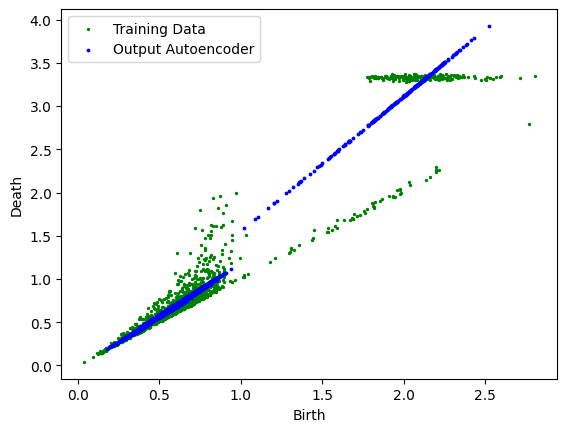

epoch-42, done
1.5881865442991256


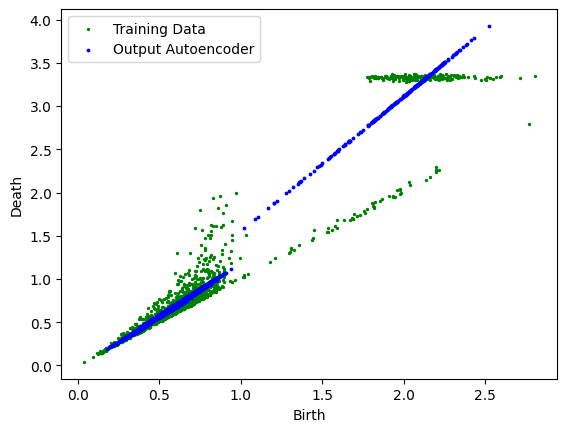

epoch-43, done
1.5881861917972564


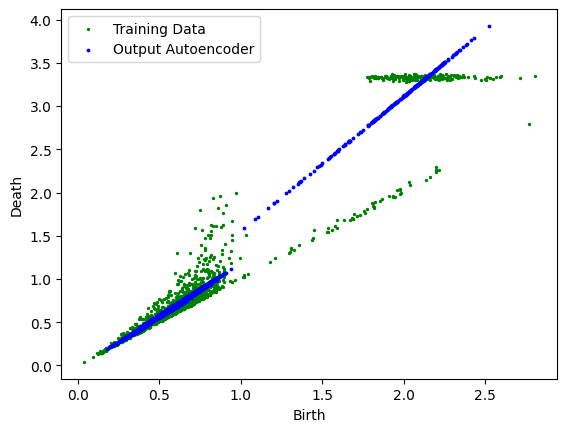

epoch-44, done
1.588186228275299


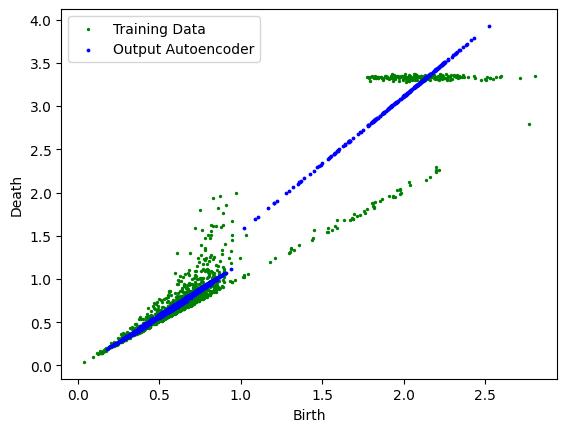

epoch-45, done
1.588185197353363


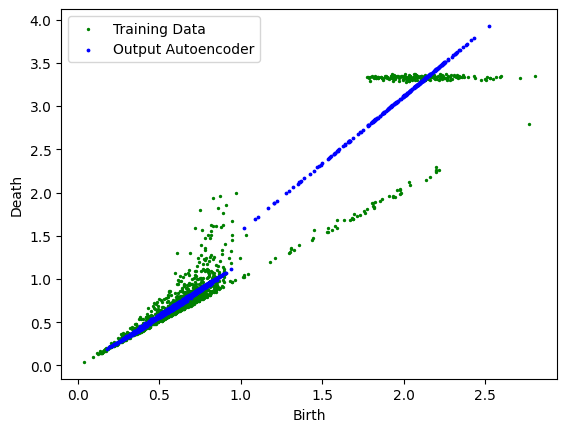

epoch-46, done
1.5881858533620834


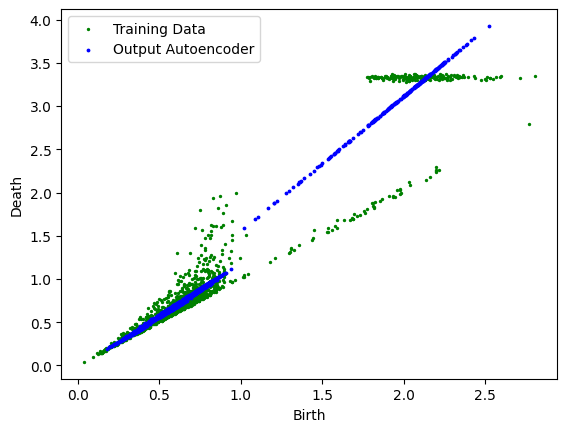

epoch-47, done
1.5881854246854783


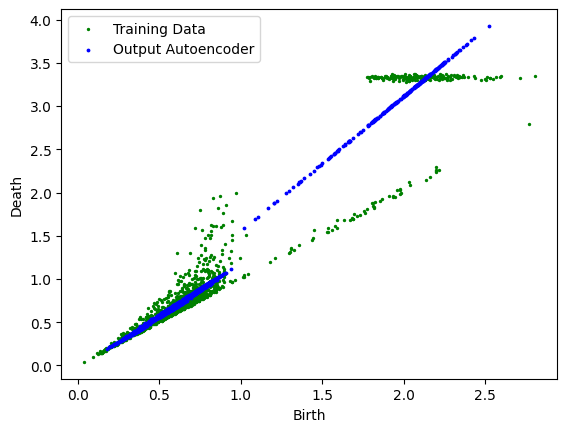

epoch-48, done
1.588184586286545


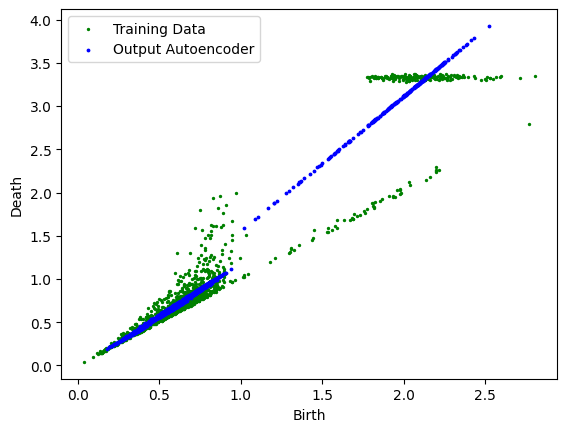

epoch-49, done
1.5881850064992904


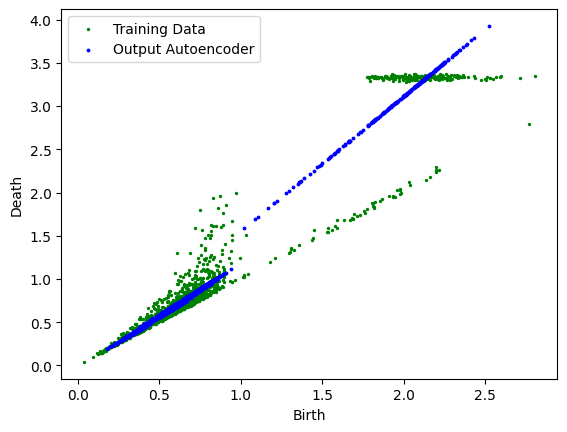

epoch-50, done
1.5881824581623076


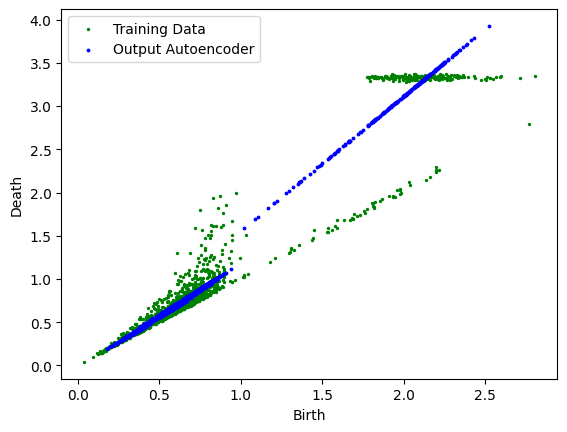

epoch-51, done
1.588182427763939


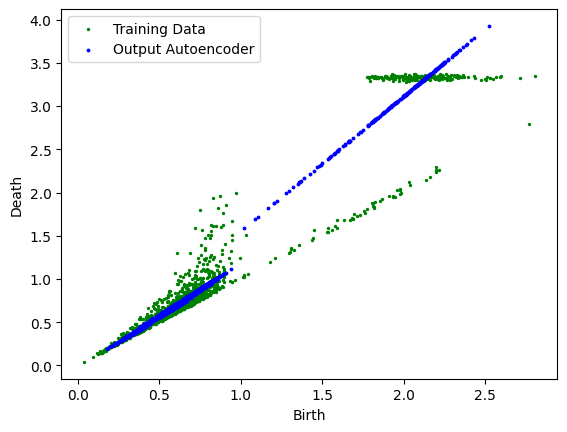

epoch-52, done
1.5881824258565902


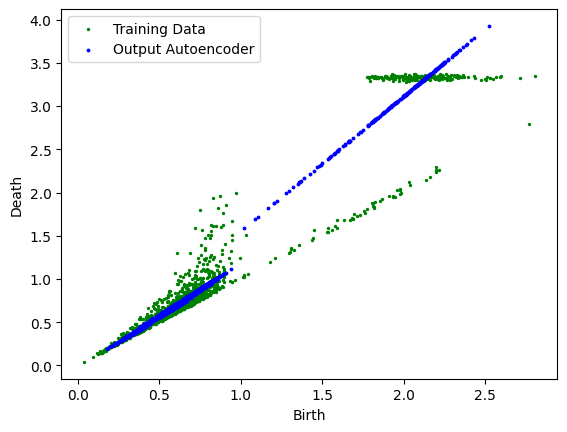

epoch-53, done
1.588182424902916


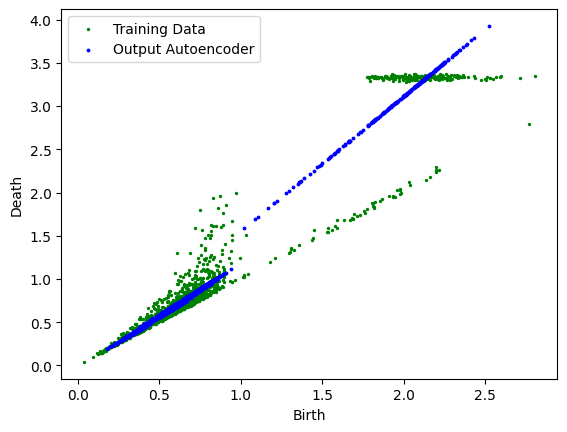

epoch-54, done
1.5881824209690094


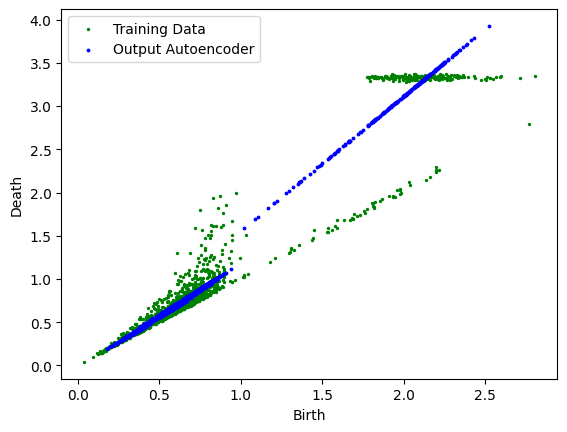

epoch-55, done
1.5881824345588684


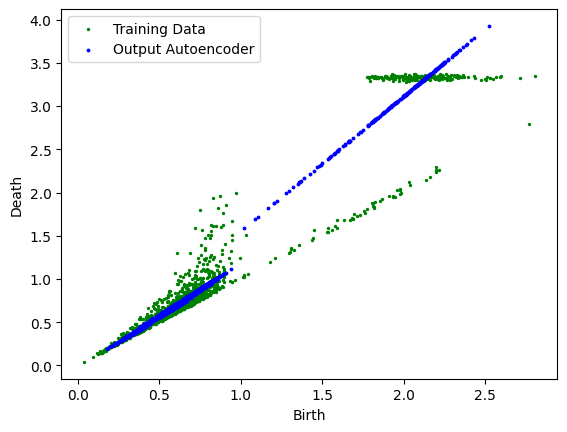

epoch-56, done
1.5881824369430542


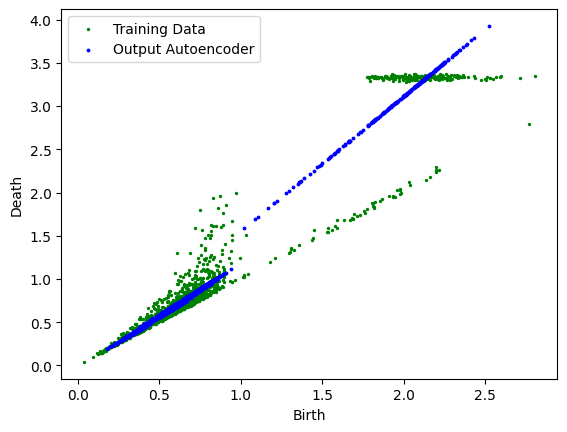

epoch-57, done
1.5881824469566346


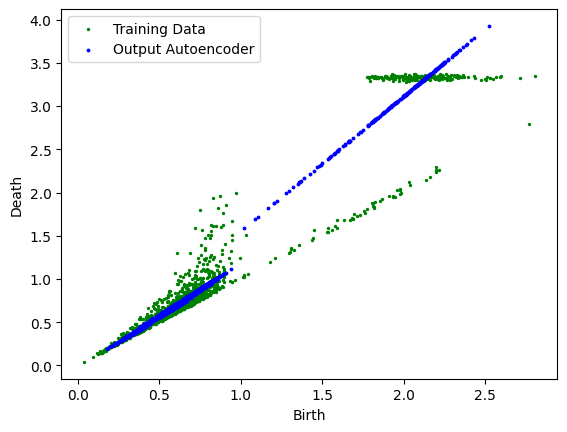

epoch-58, done
1.5881824389696122


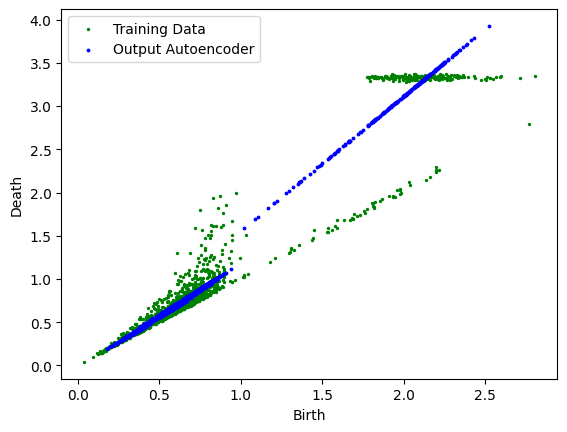

epoch-59, done
1.5881824417114259


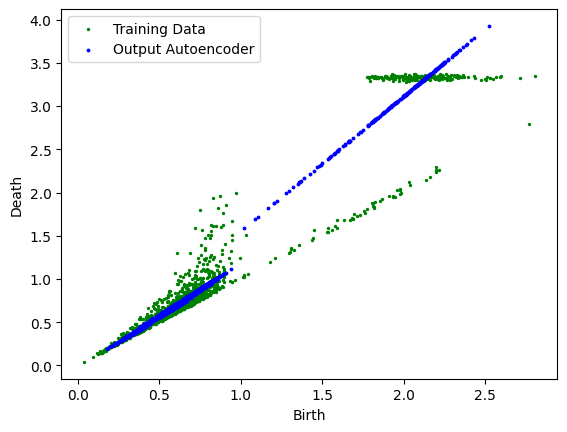

epoch-60, done
1.588182424068451


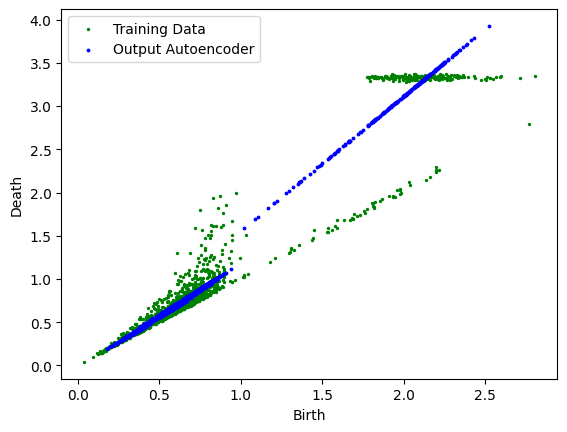

epoch-61, done
1.5881824252605439


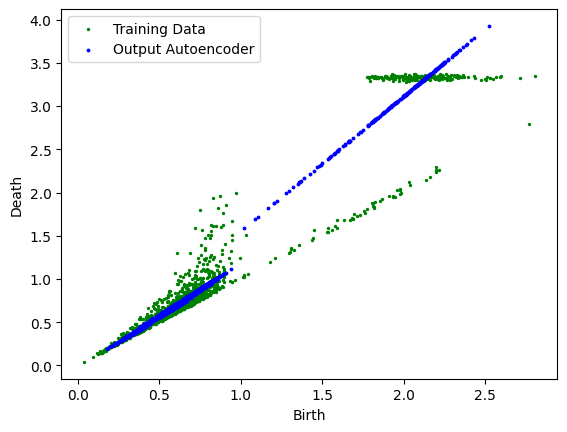

epoch-62, done
1.5881824252605439


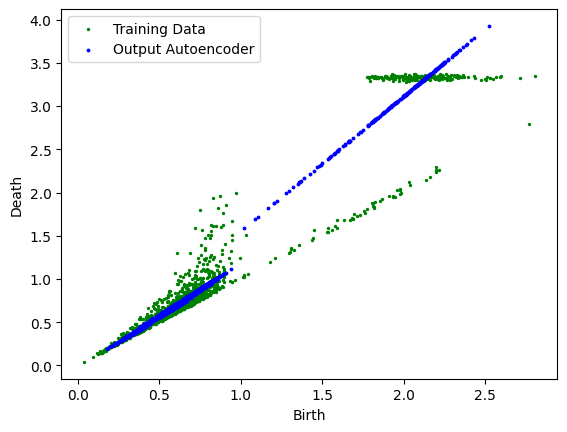

epoch-63, done
1.5881824243068694


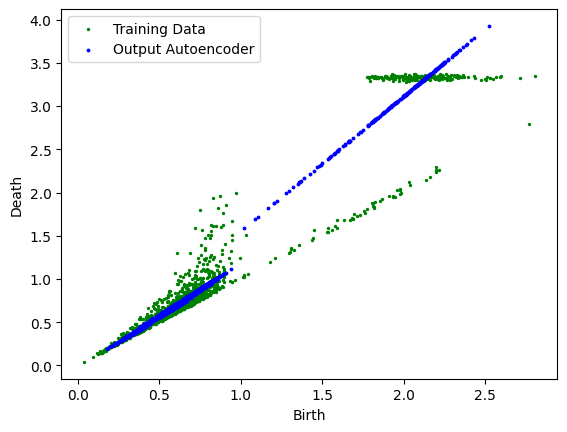

epoch-64, done
1.5881824252605439


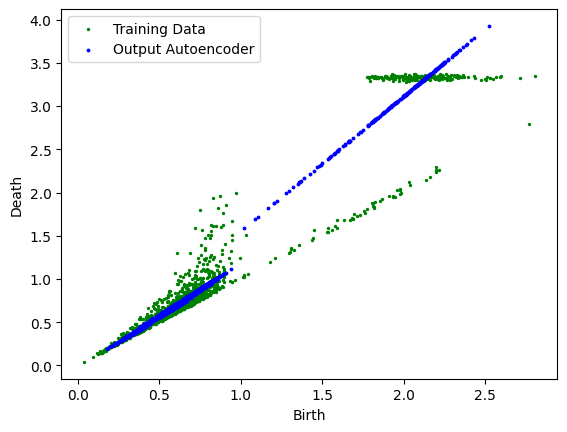

epoch-65, done
1.5881824271678924


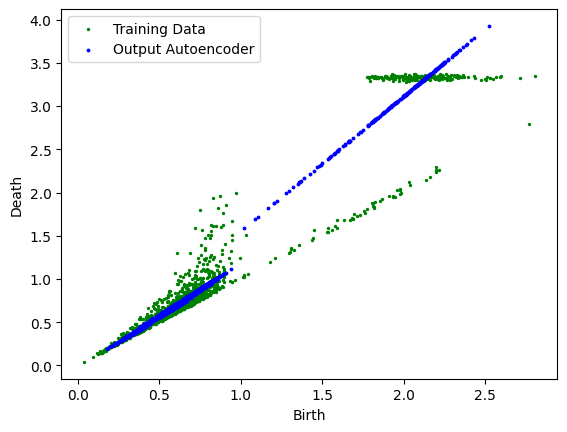

epoch-66, done
1.5881824257373809


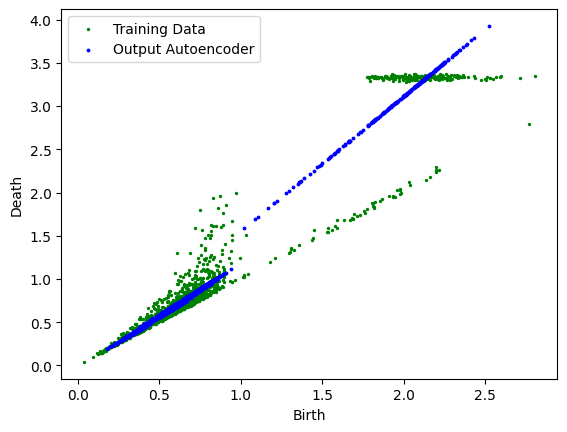

epoch-67, done
1.5881824252605439


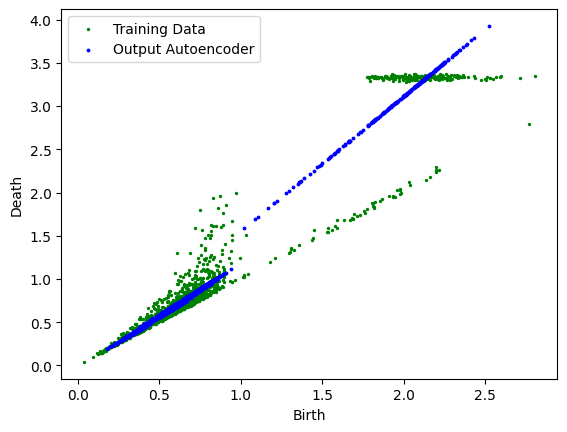

epoch-68, done
1.5881824257373809


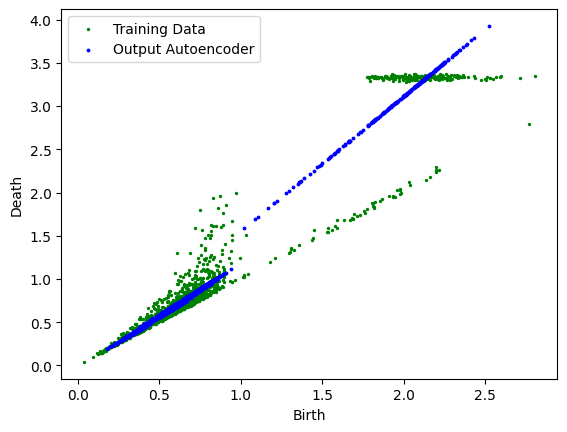

epoch-69, done
1.5881824247837066


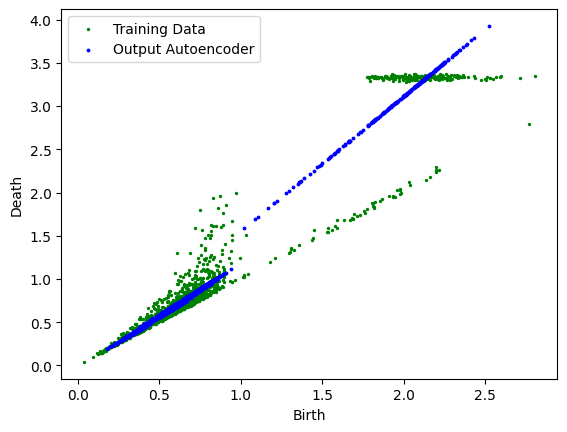

epoch-70, done
1.588182424545288


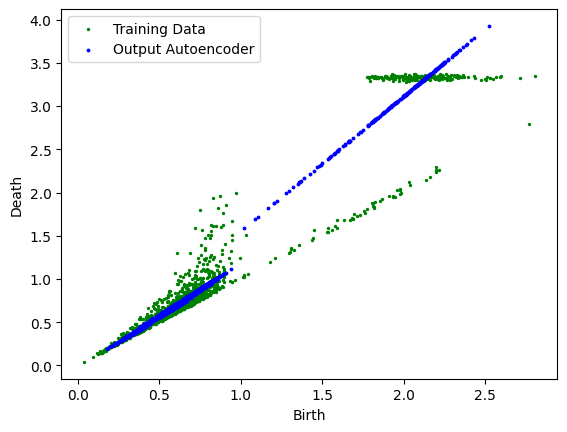

epoch-71, done
1.588182424545288


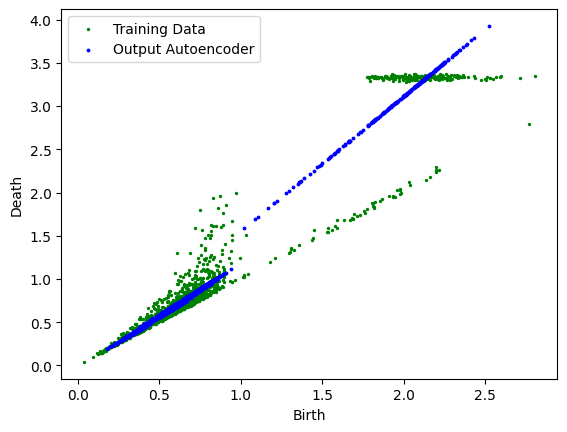

epoch-72, done
1.588182424545288


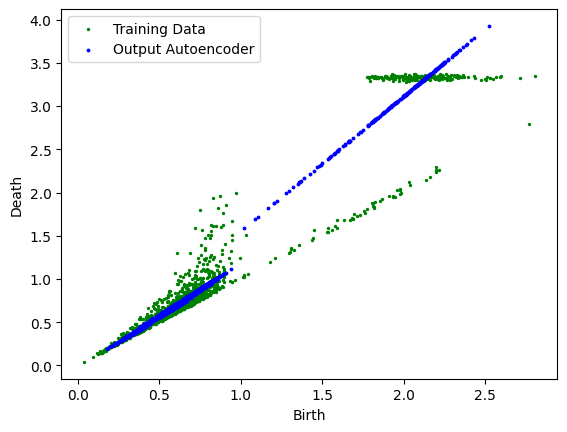

epoch-73, done
1.588182424545288


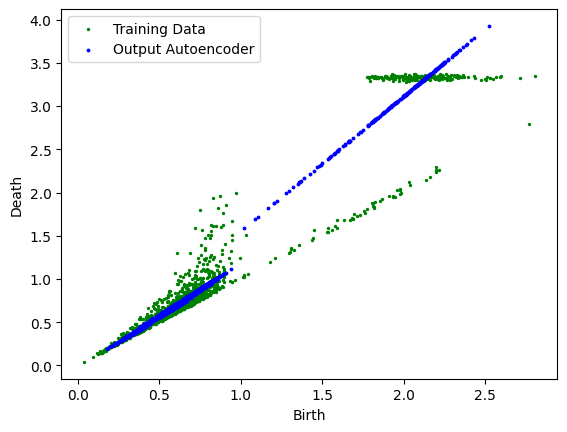

epoch-74, done
1.588182424545288


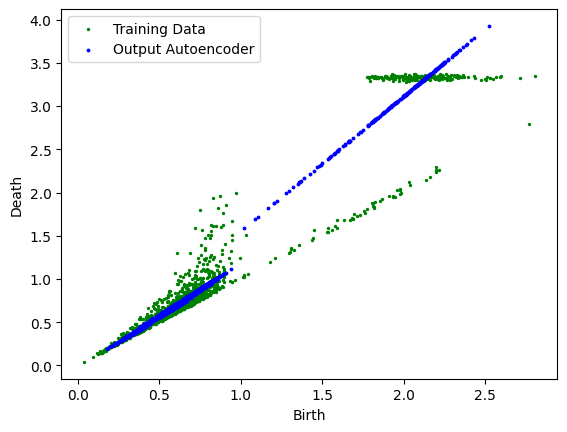

epoch-75, done
1.588182424545288


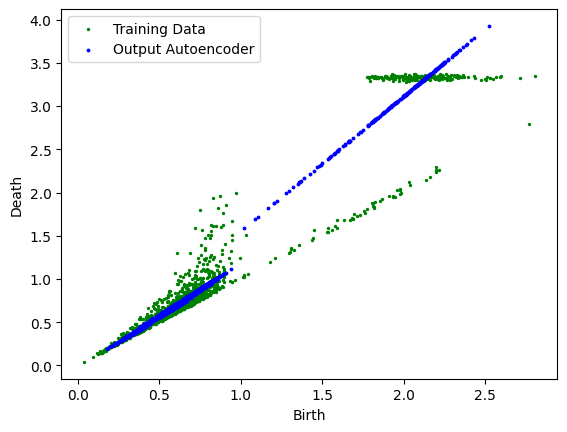

epoch-76, done
1.588182424545288


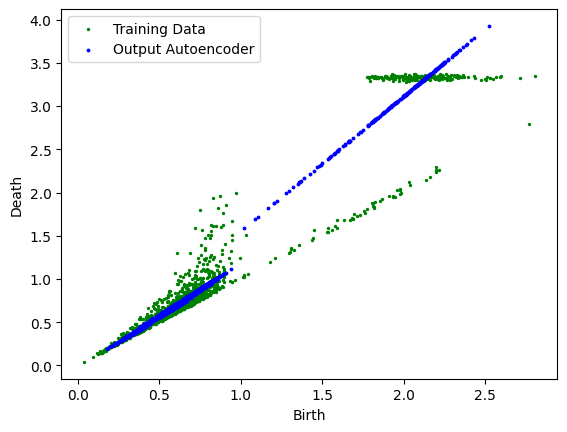

epoch-77, done
1.588182424545288


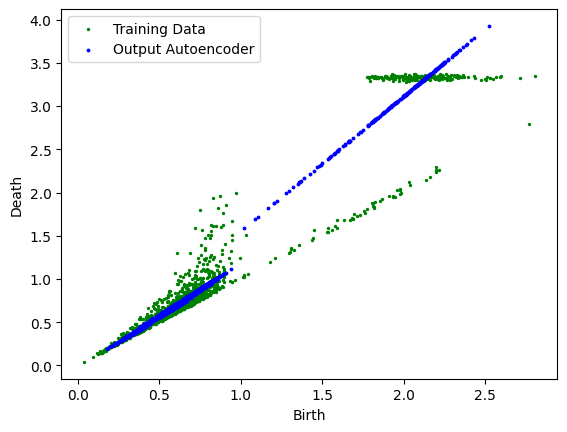

epoch-78, done
1.588182424545288


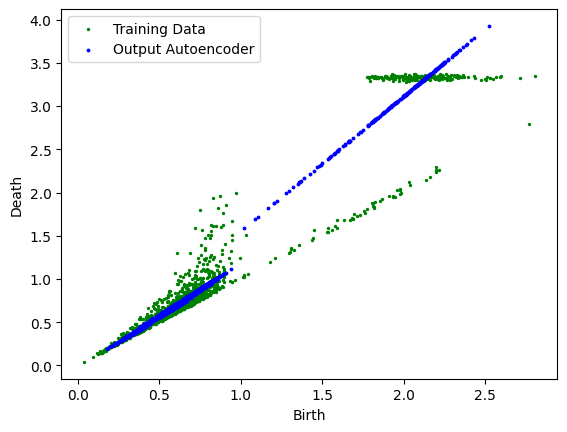

epoch-79, done
1.588182424545288


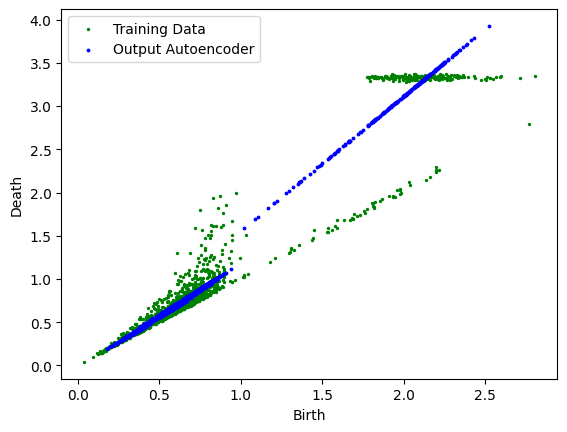

epoch-80, done
1.588182424545288


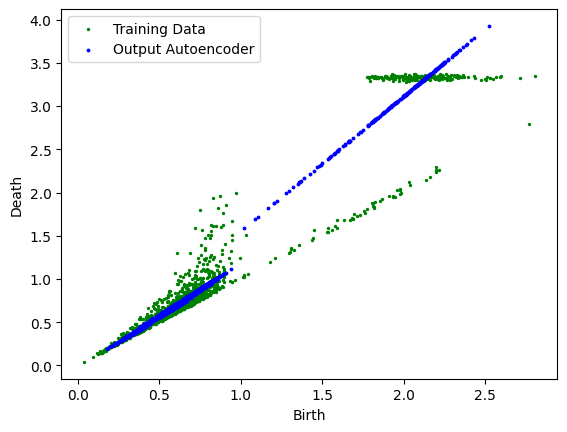

epoch-81, done
1.588182424545288


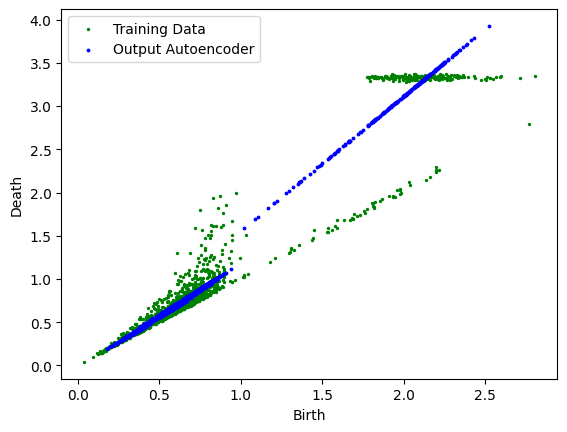

epoch-82, done
1.588182424545288


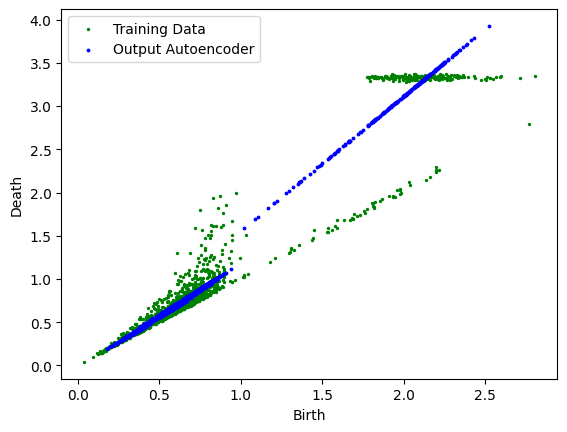

epoch-83, done
1.588182424545288


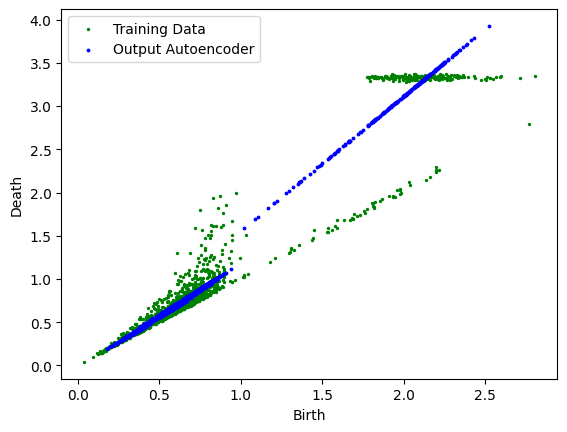

epoch-84, done
1.588182424545288


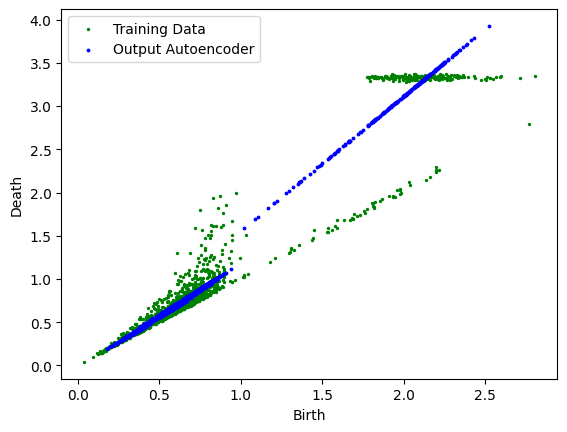

epoch-85, done
1.588182424545288


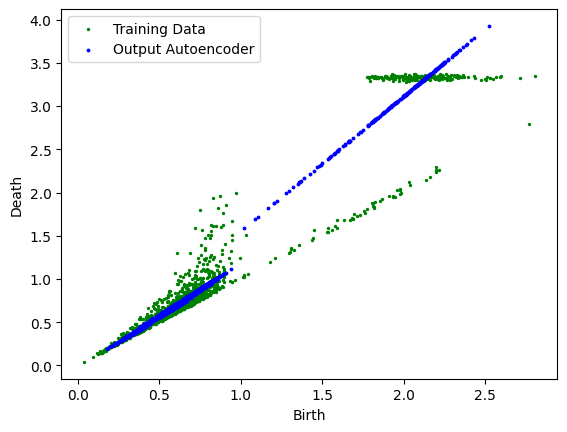

epoch-86, done
1.588182424545288


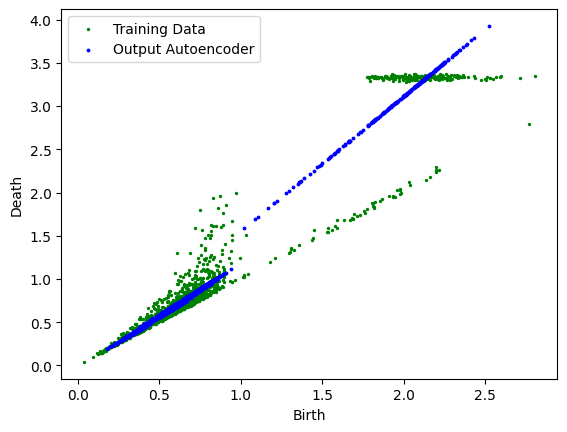

epoch-87, done
1.588182424545288


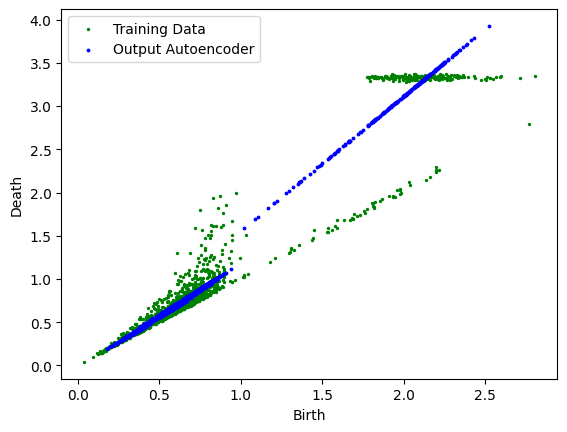

epoch-88, done
1.588182424545288


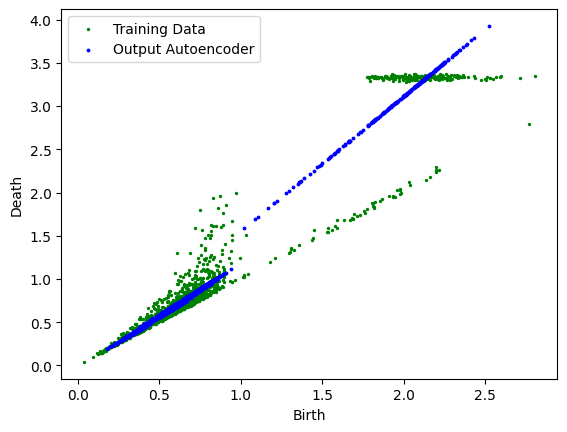

epoch-89, done
1.588182424545288


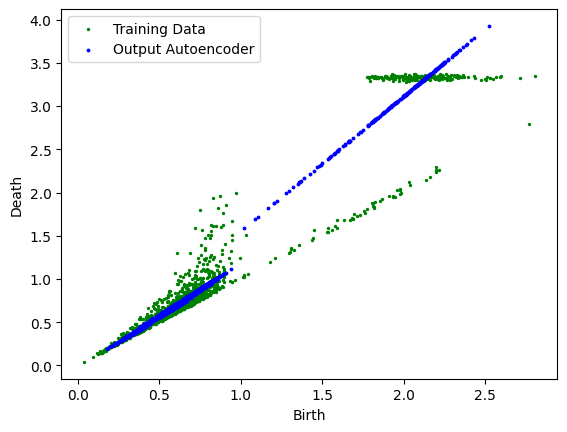

epoch-90, done
1.588182424545288


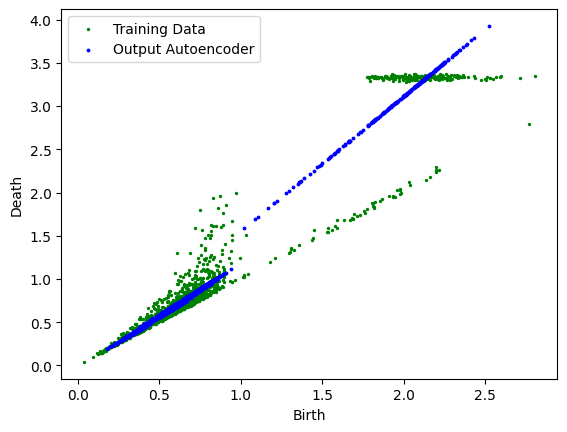

epoch-91, done
1.588182424545288


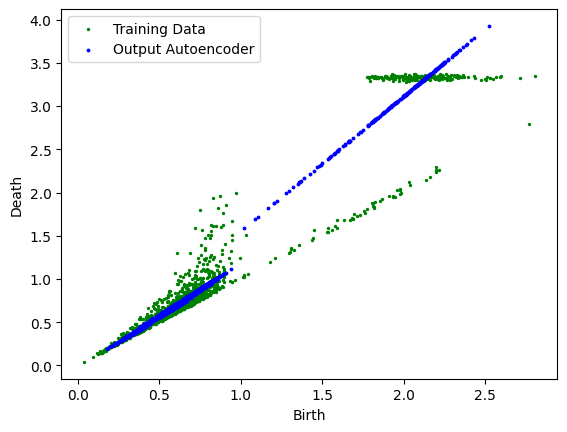

epoch-92, done
1.588182424545288


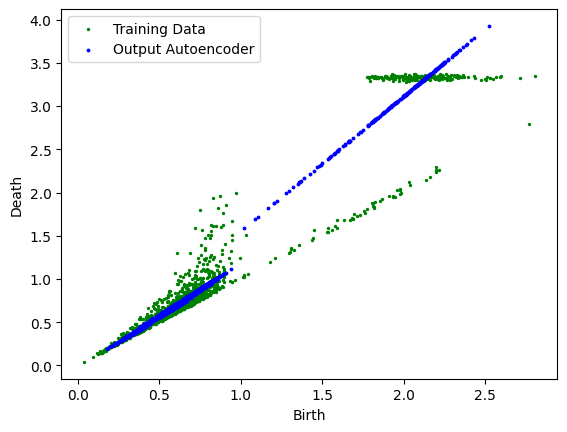

epoch-93, done
1.588182424545288


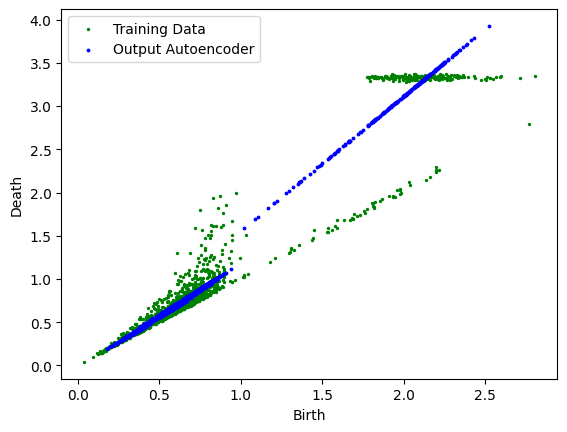

epoch-94, done
1.588182424545288


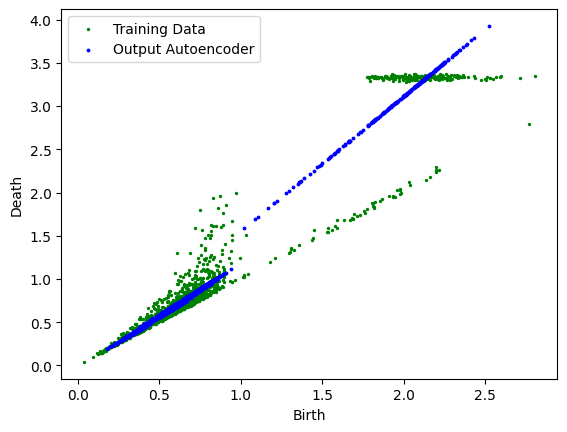

epoch-95, done
1.588182424545288


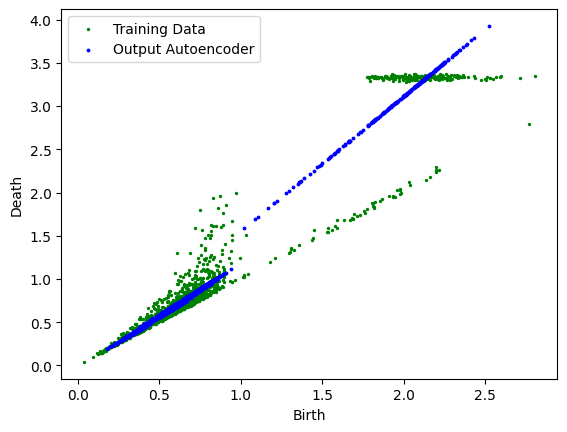

epoch-96, done
1.588182424545288


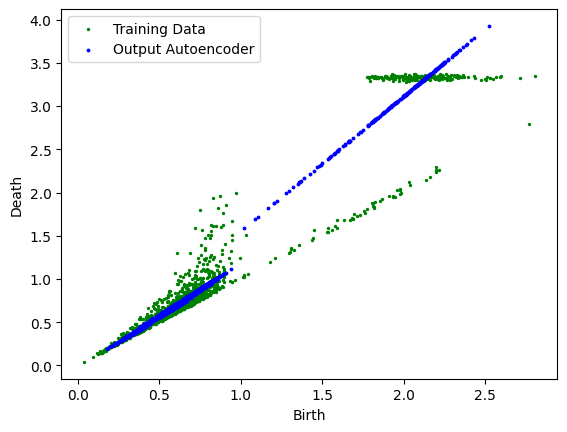

epoch-97, done
1.588182424545288


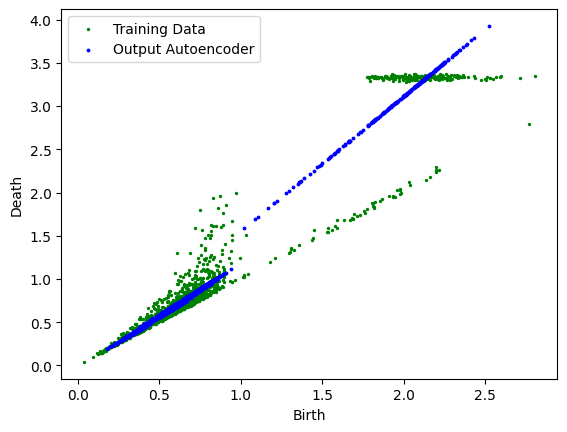

epoch-98, done
1.588182424545288


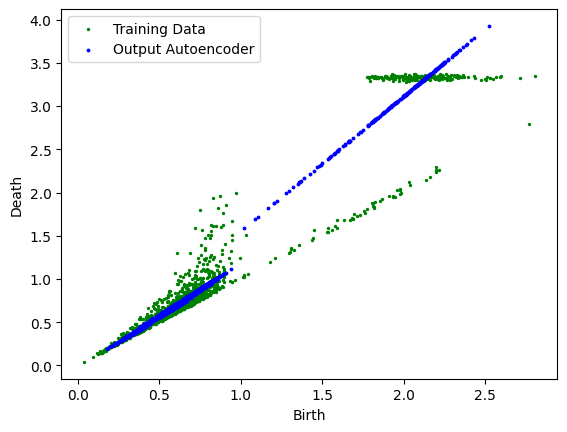

epoch-99, done
1.588182424545288


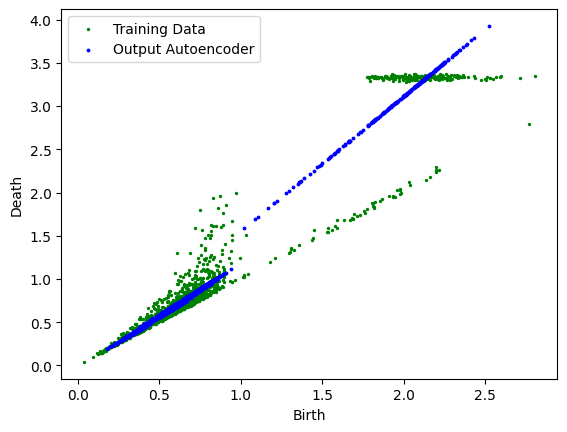

In [84]:
ae = AutoEncoder(False)
plt.rcParams.update(plt.rcParamsDefault) # Avoids some matplotlib fuckery on my machine 
ae_trainer = AETrainer(ae)
epochs = 100
plot_data_ae(tensors_circle, ae_trainer.model.forward(torch.stack(tensor_validation_circle)))
plot_data_ae(tensors_torus, ae_trainer.model.forward(torch.stack(tensors_torus)))

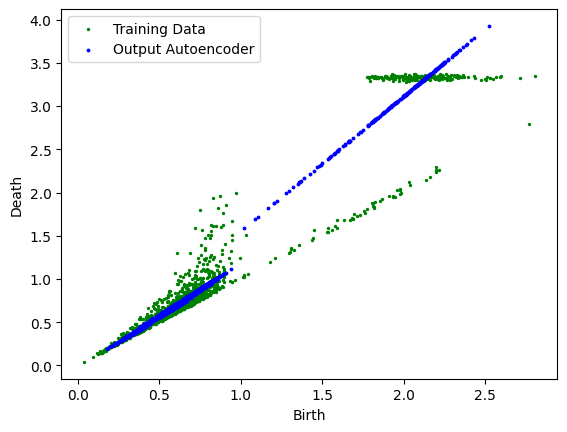

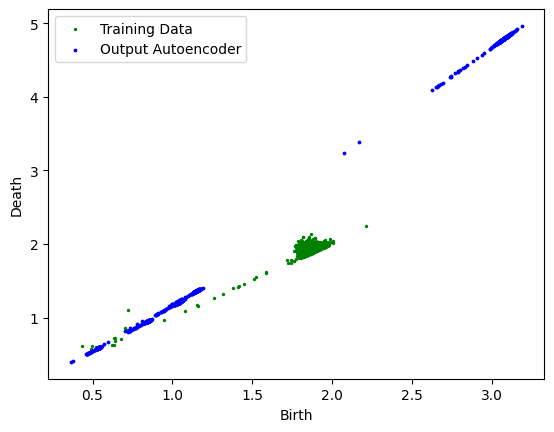

In [85]:
plot_data_ae(tensors_circle, ae_trainer.model.forward(torch.stack(tensors_circle)))
plot_data_ae(tensors_torus, ae_trainer.model.forward(torch.stack(tensors_torus)))

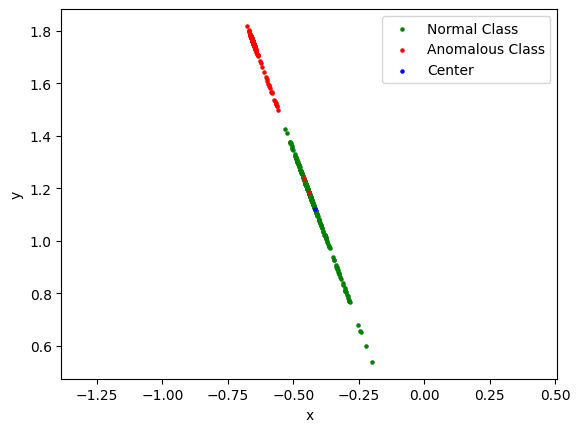

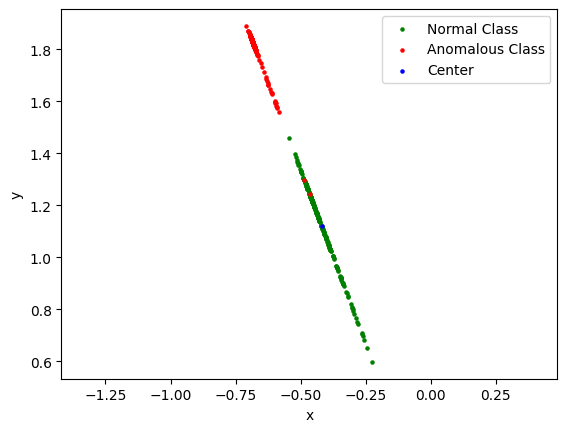

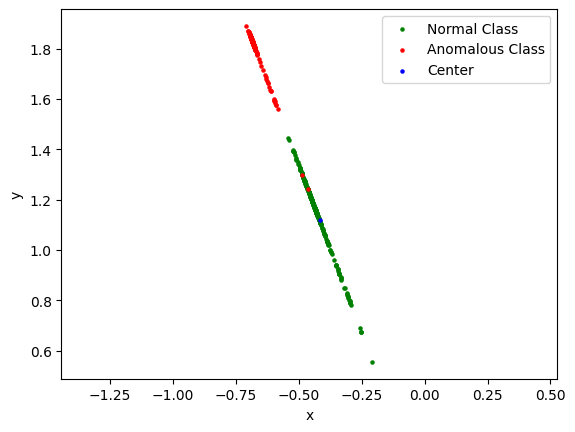

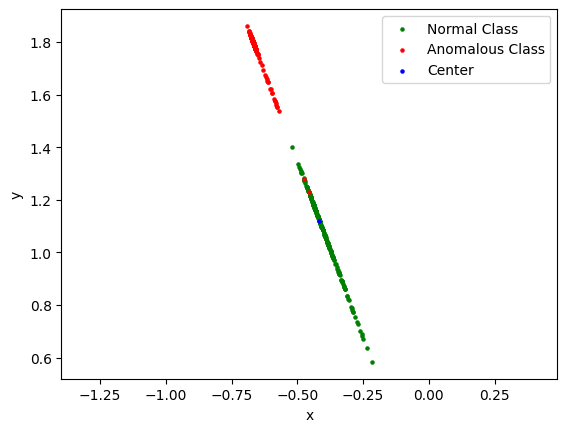

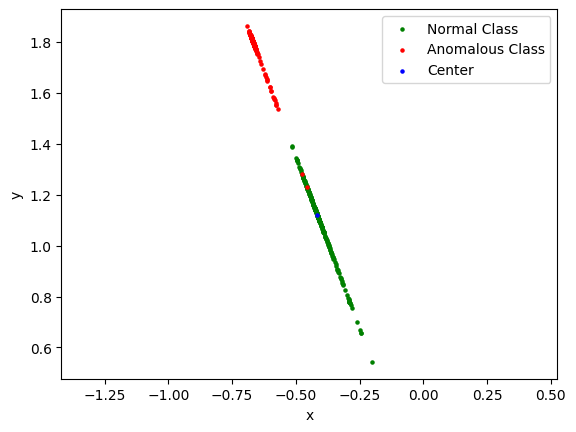

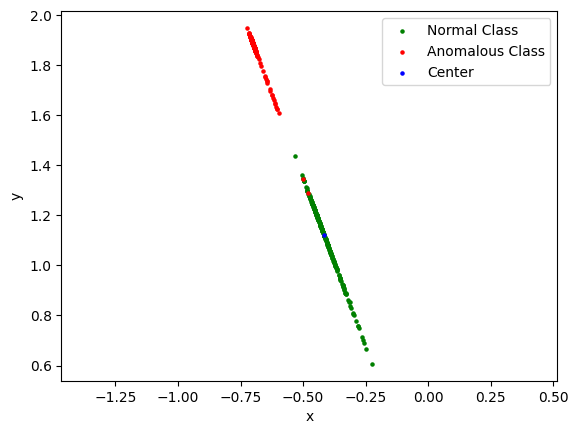

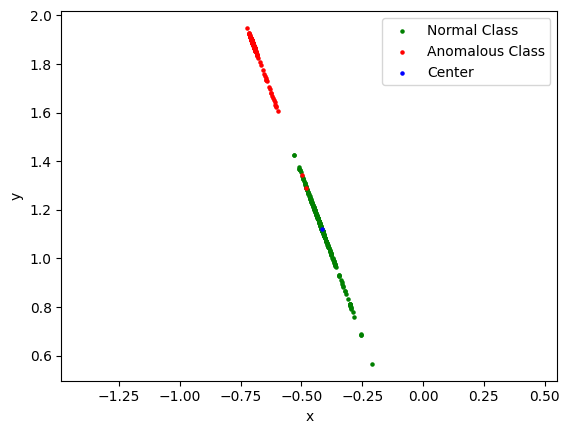

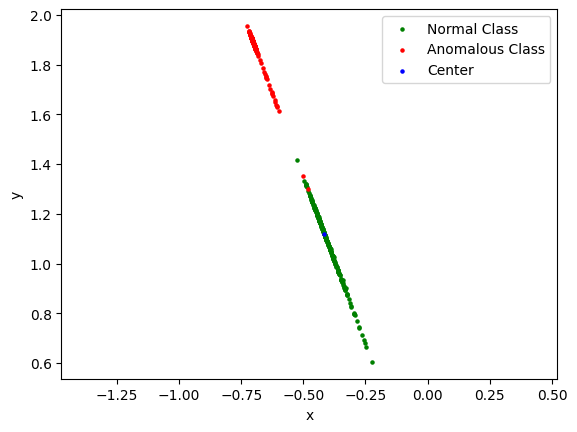

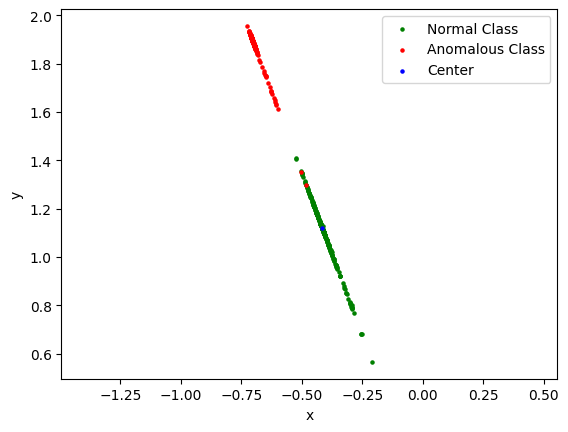

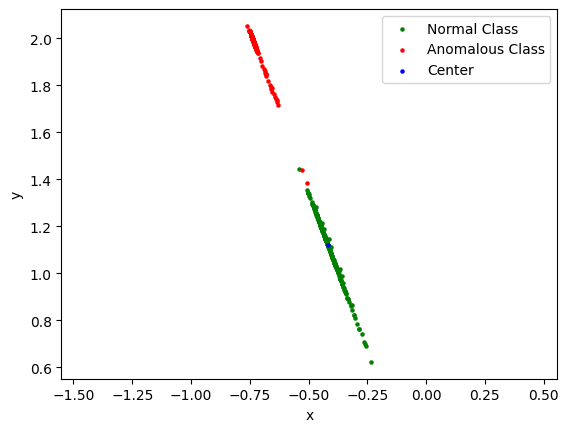

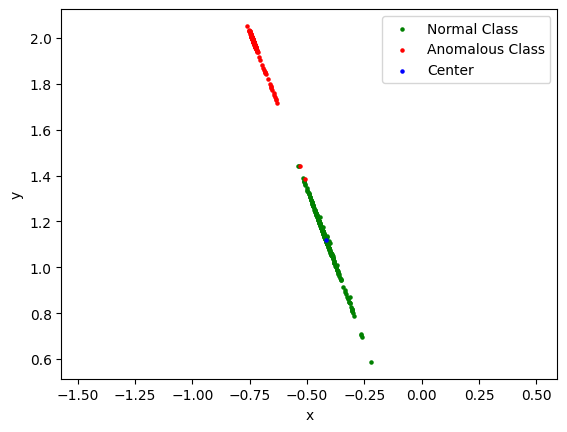

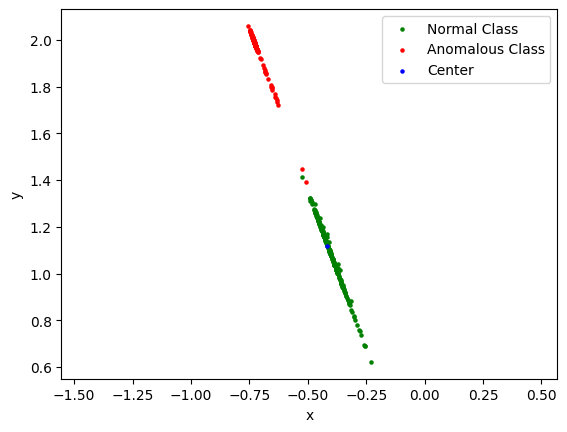

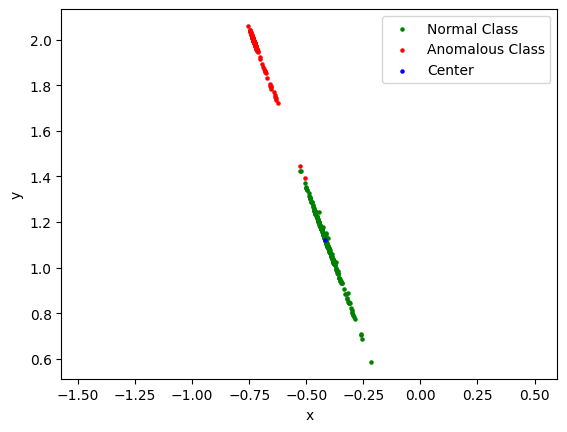

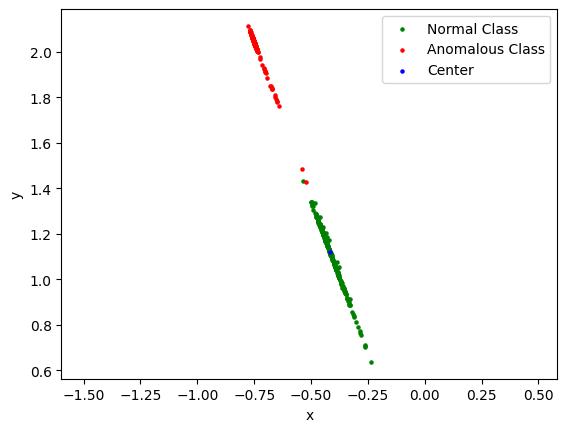

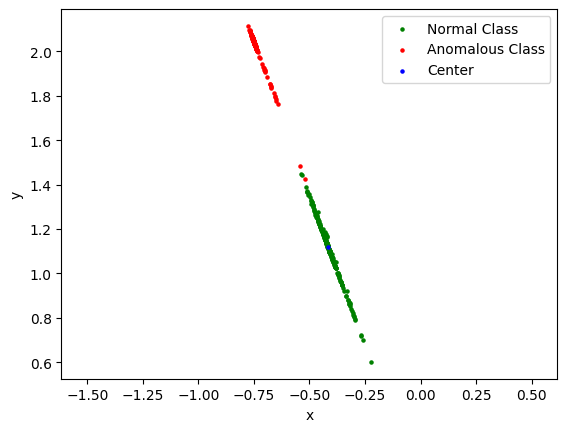

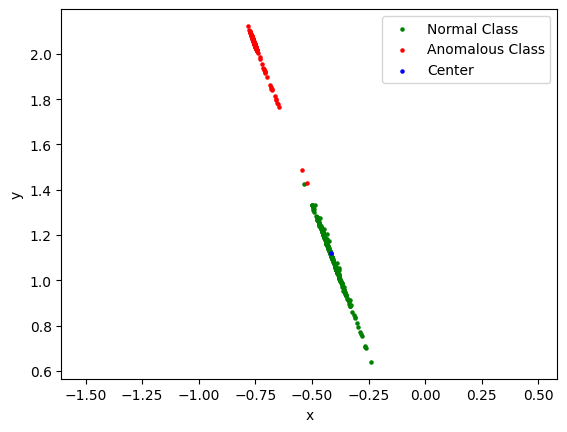

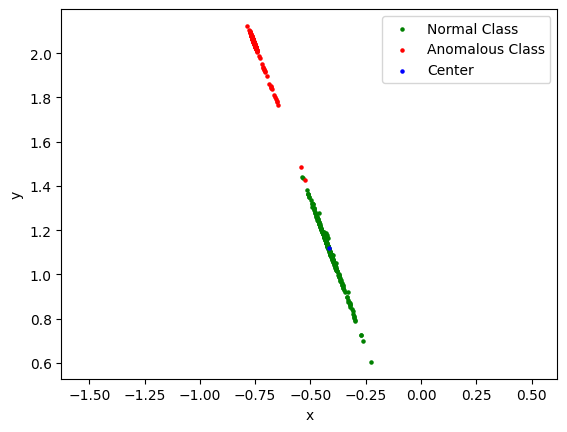

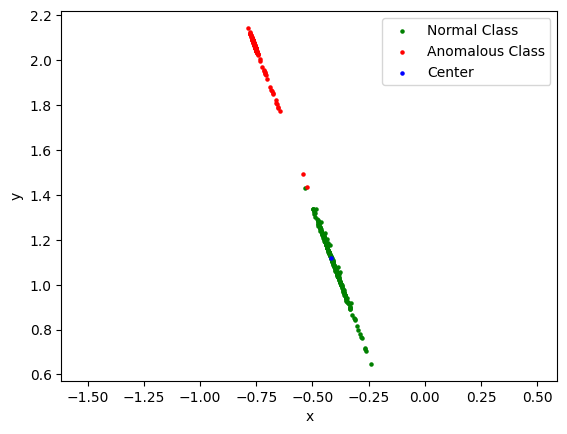

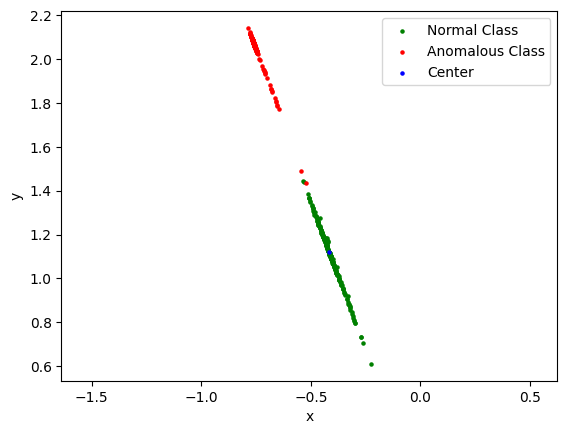

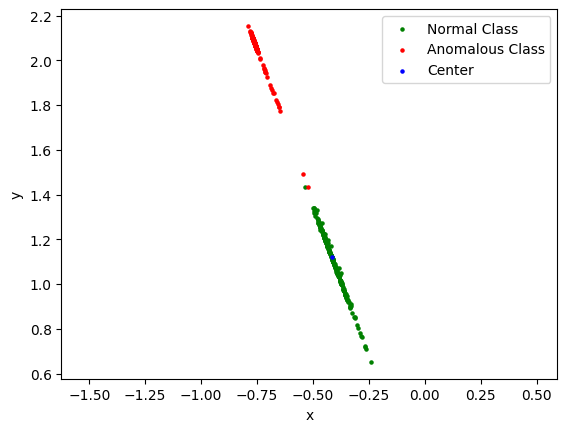

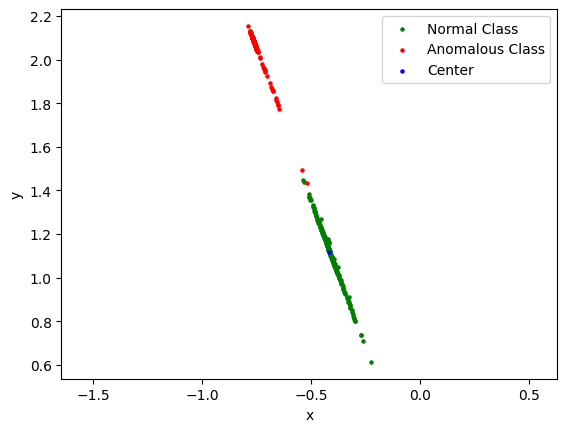

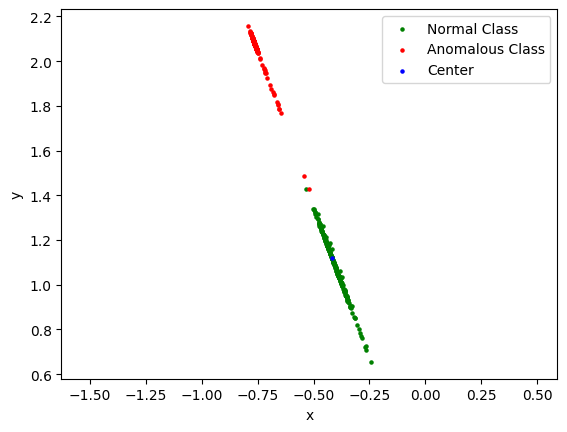

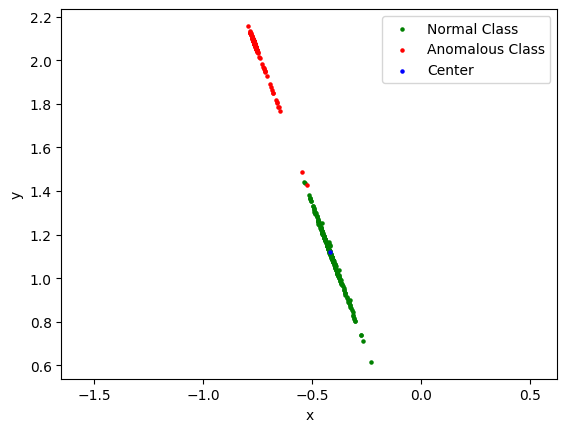

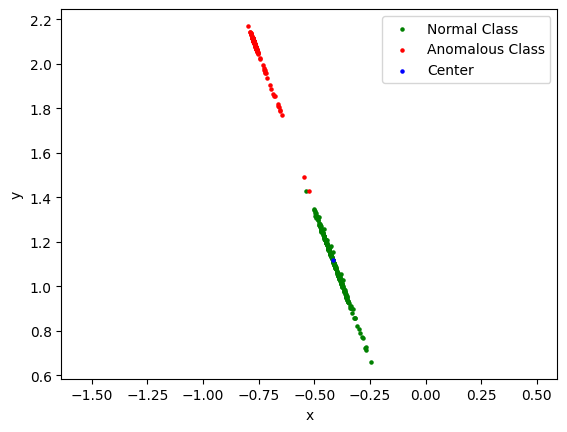

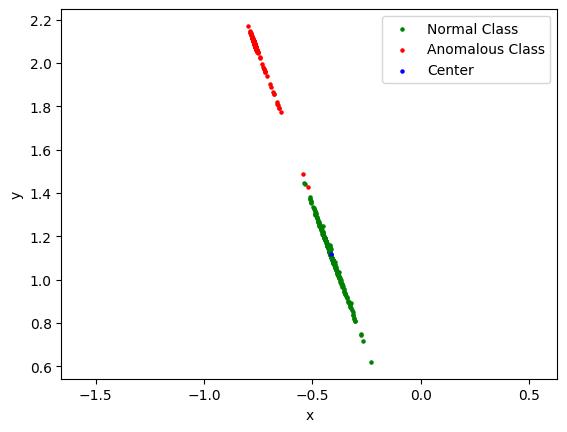

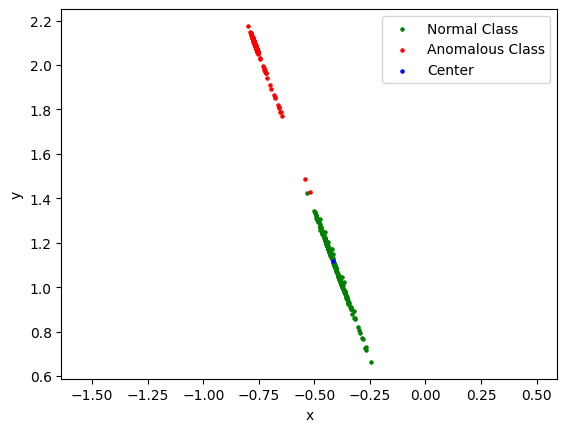

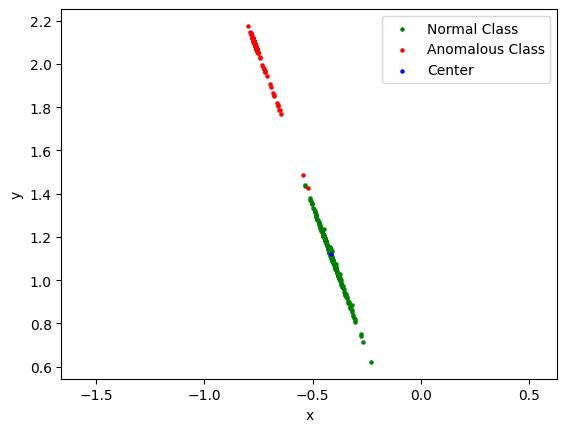

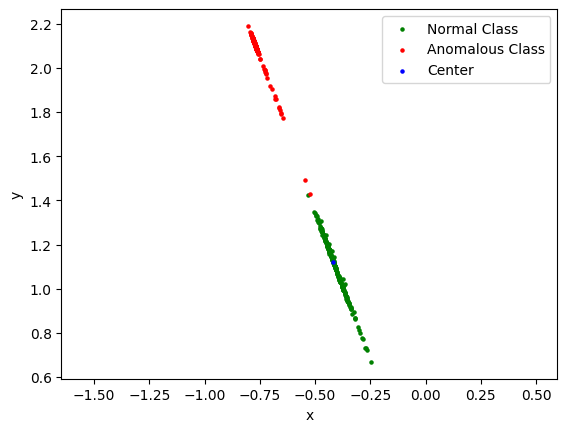

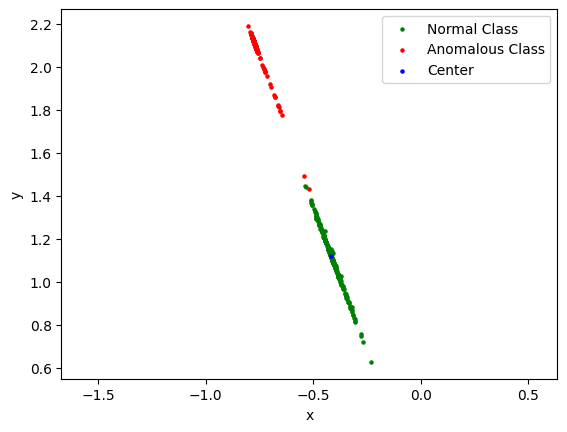

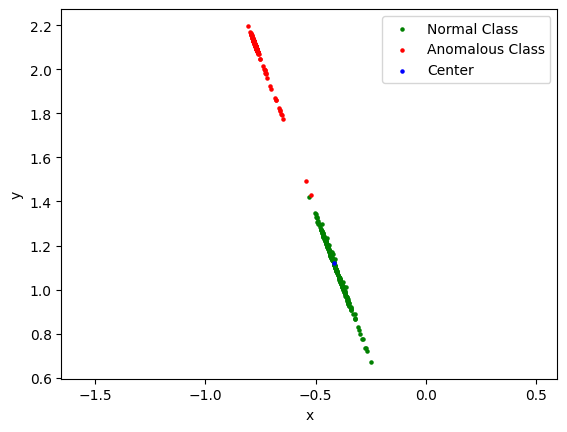

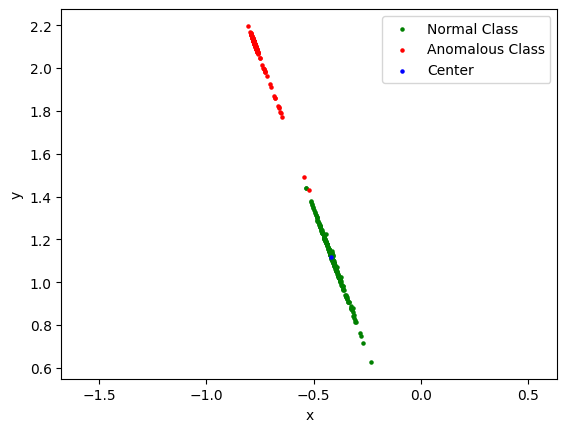

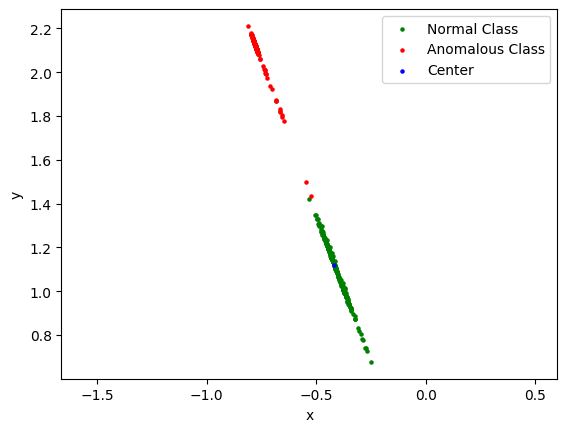

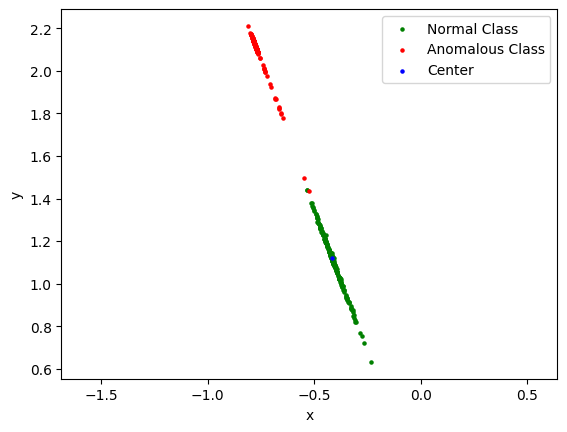

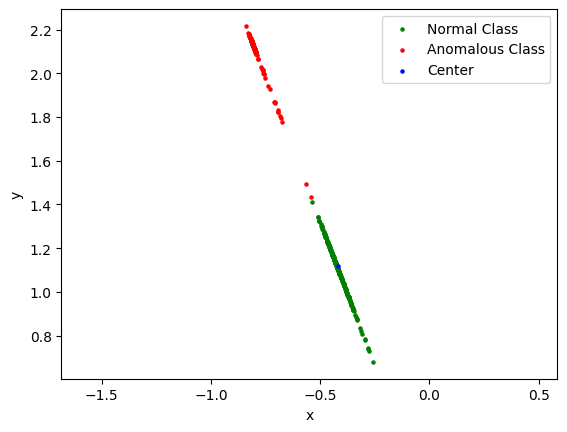

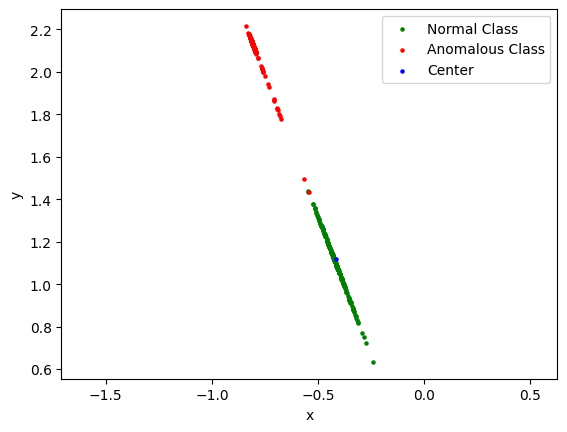

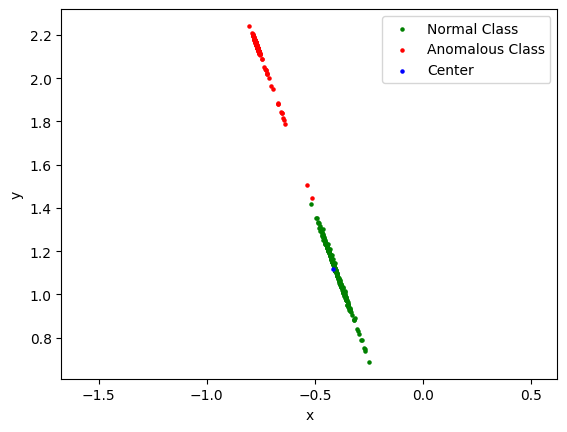

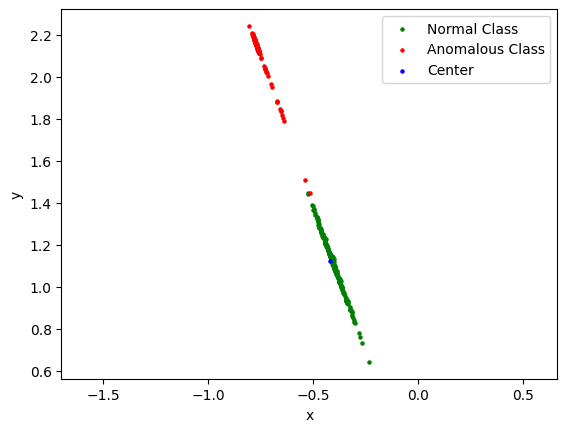

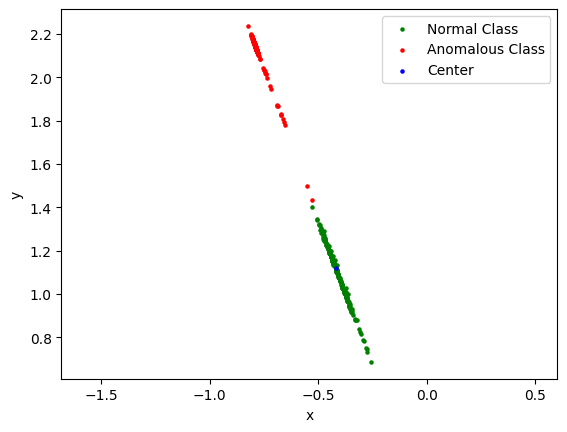

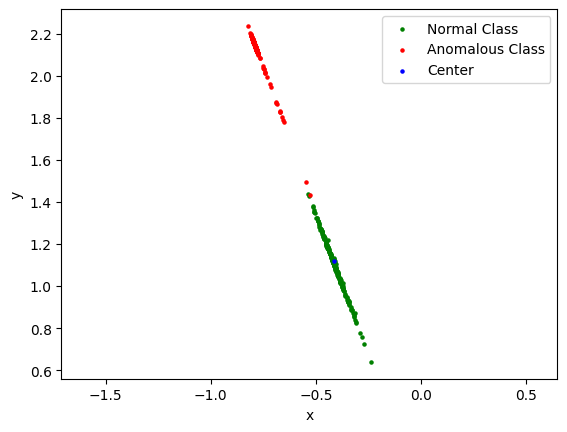

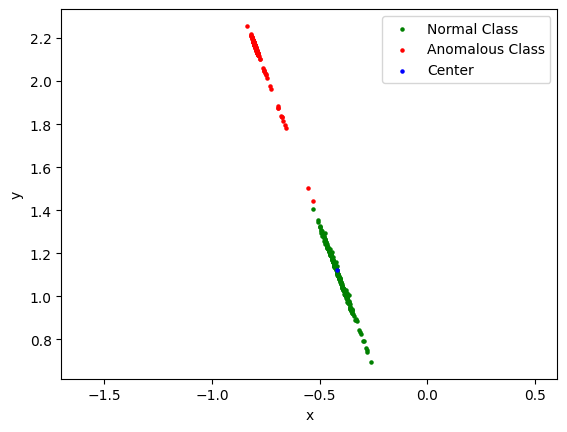

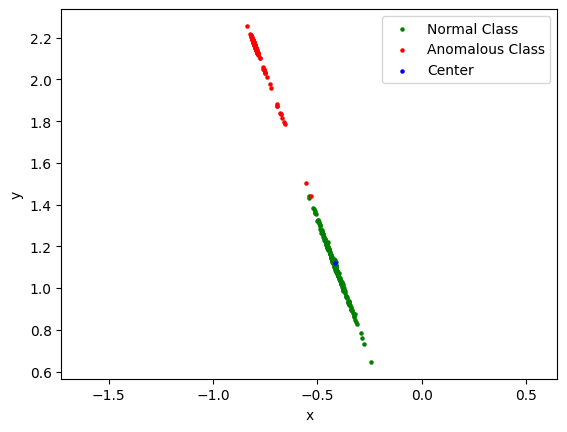

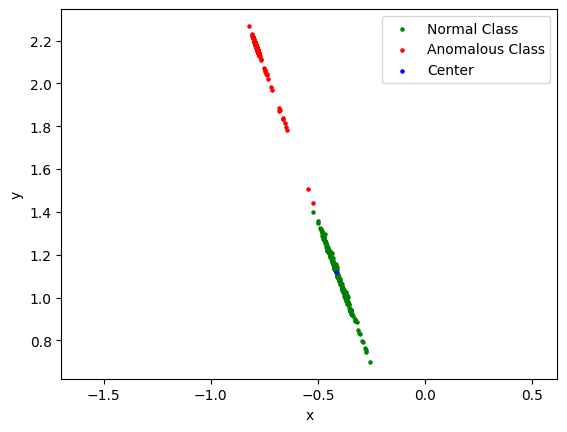

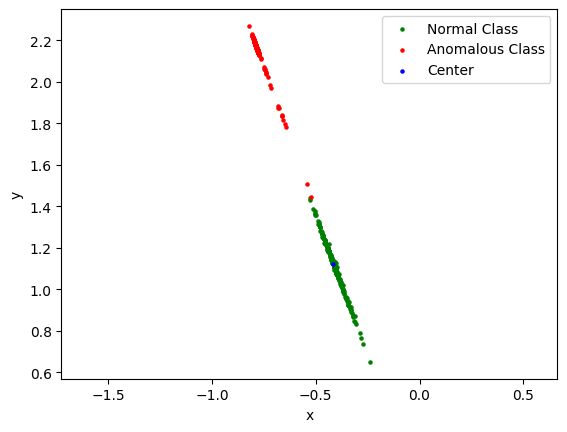

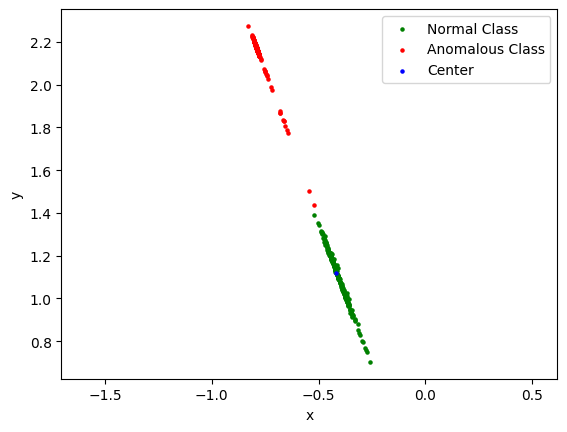

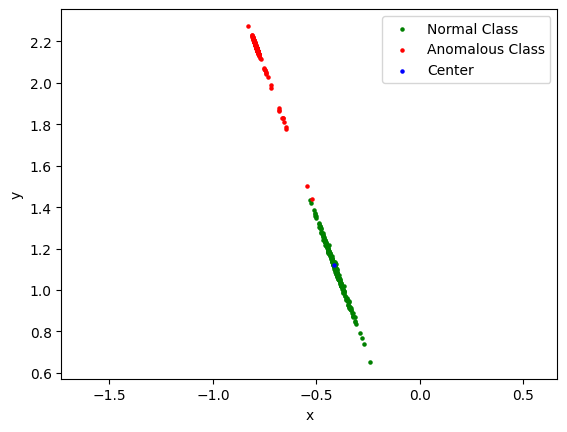

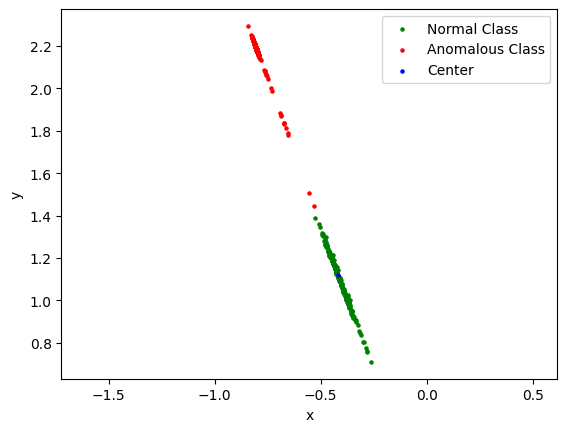

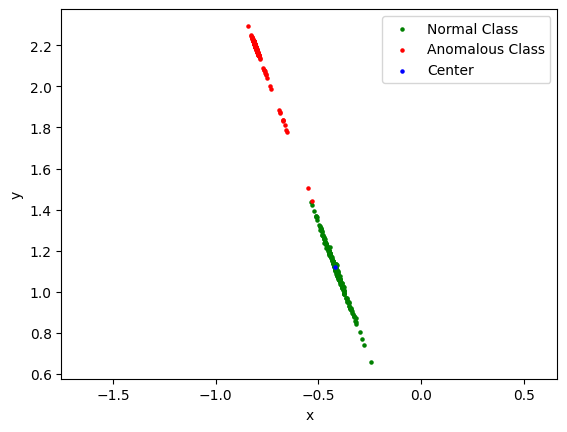

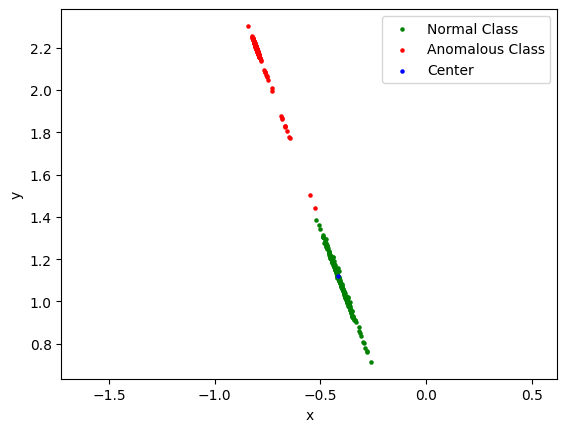

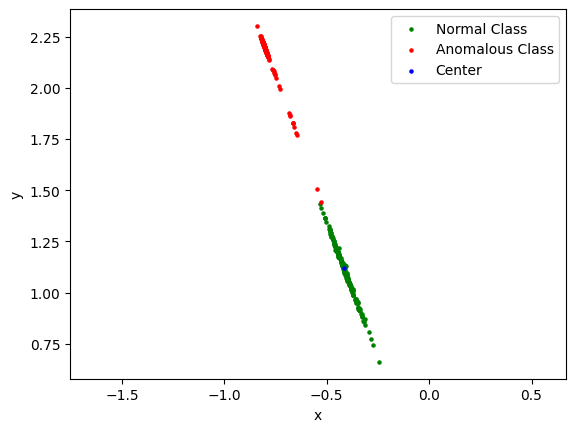

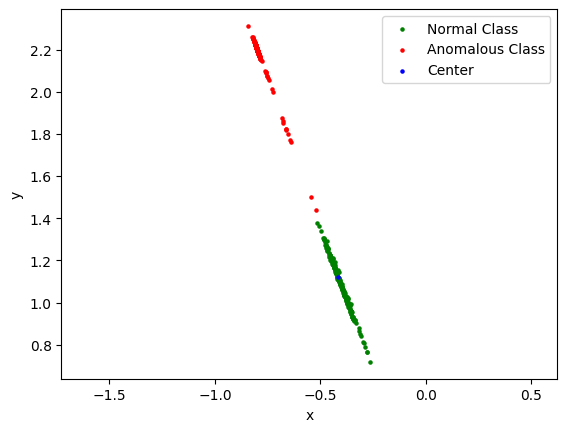

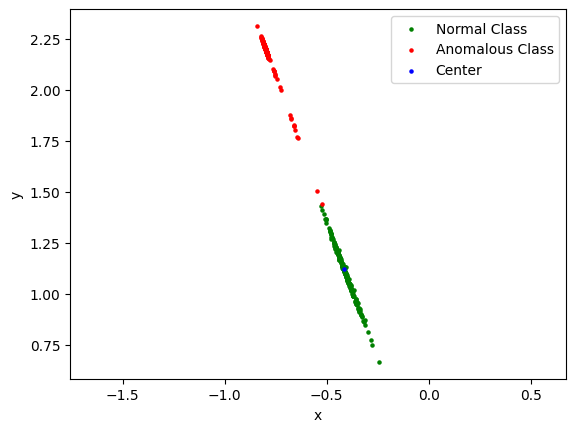

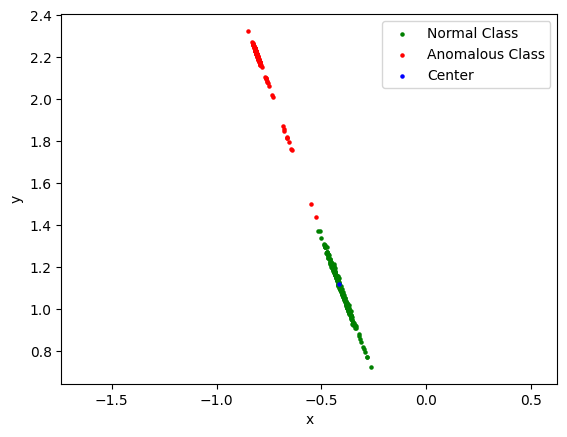

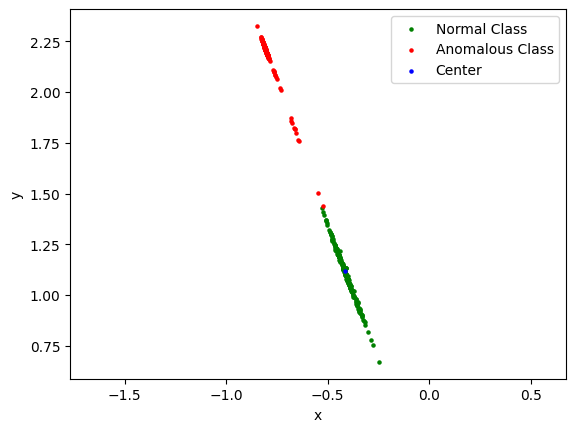

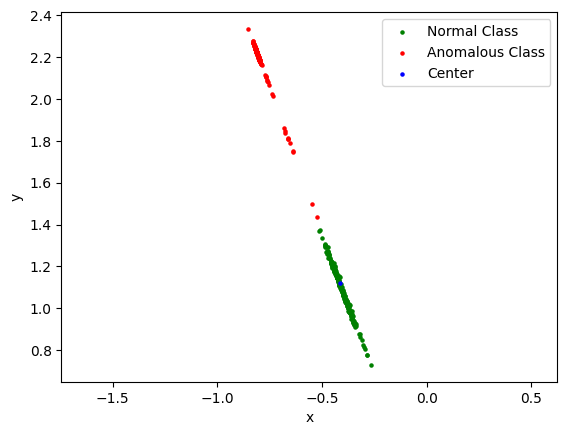

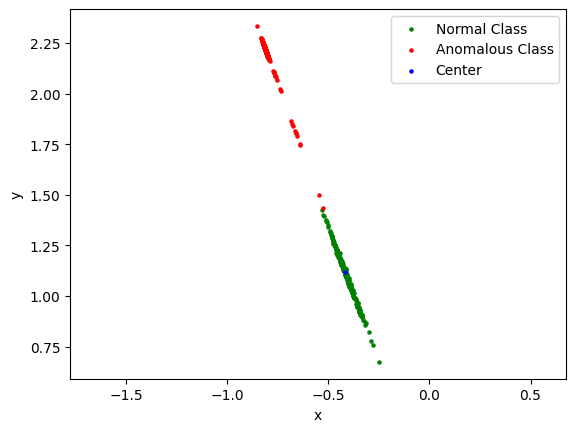

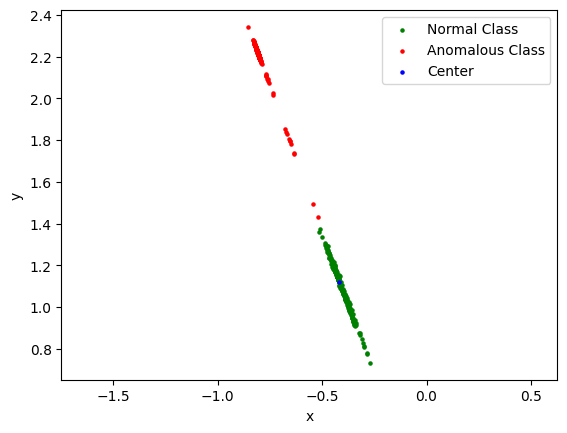

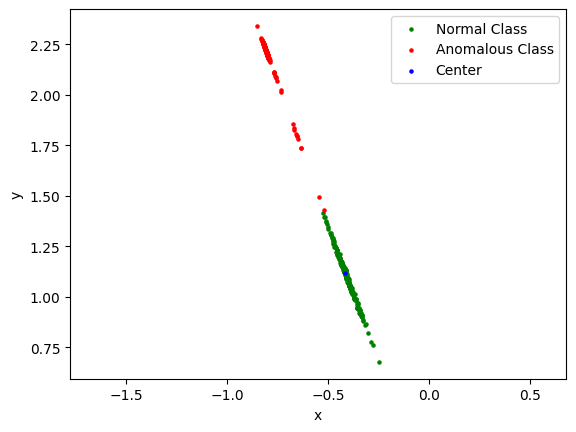

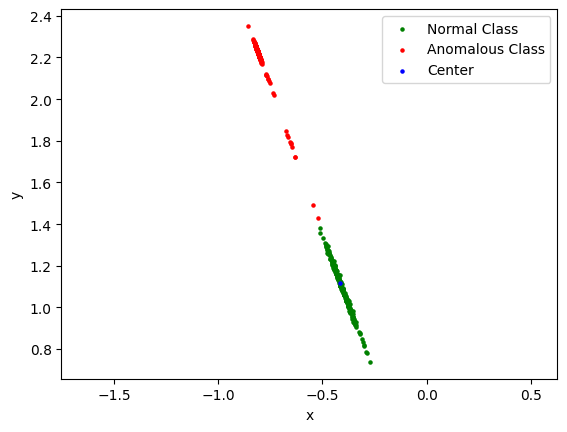

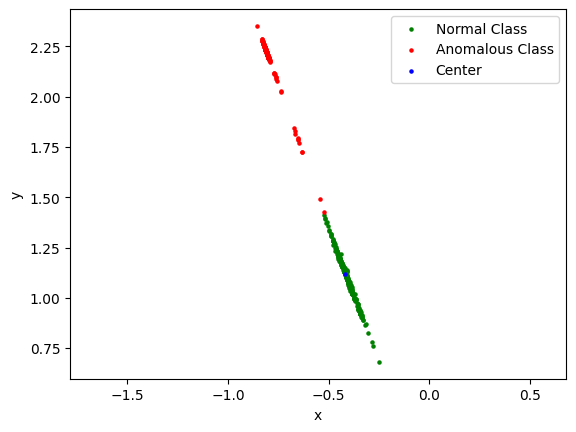

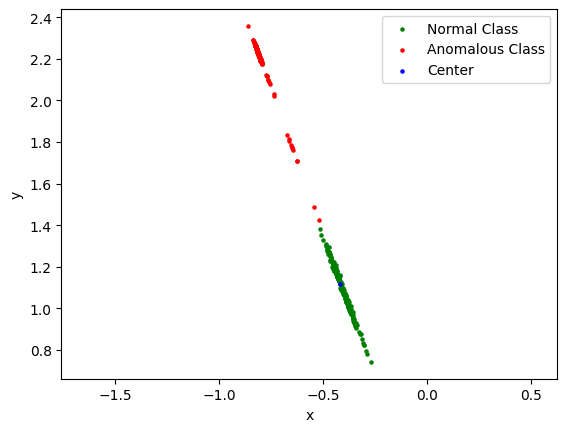

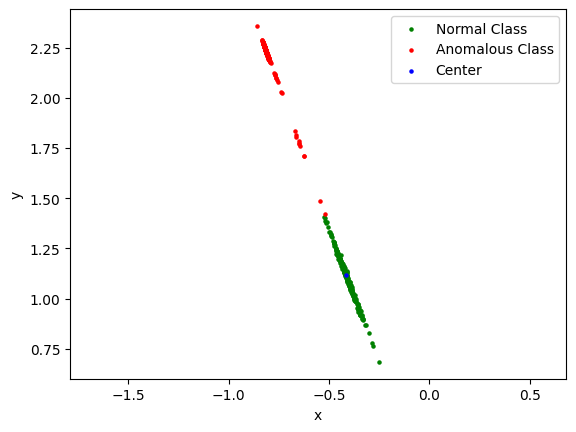

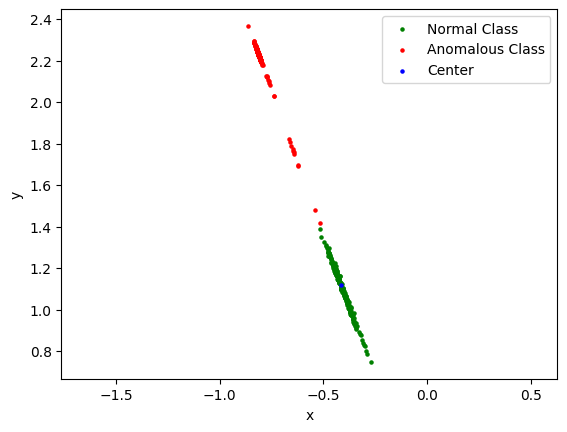

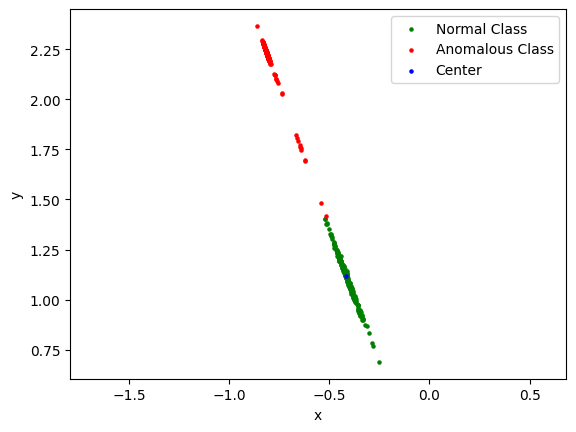

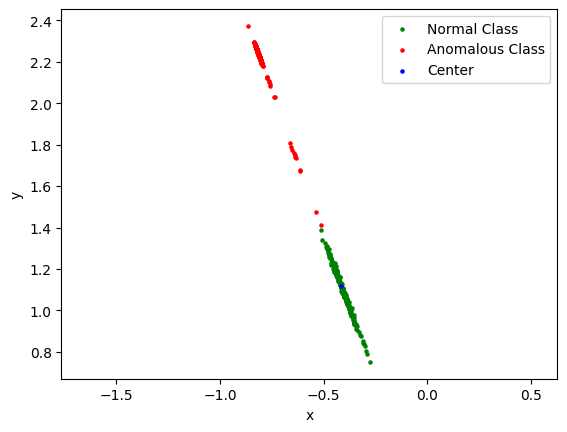

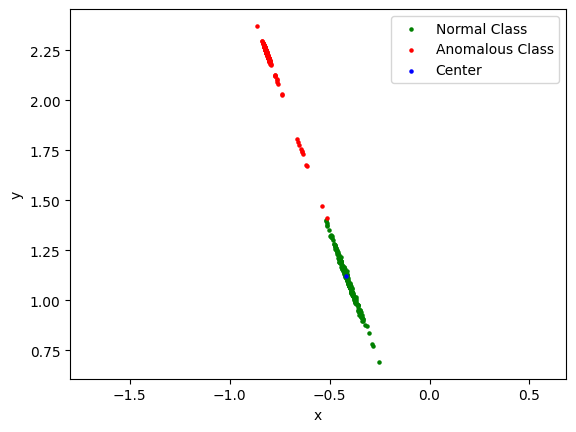

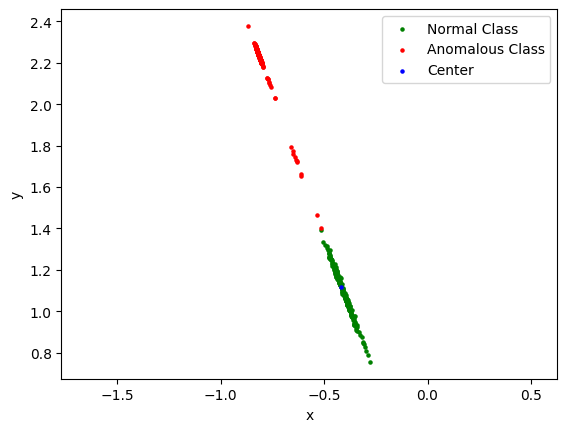

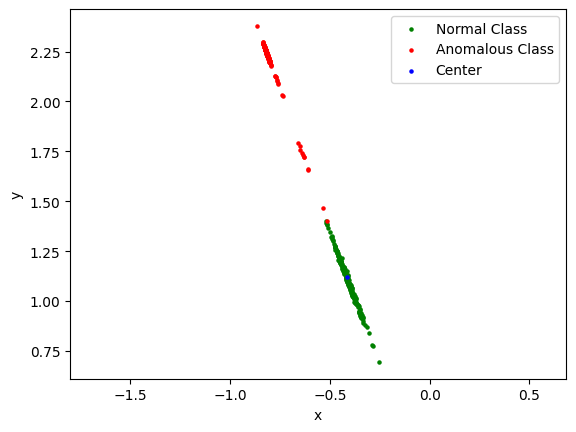

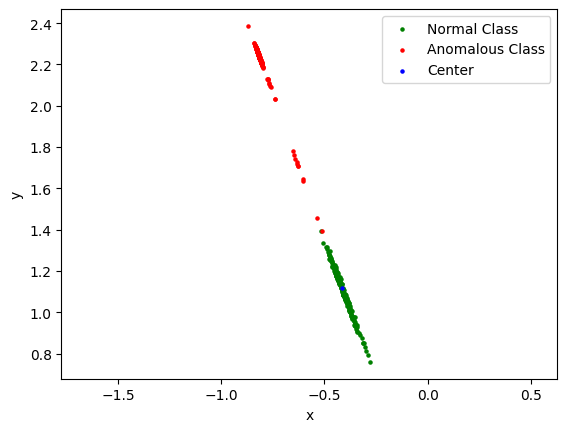

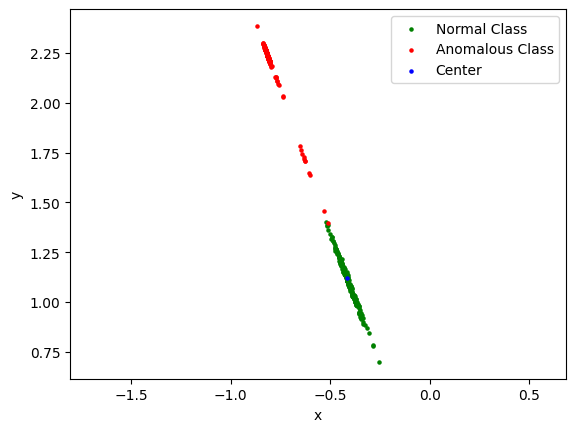

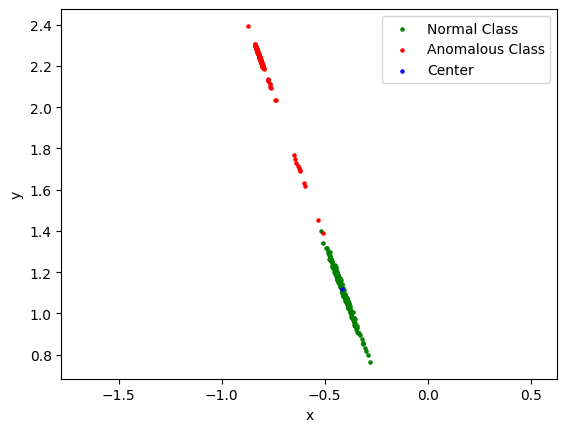

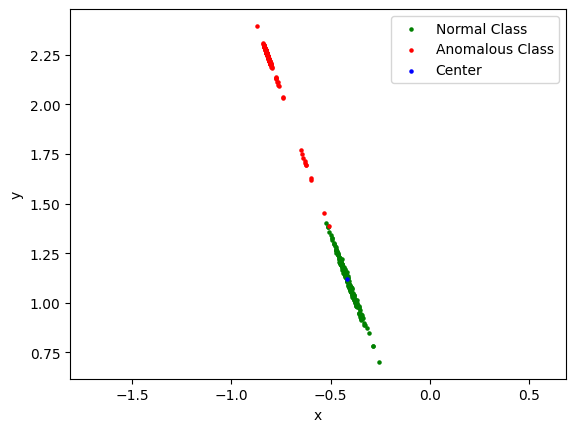

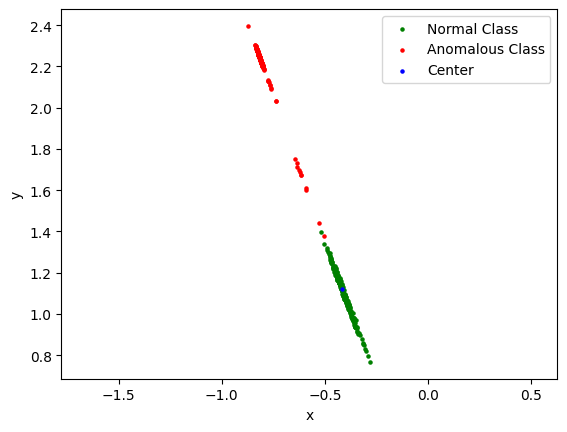

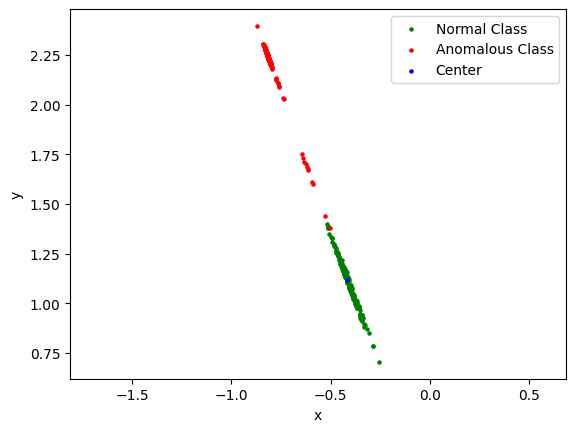

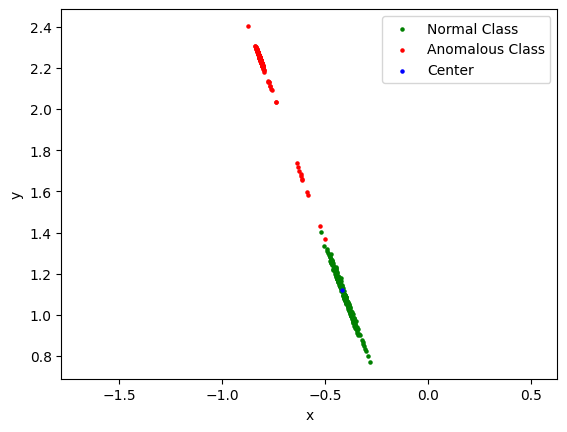

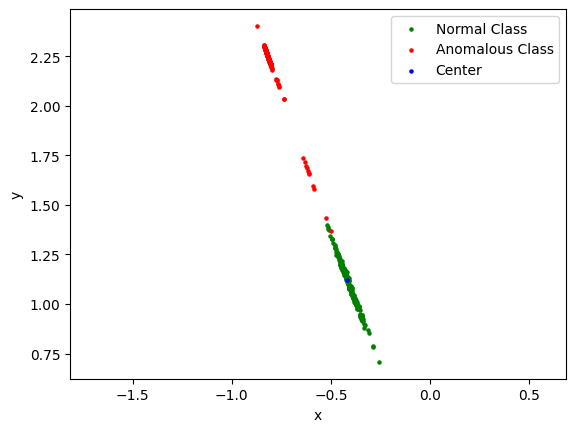

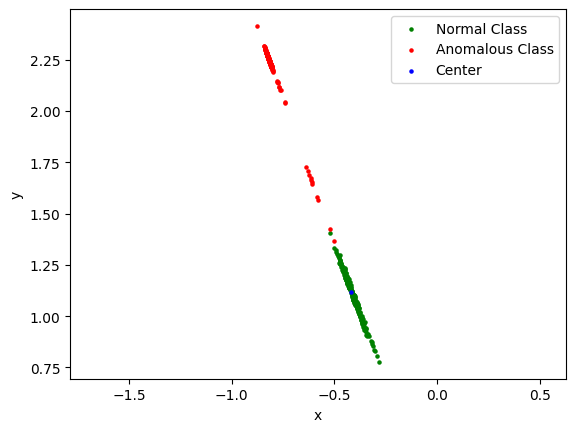

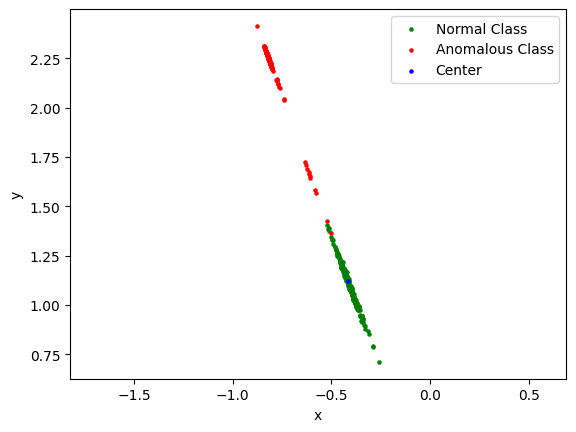

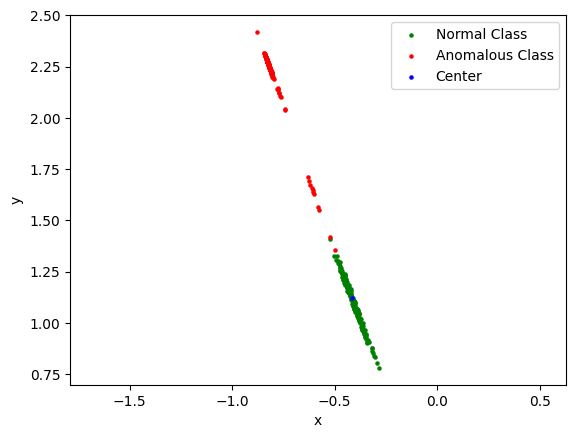

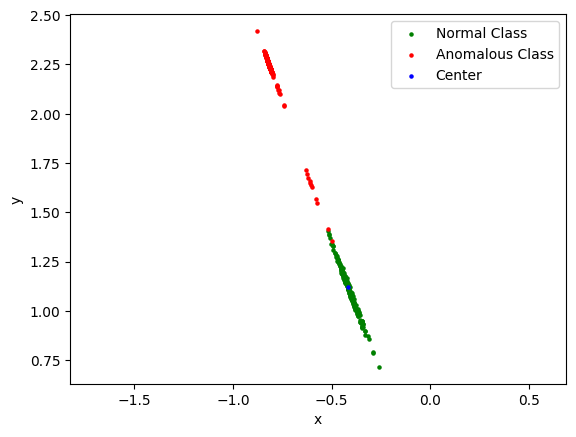

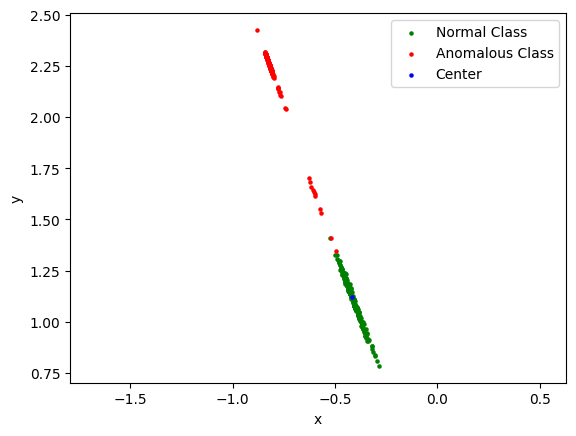

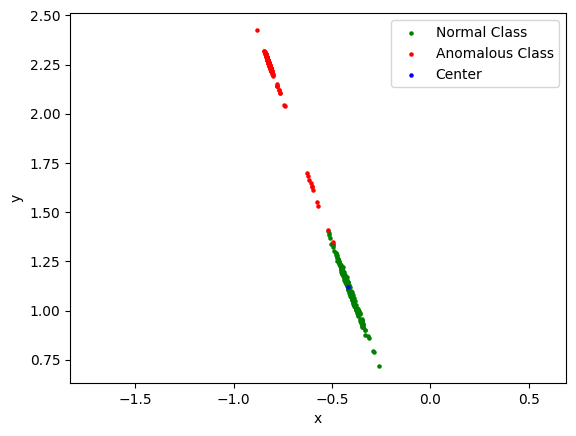

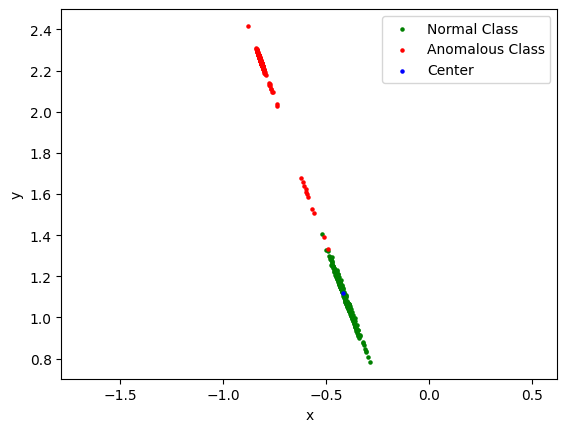

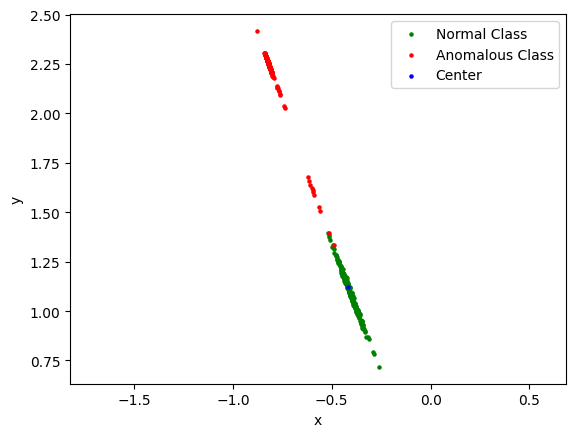

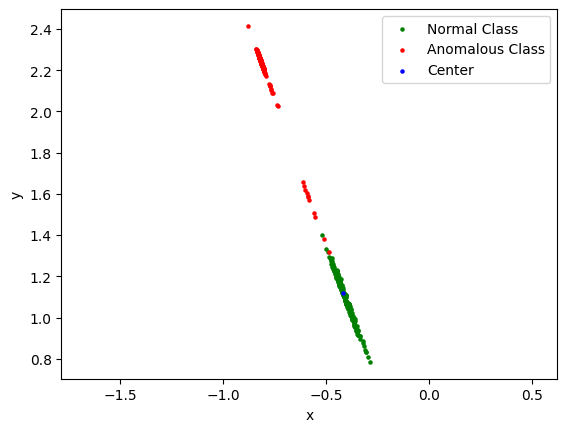

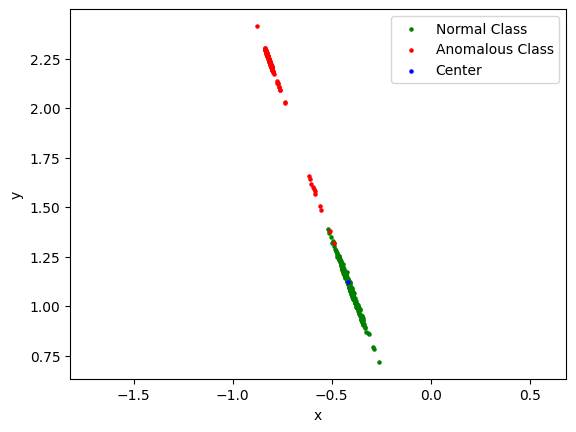

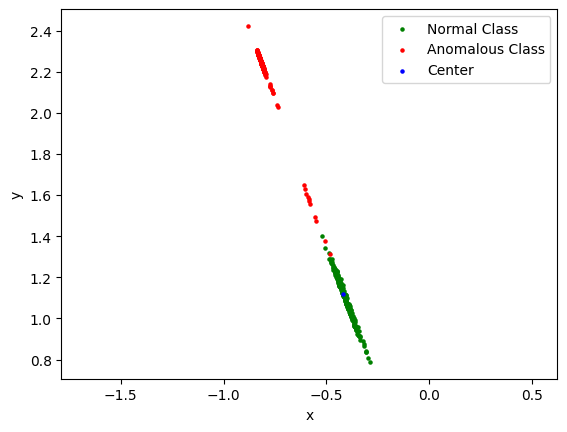

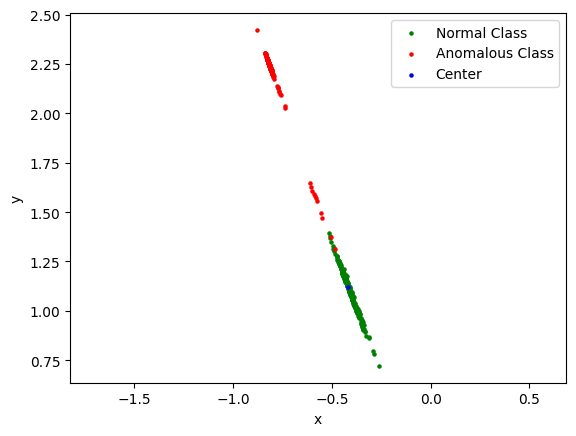

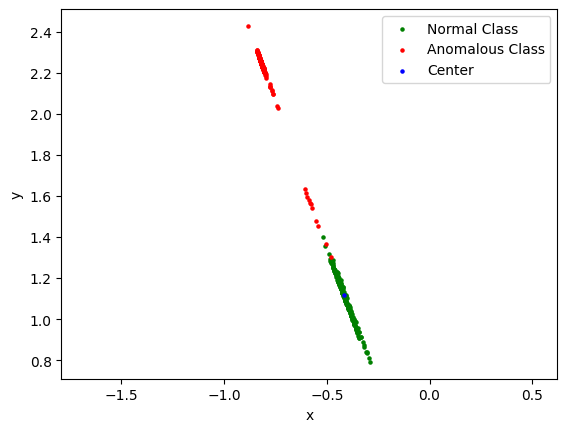

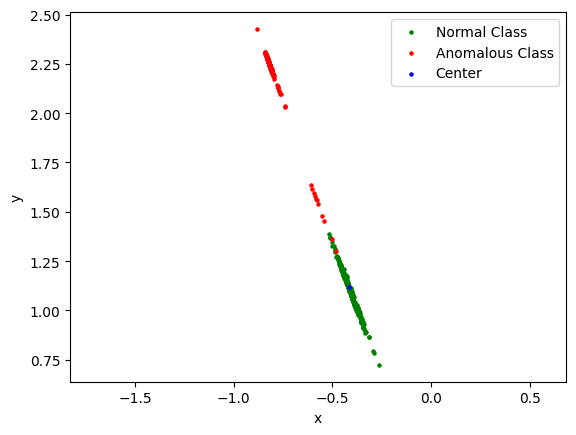

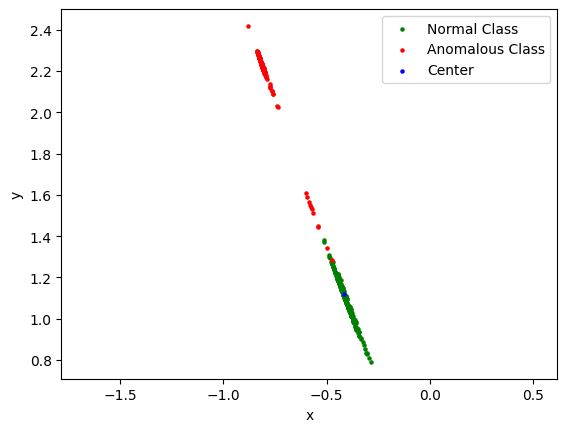

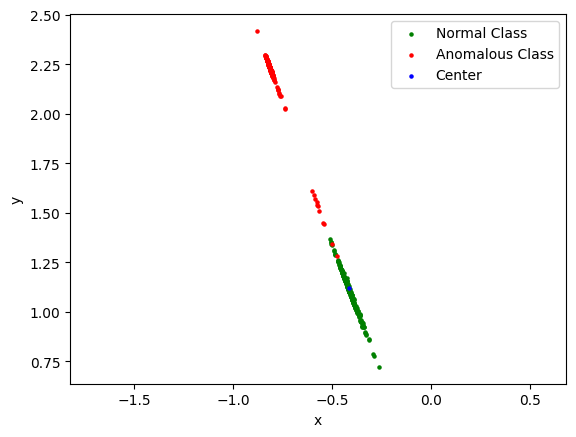

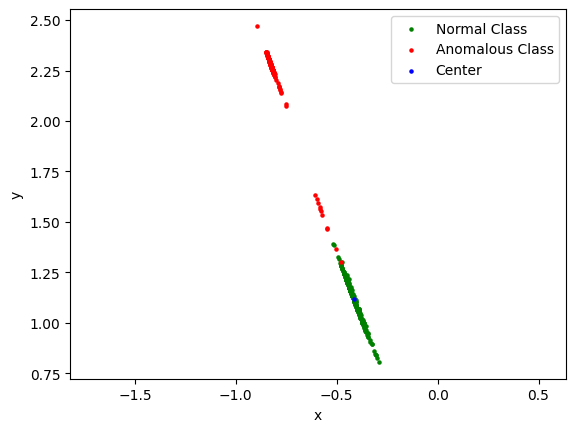

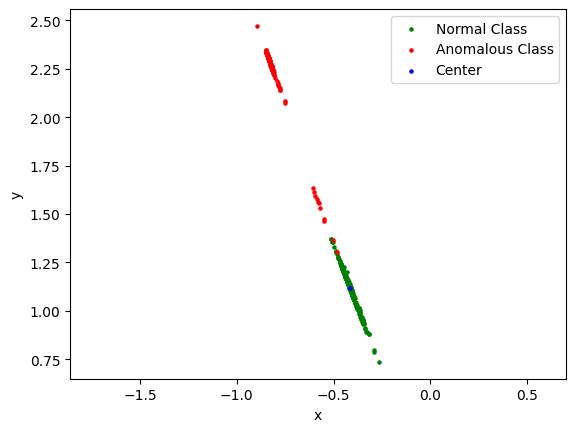

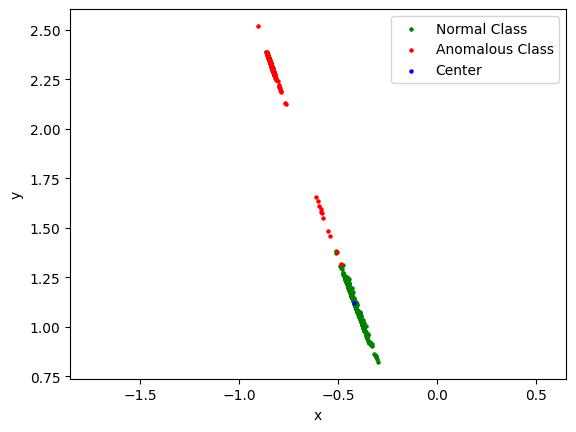

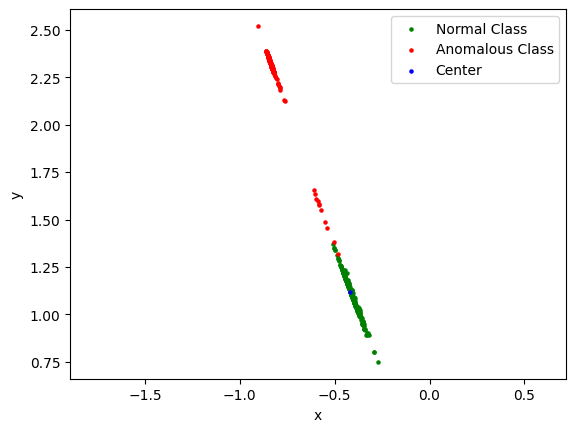

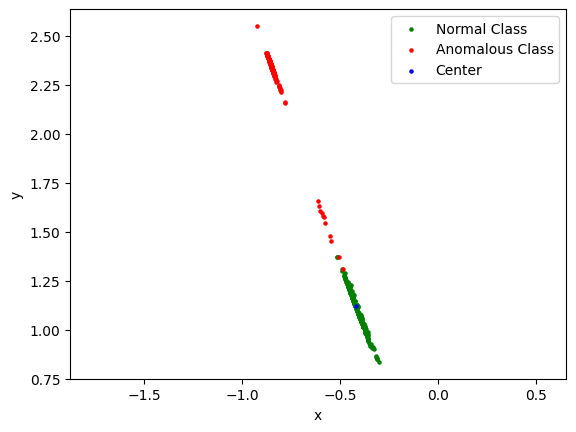

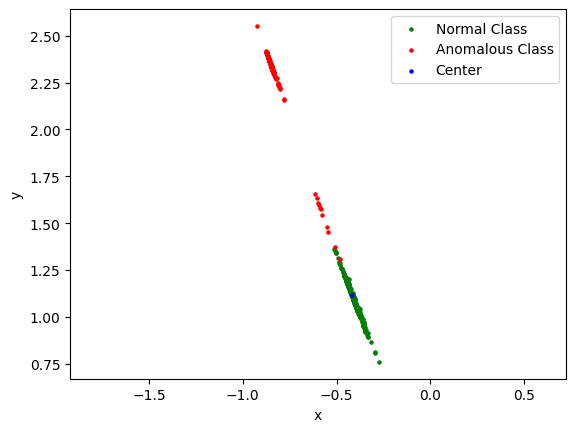

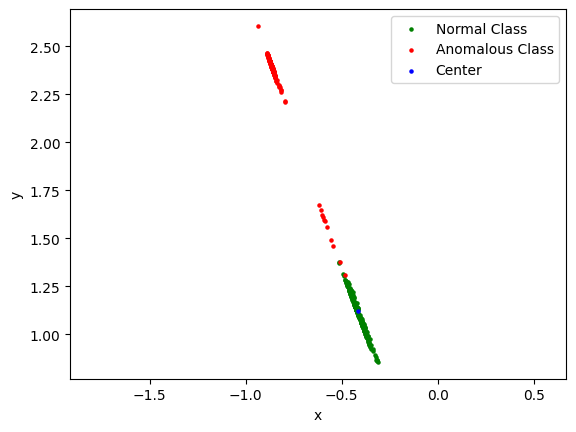

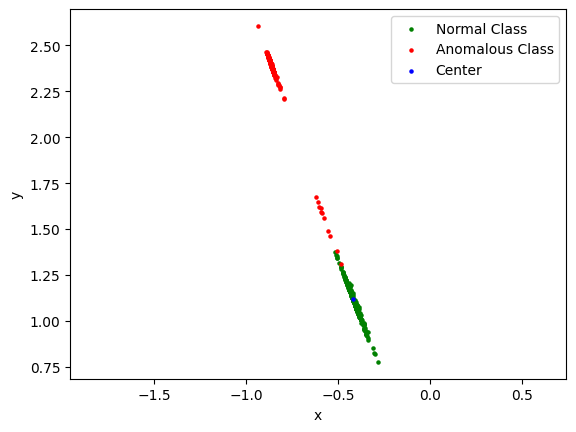

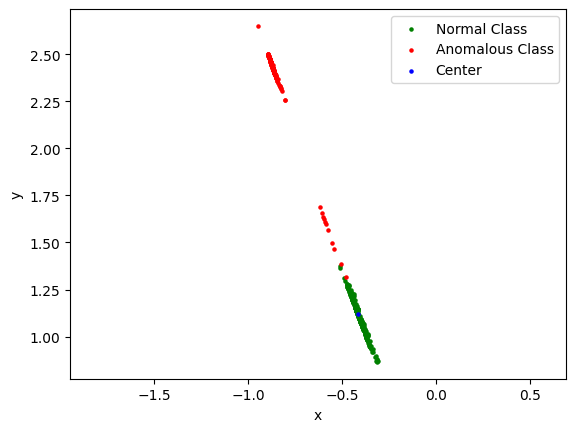

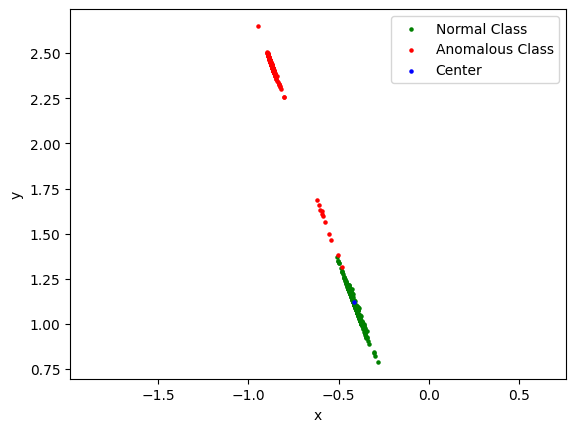

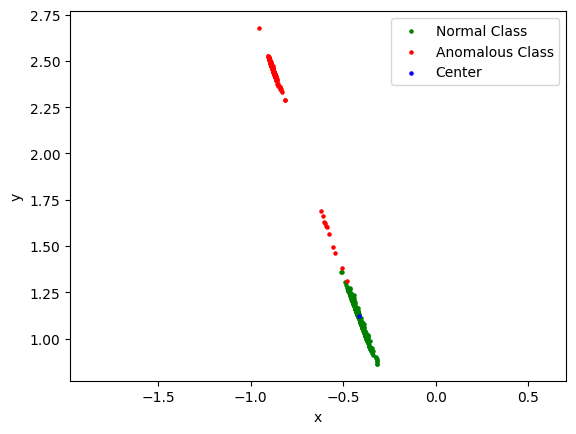

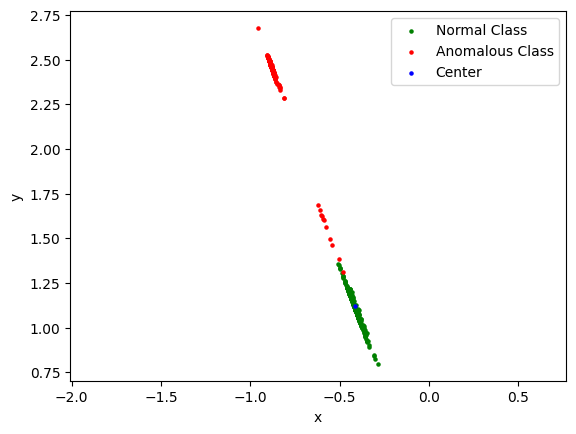

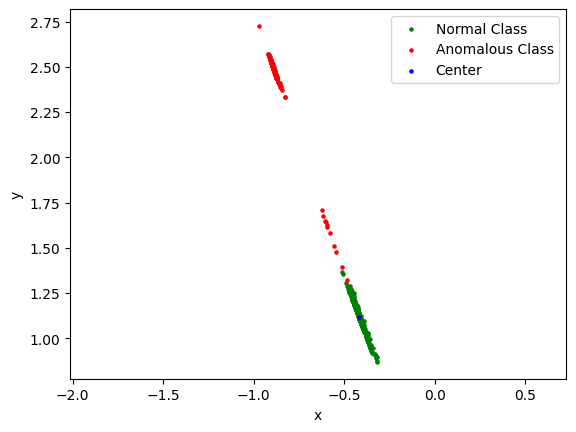

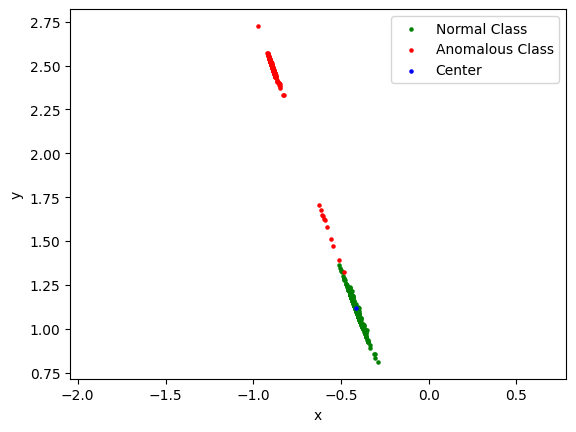

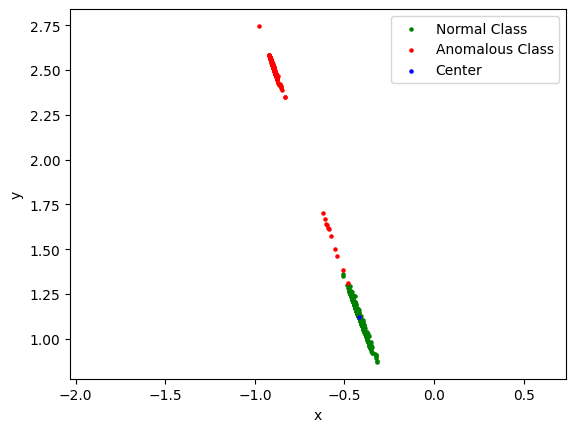

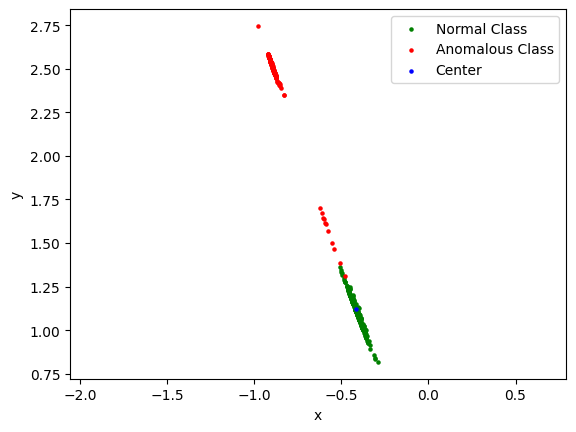

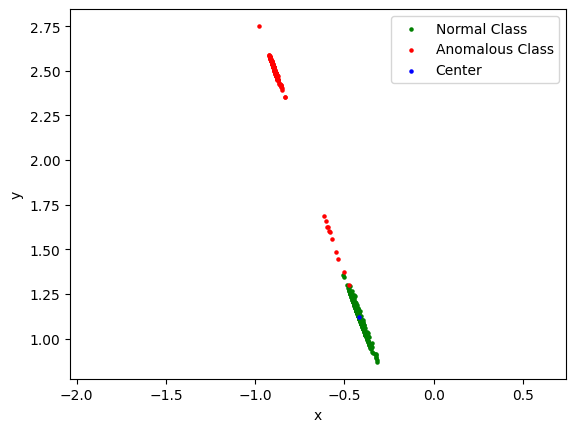

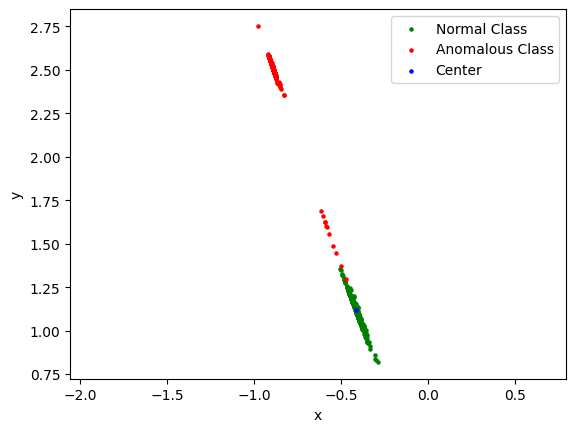

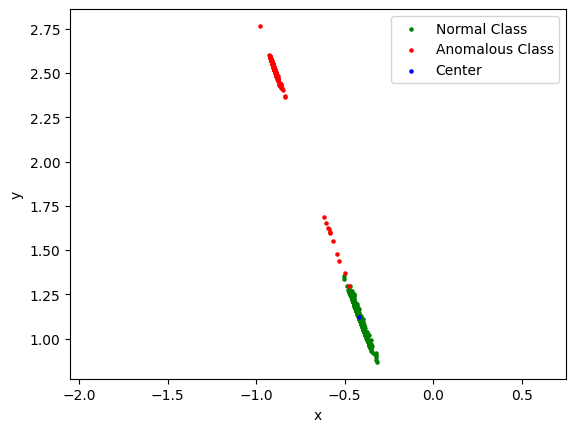

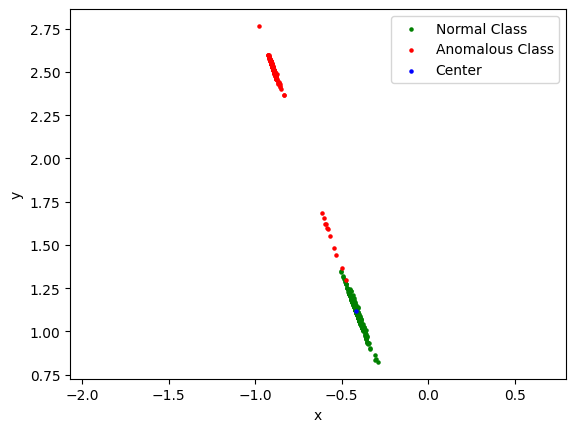

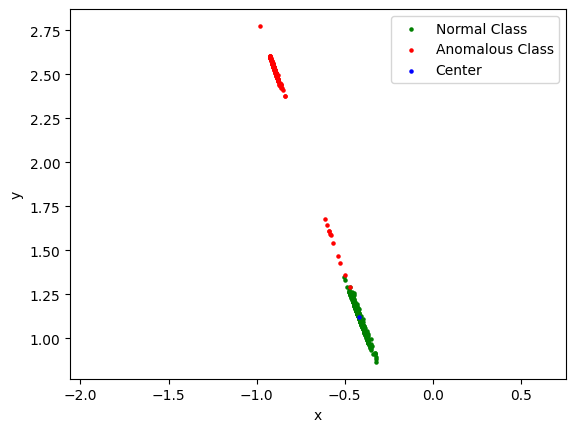

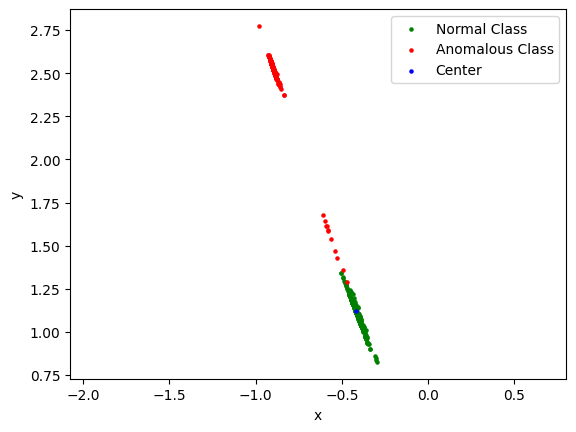

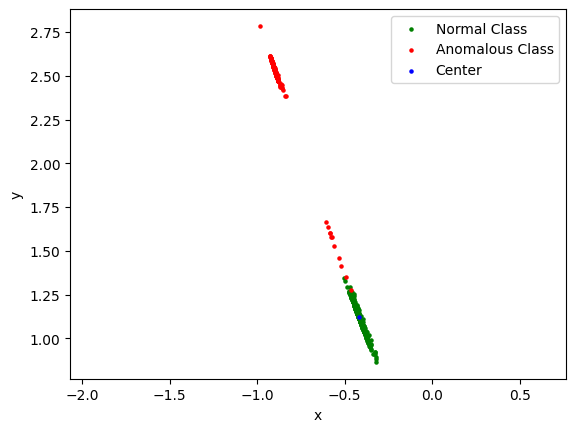

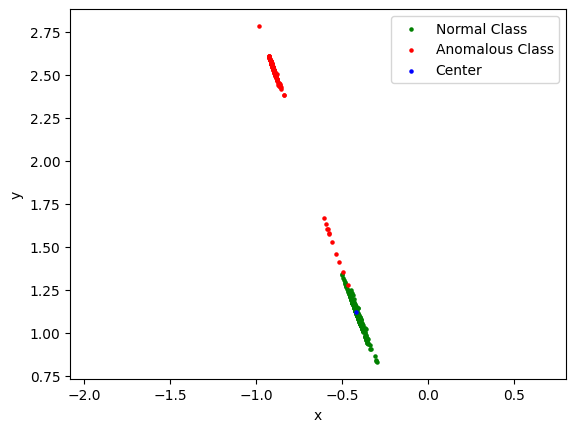

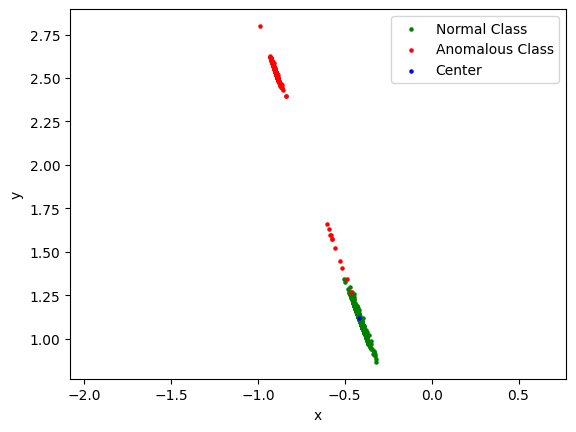

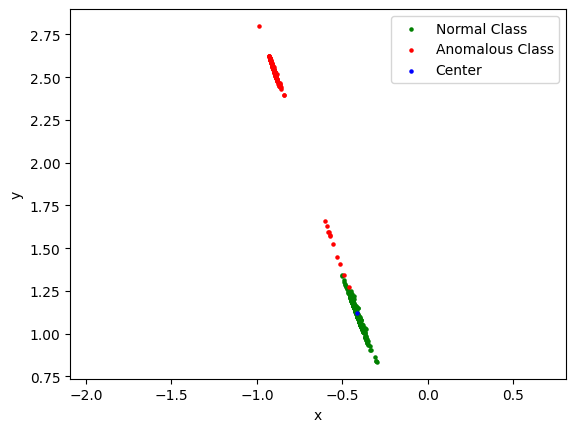

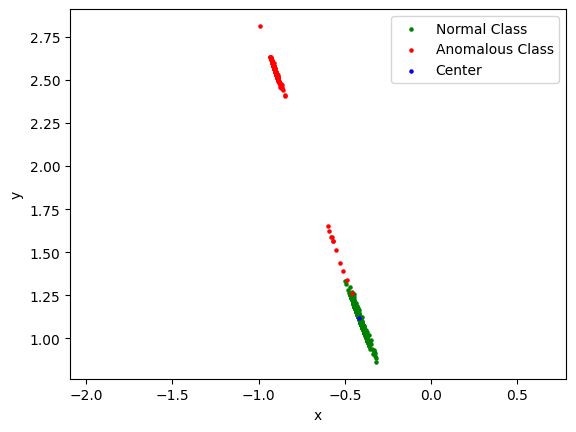

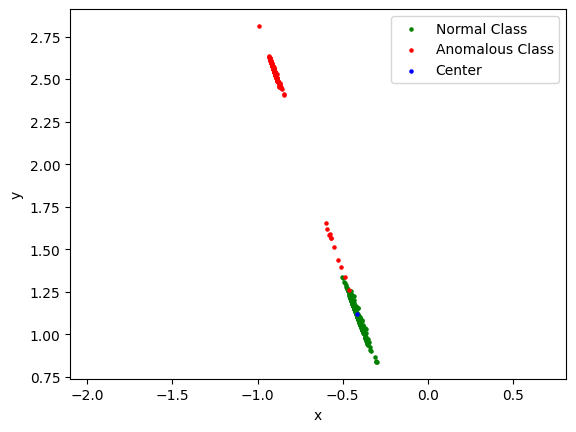

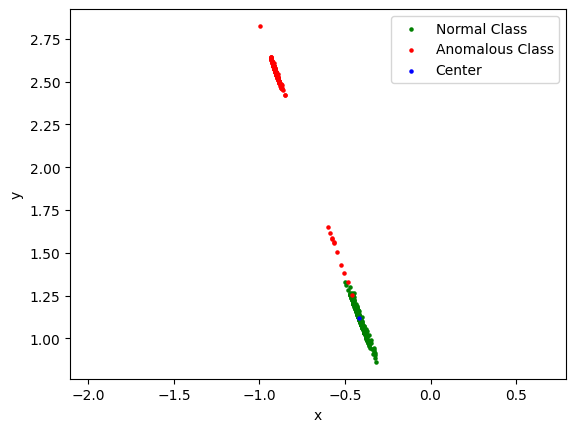

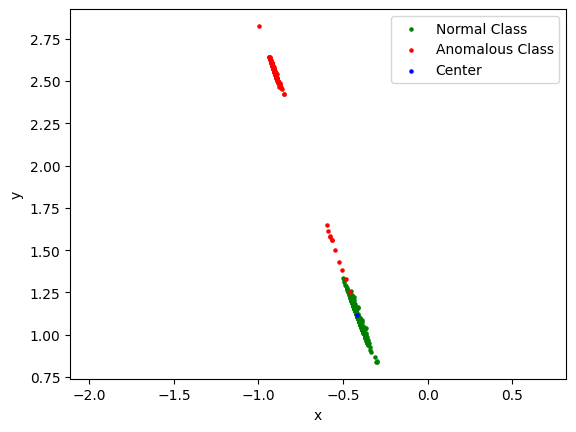

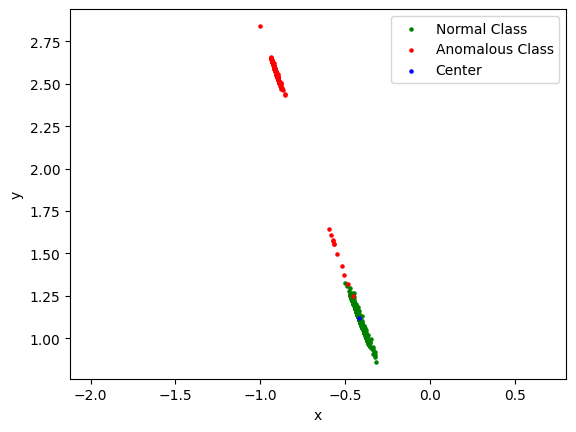

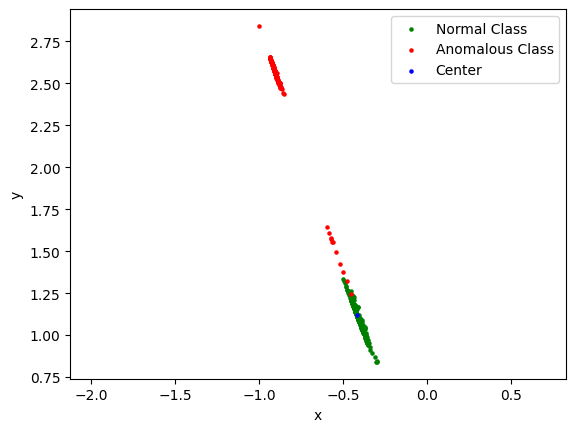

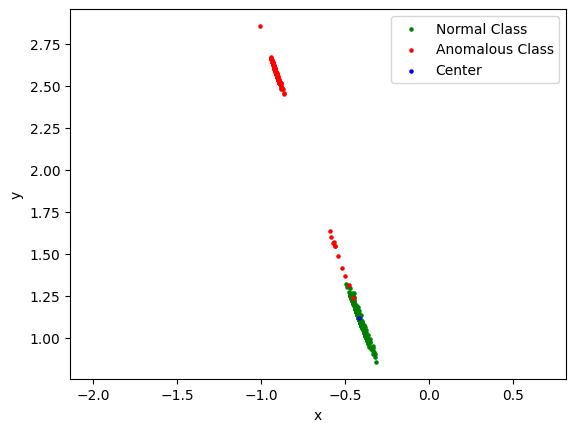

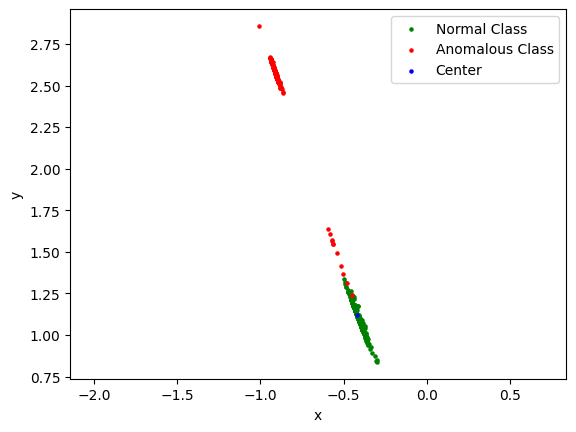

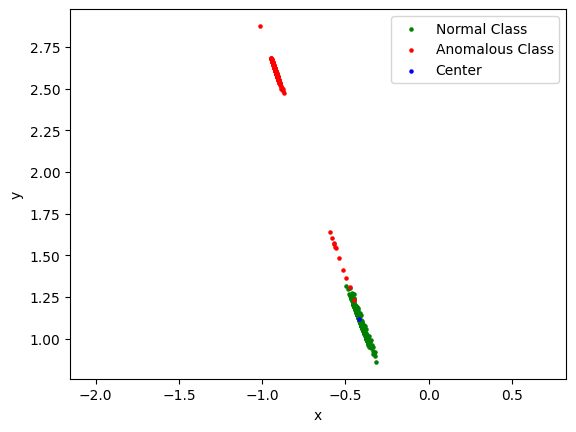

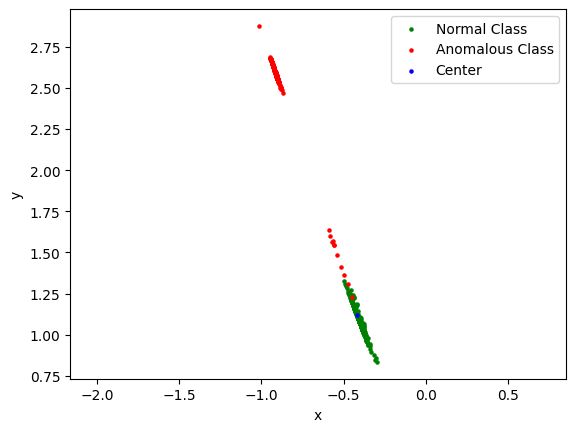

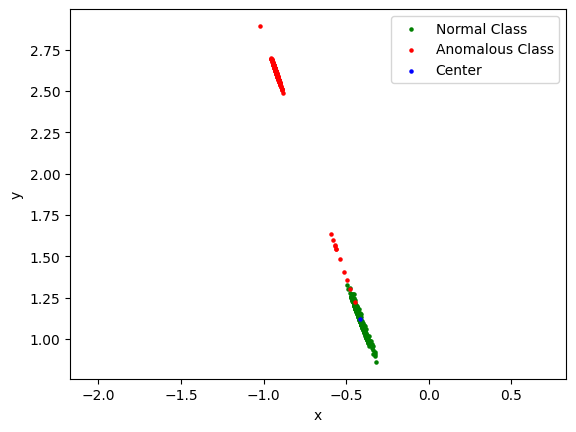

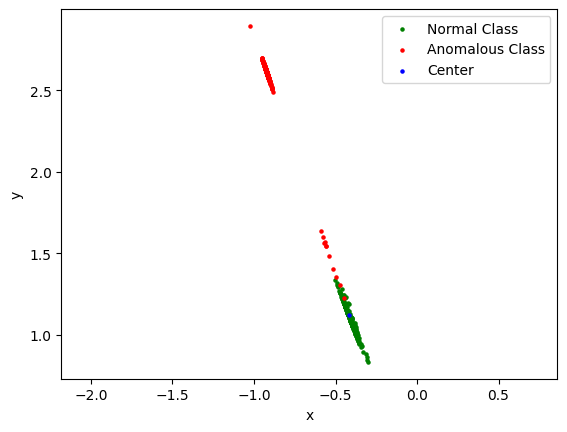

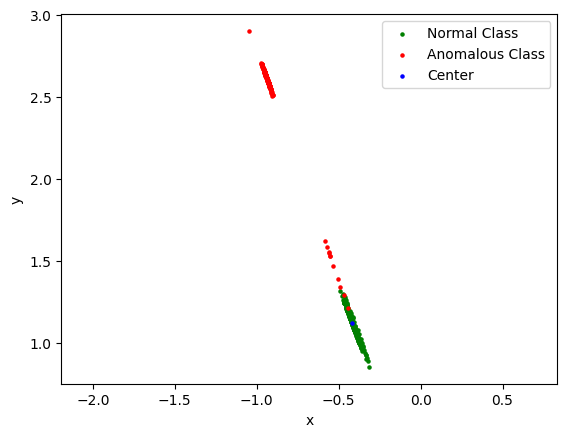

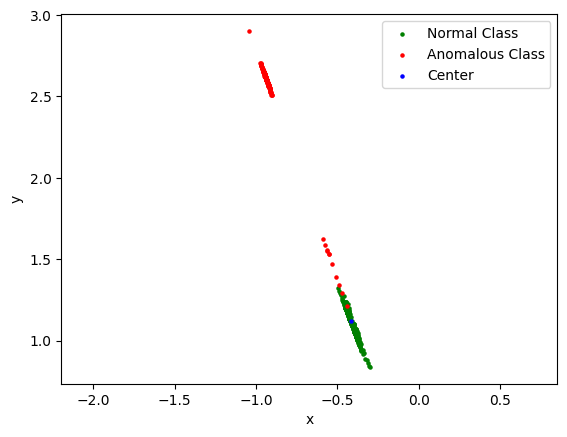

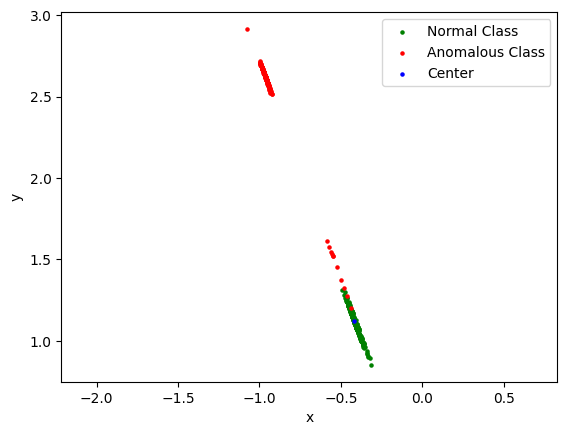

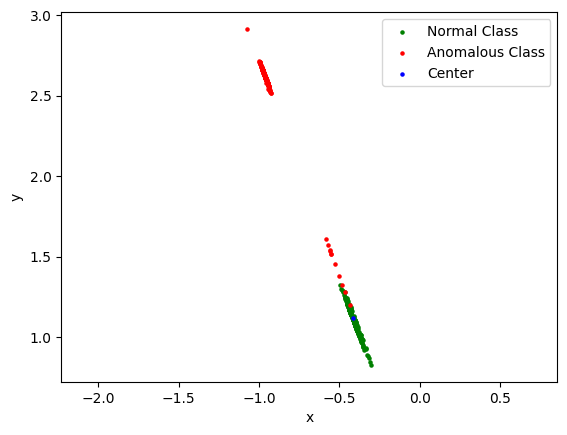

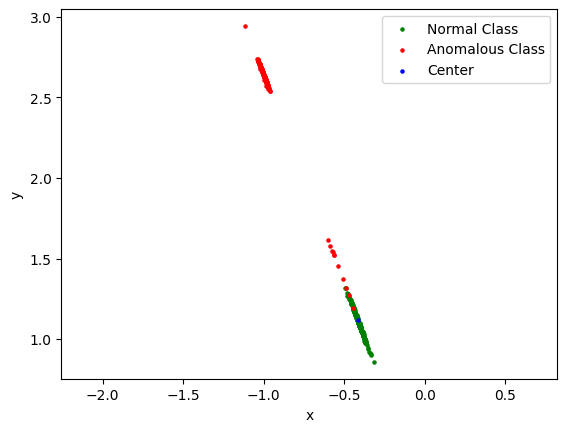

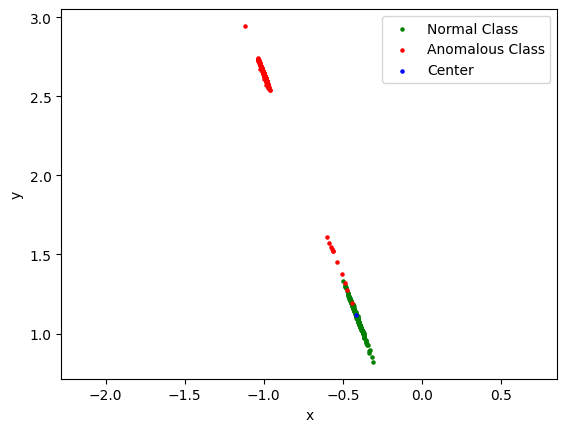

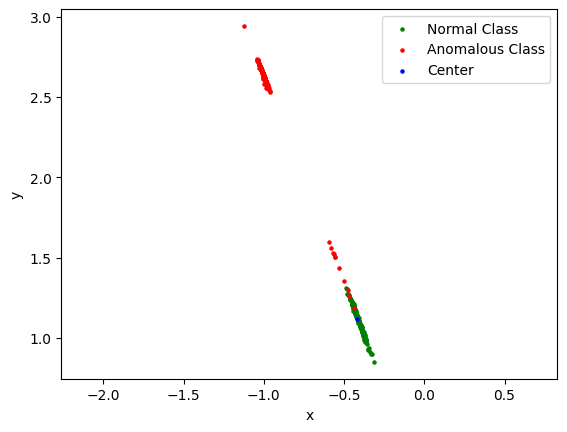

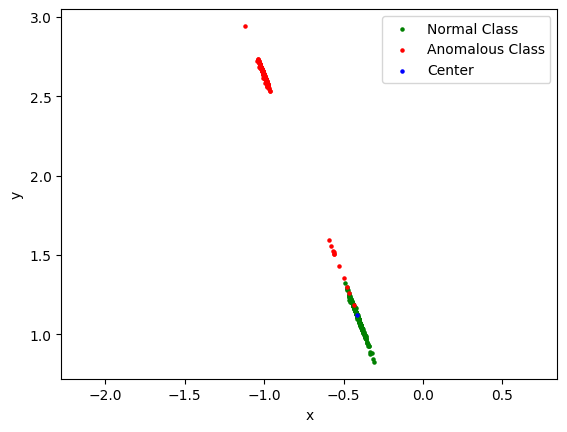

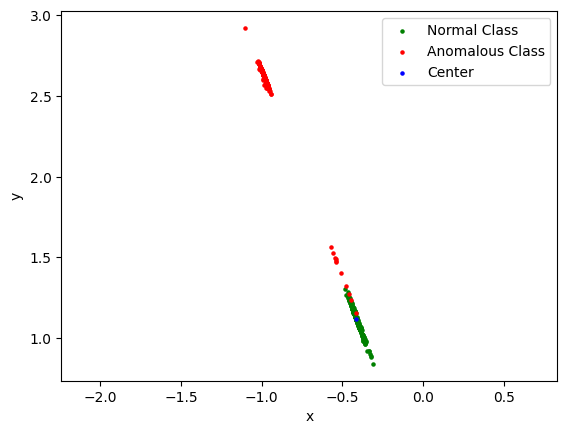

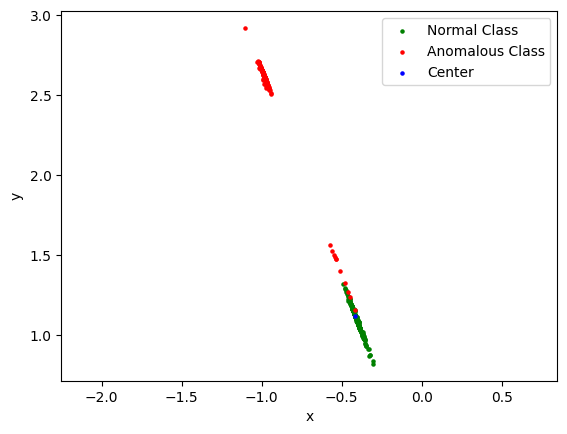

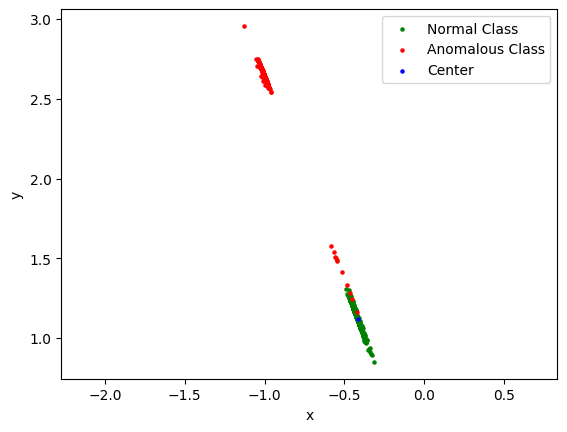

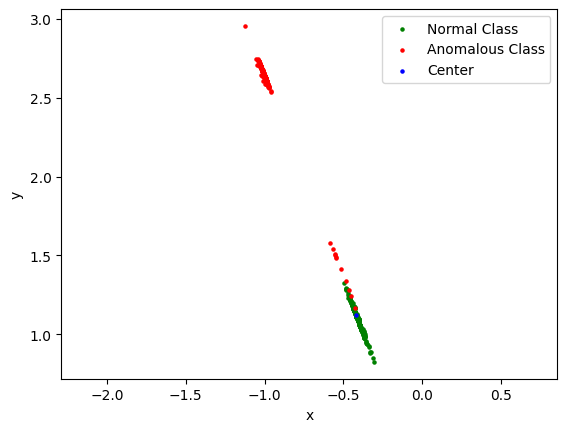

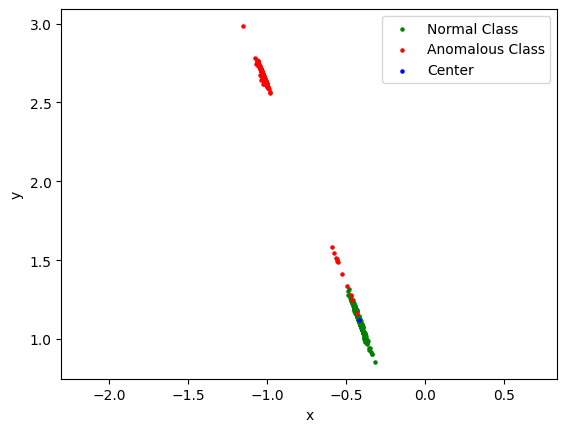

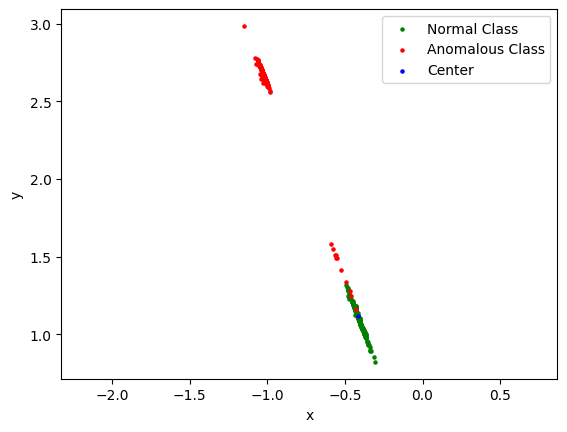

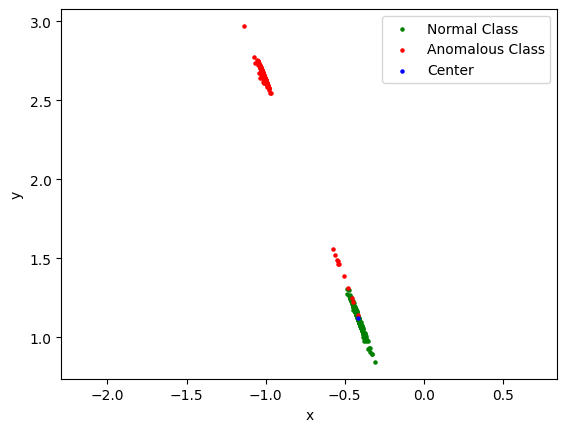

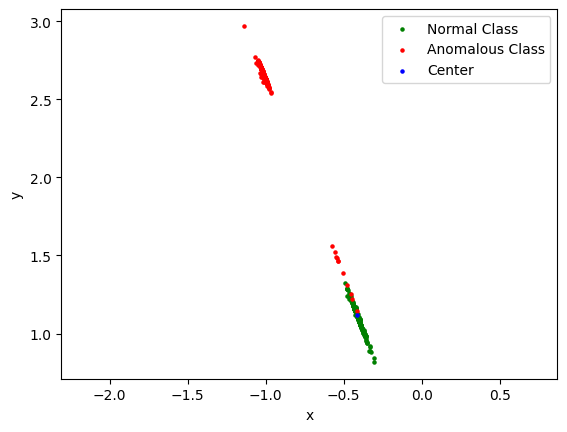

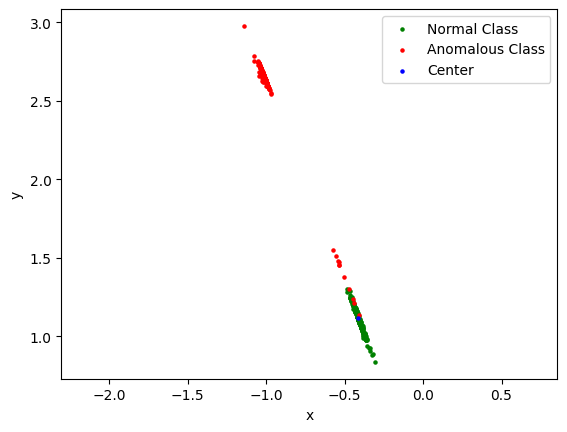

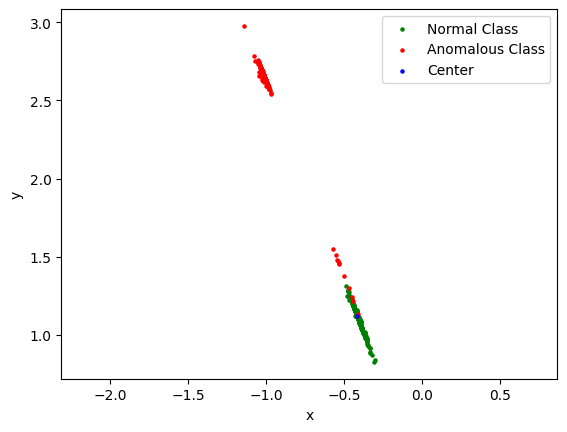

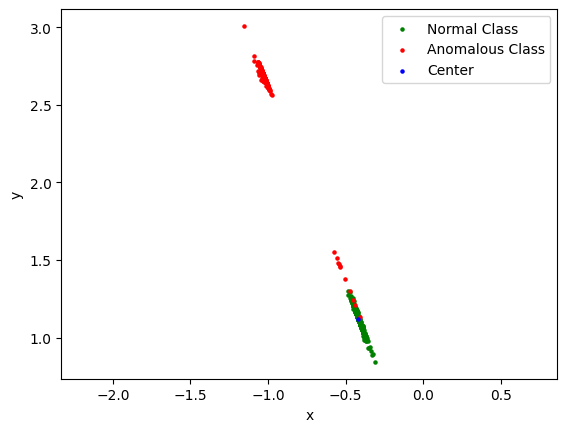

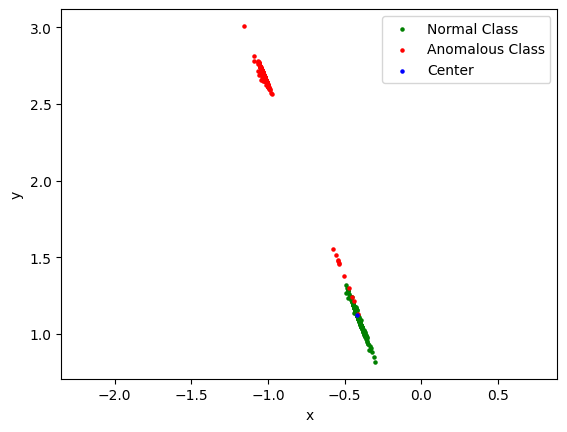

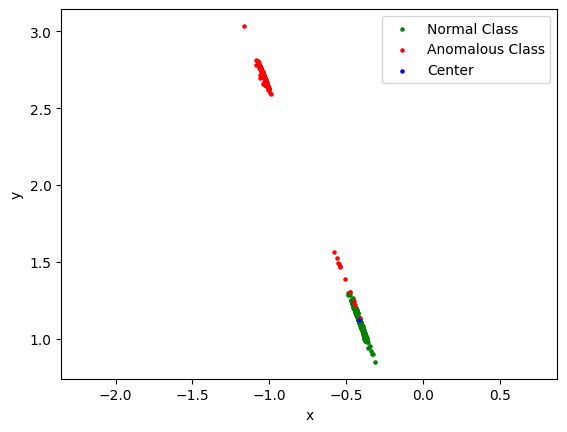

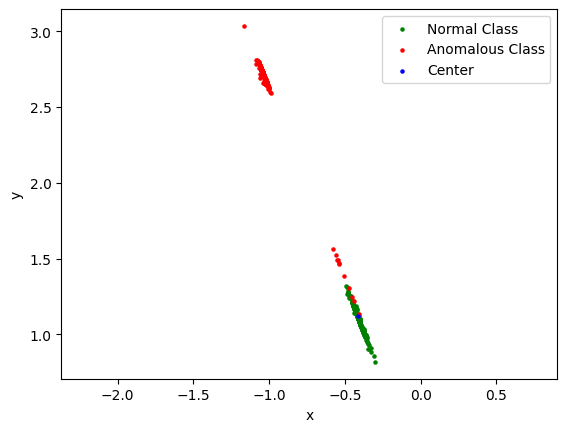

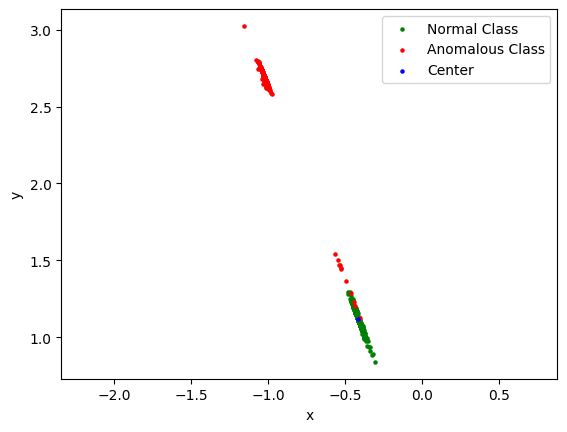

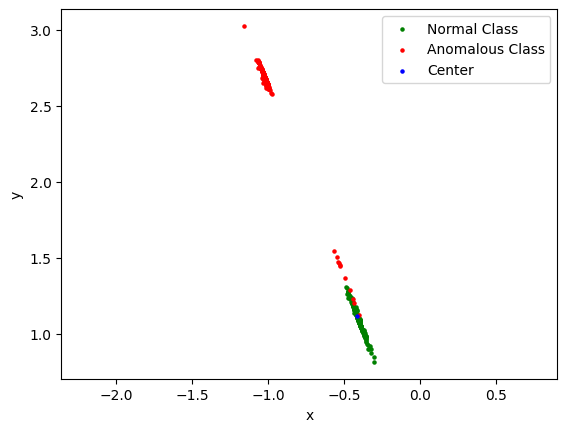

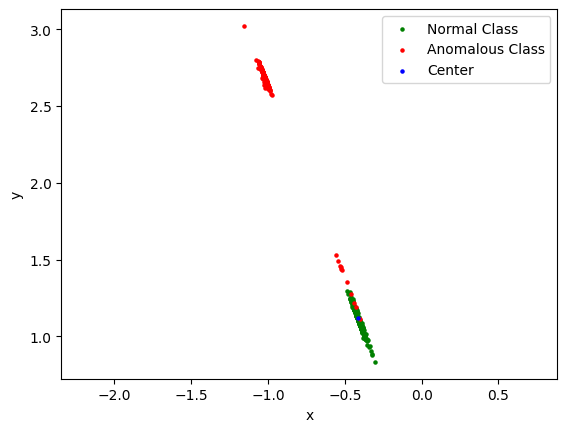

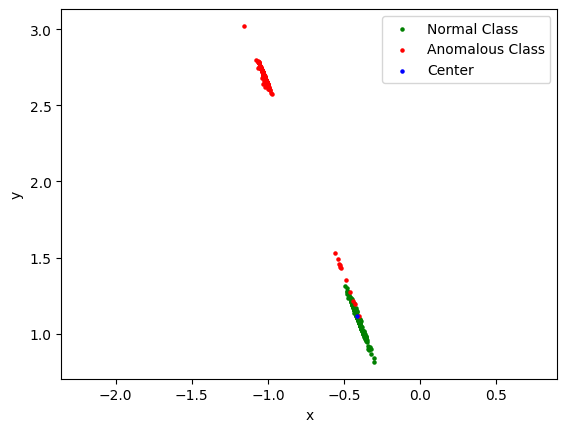

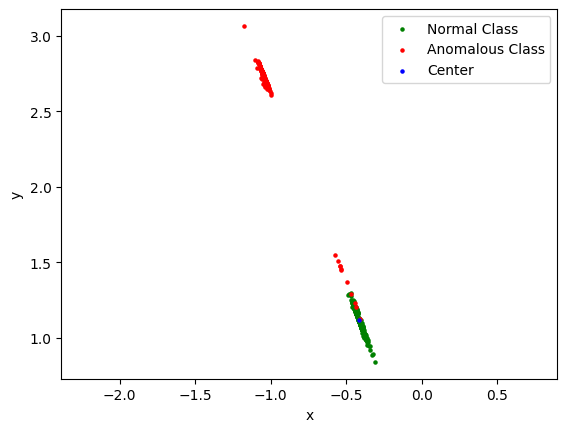

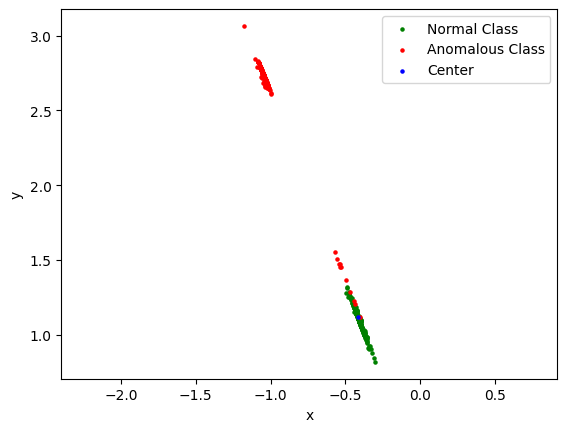

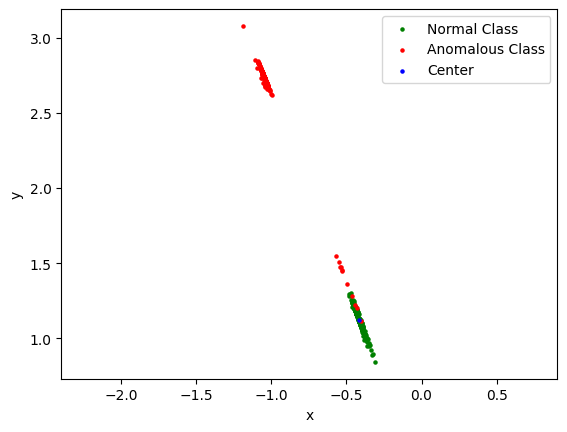

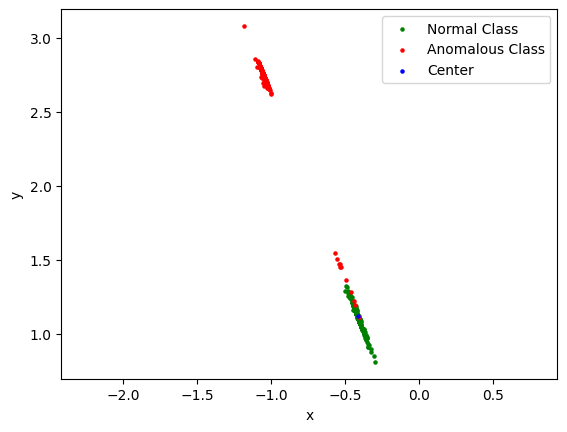

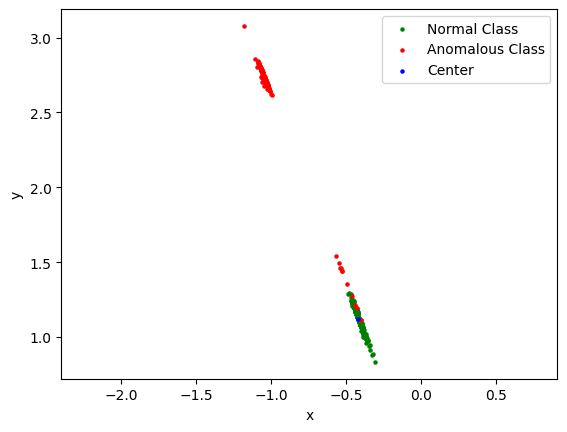

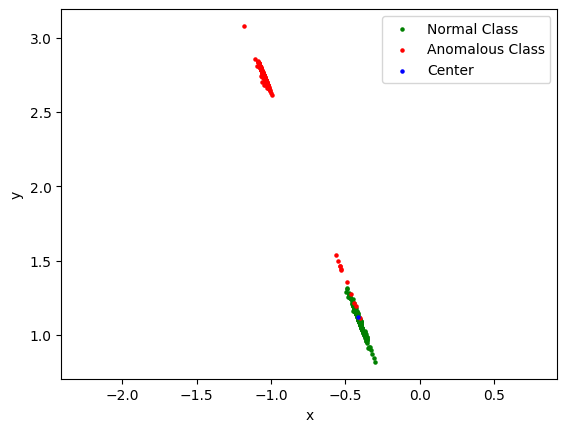

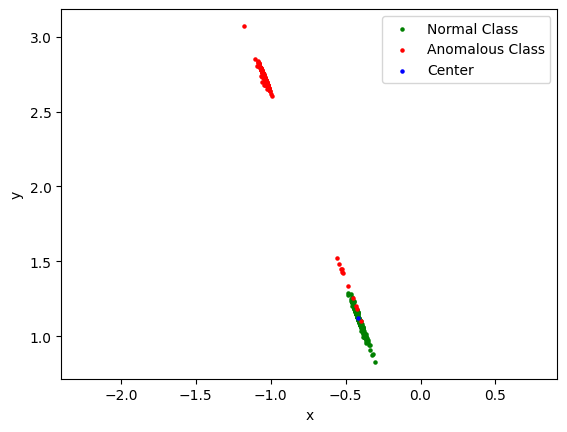

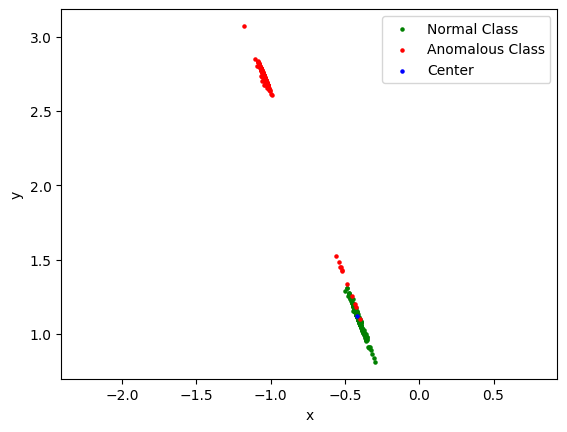

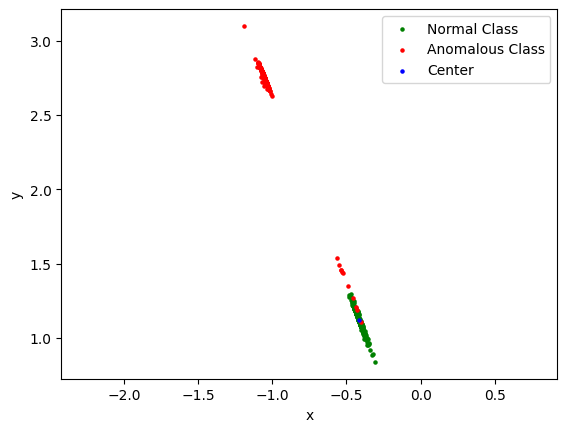

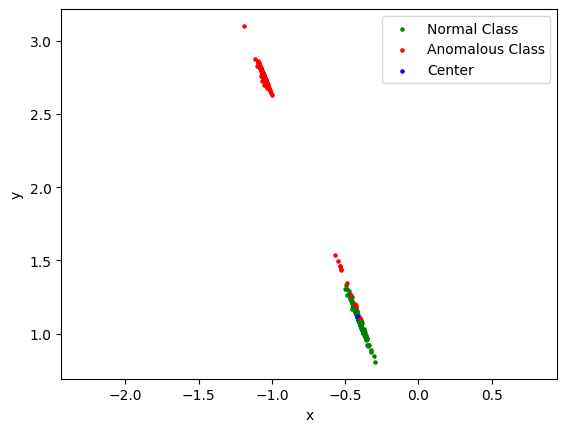

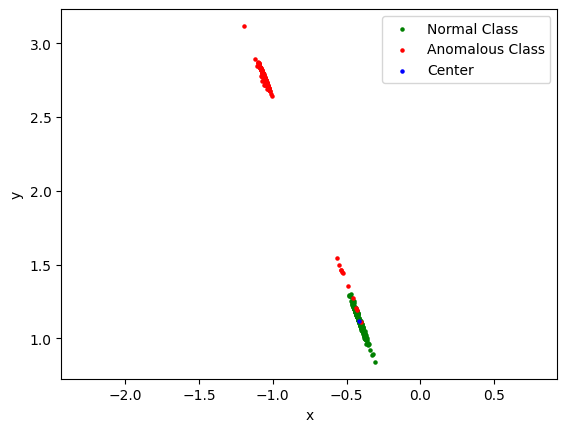

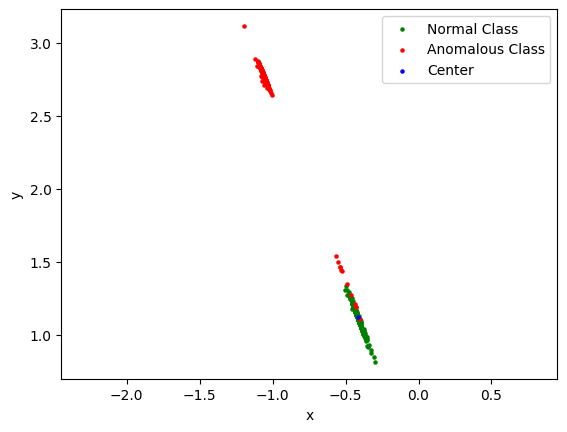

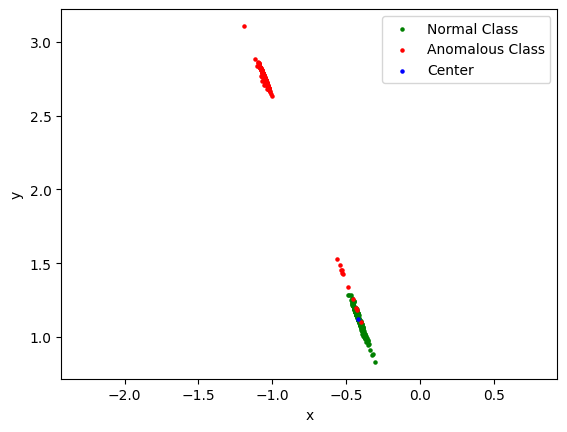

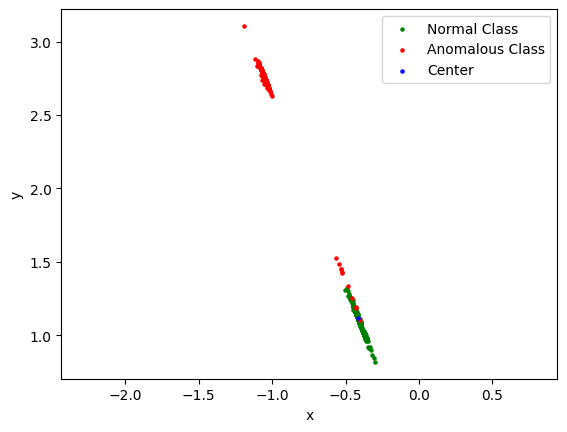

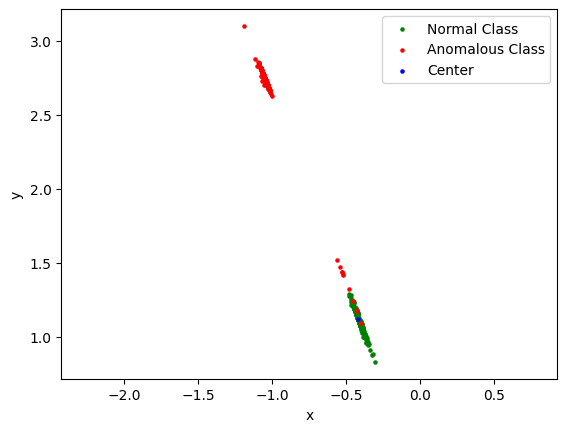

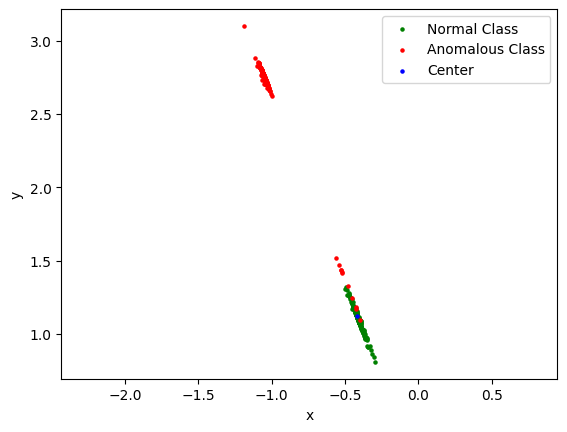

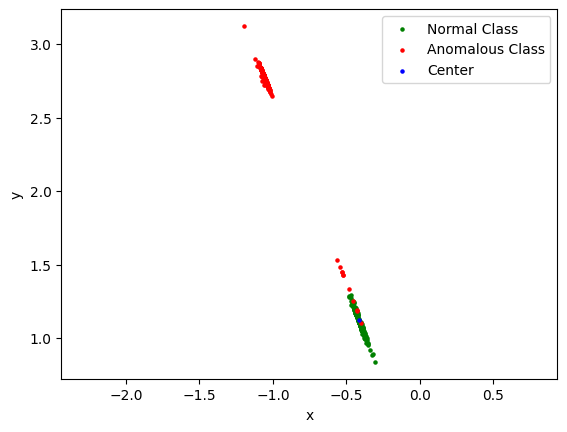

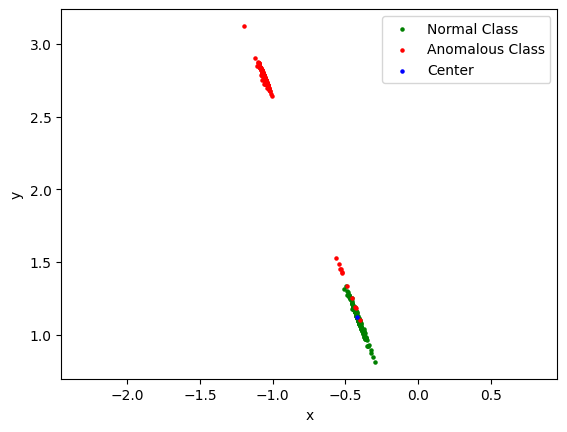

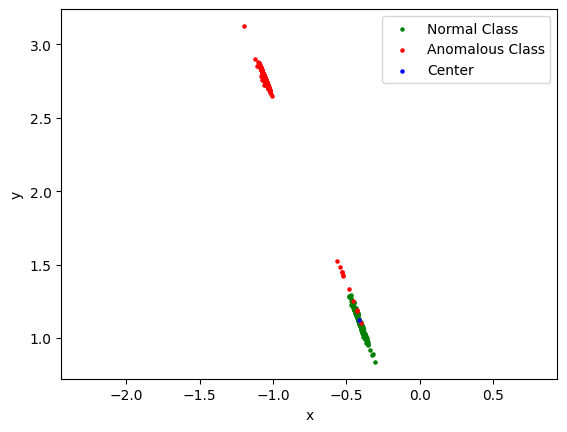

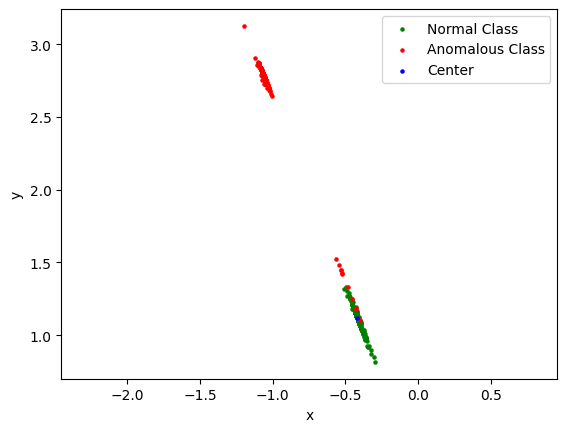

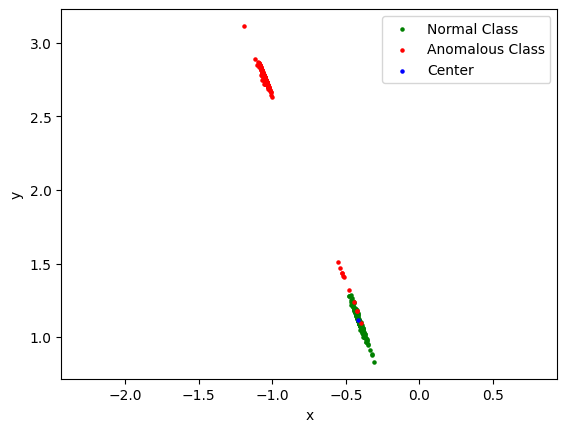

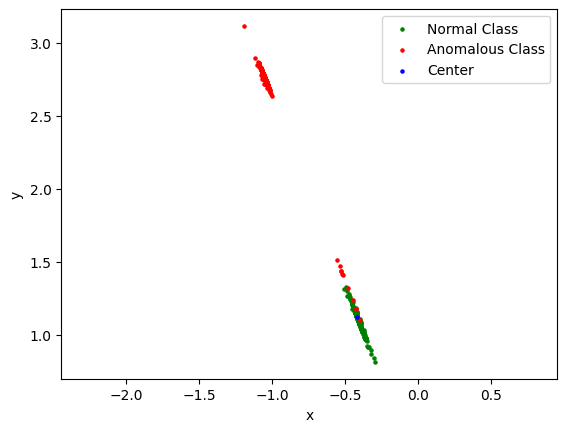

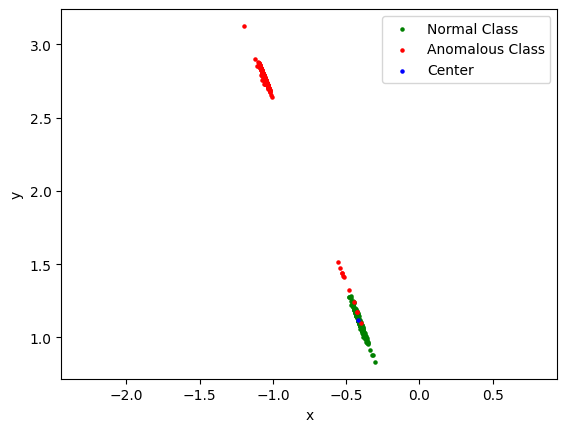

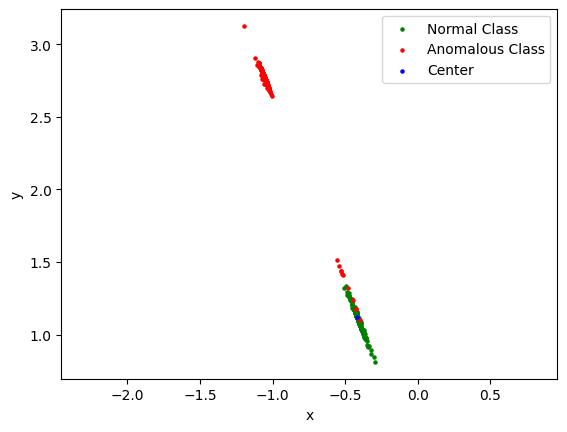

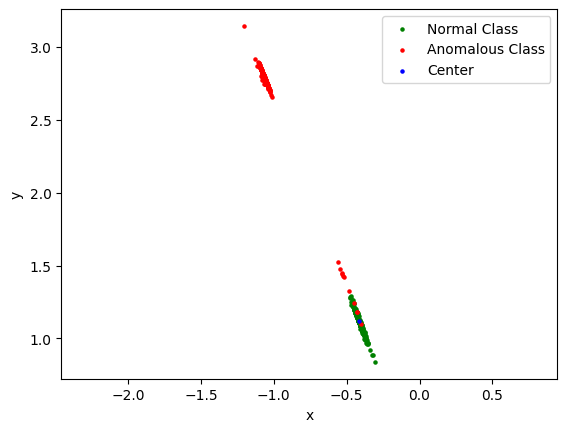

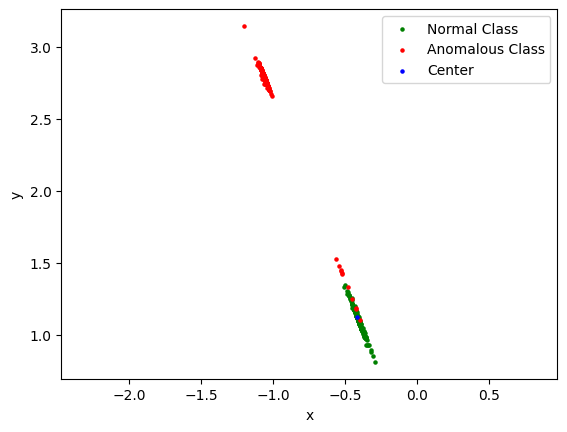

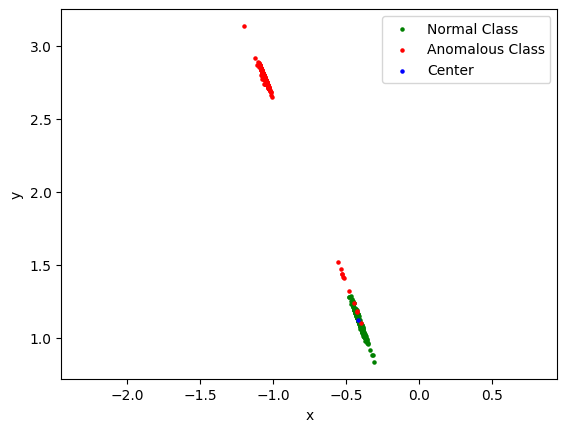

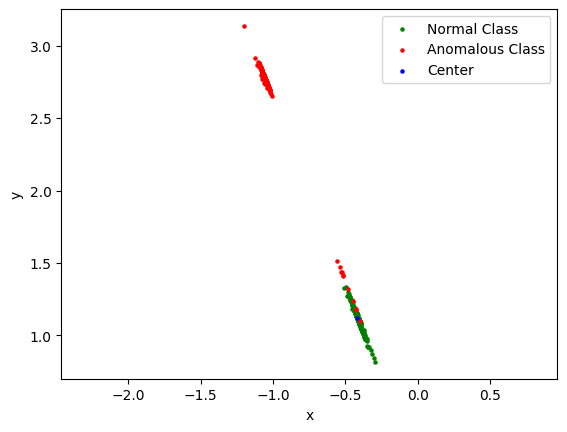

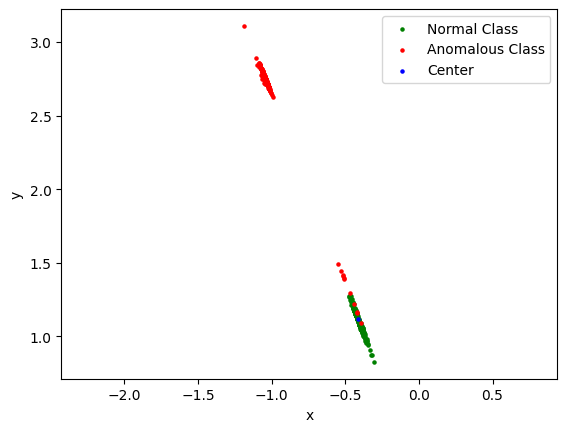

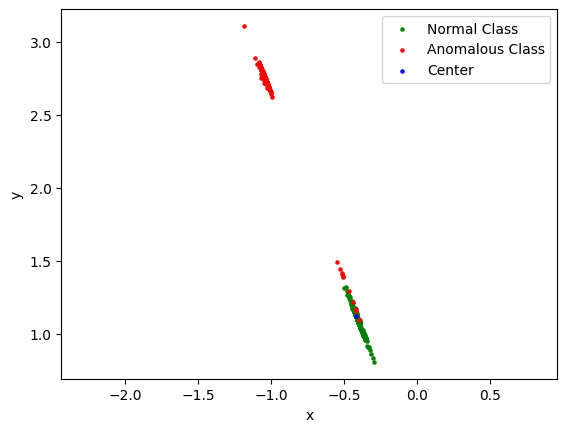

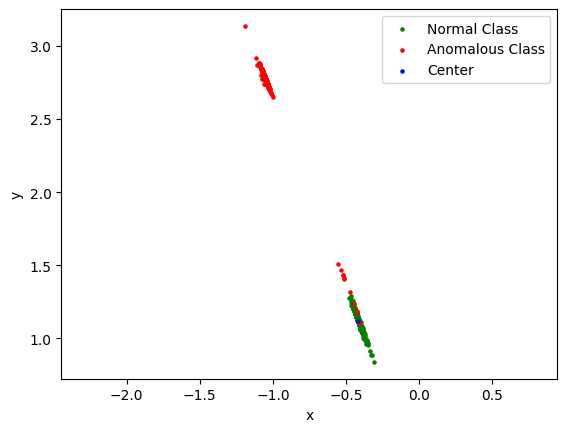

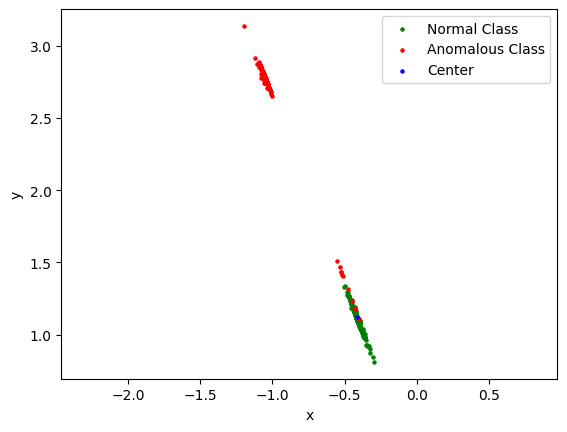

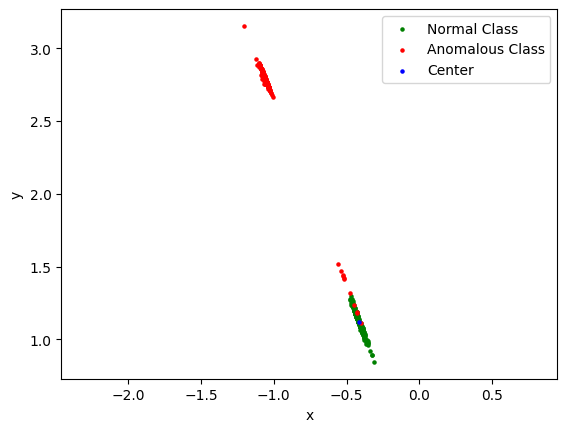

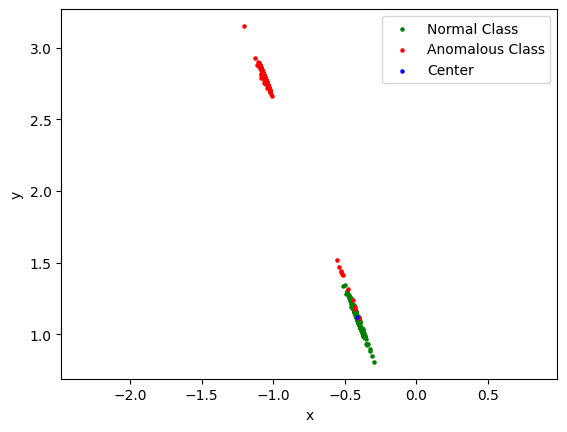

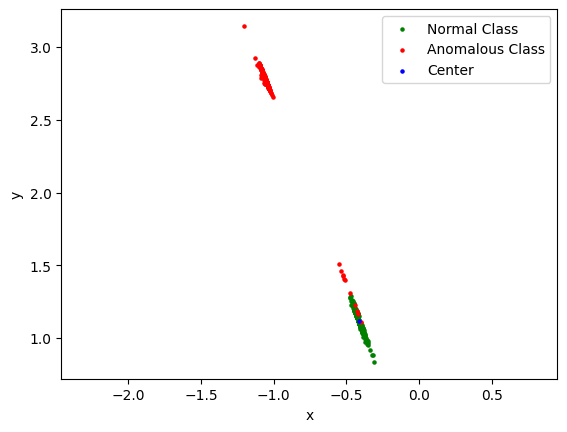

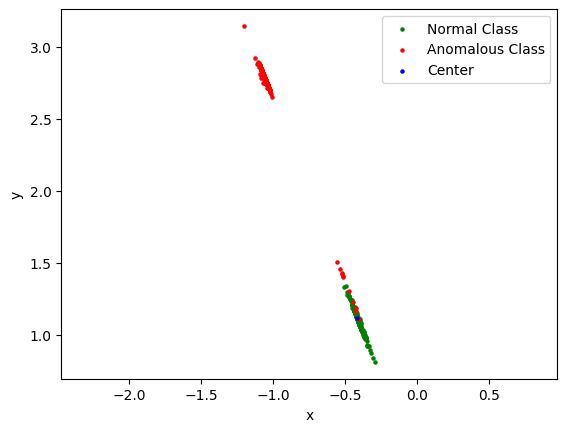

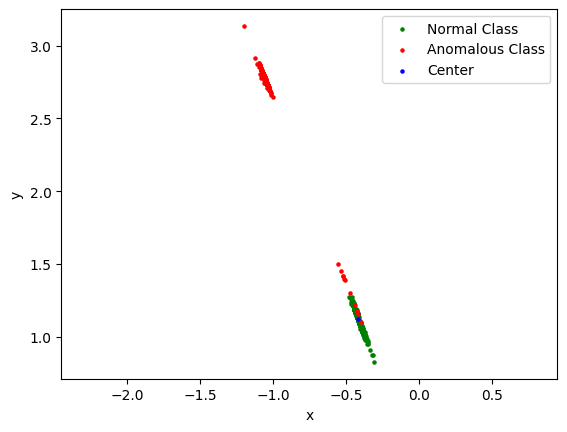

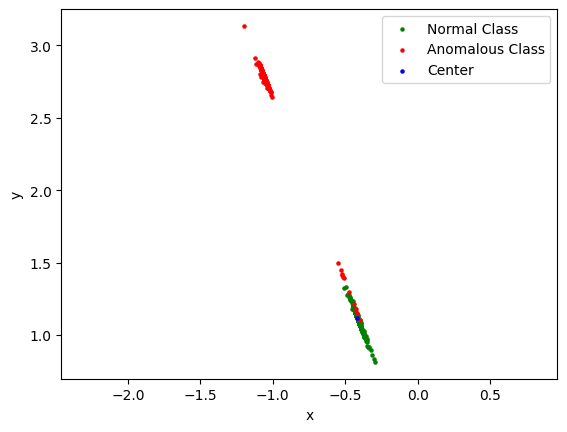

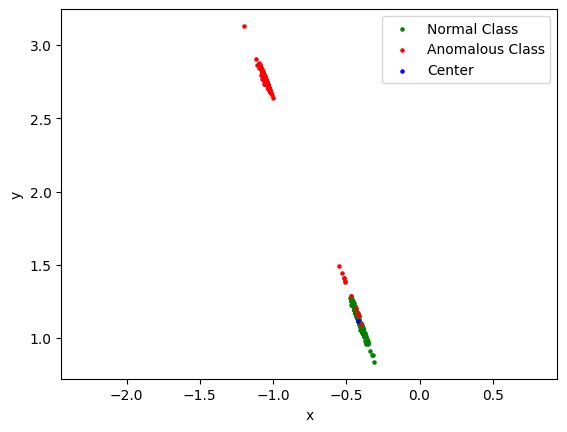

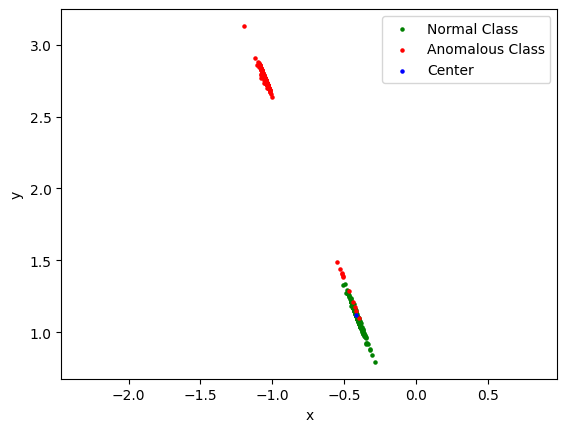

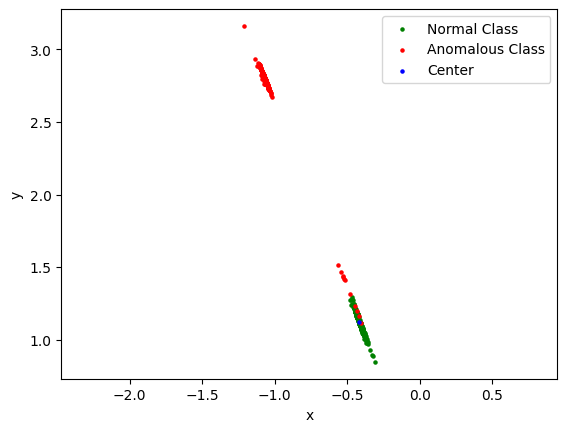

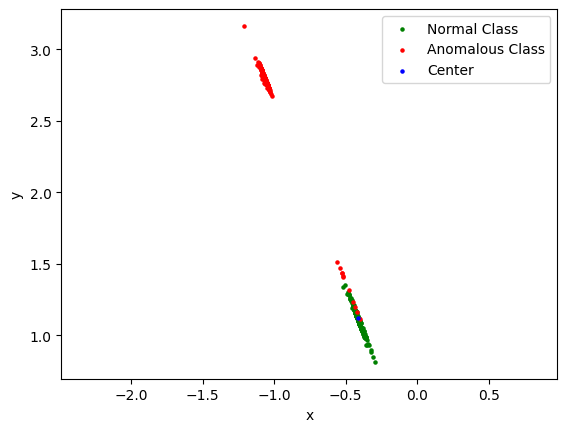

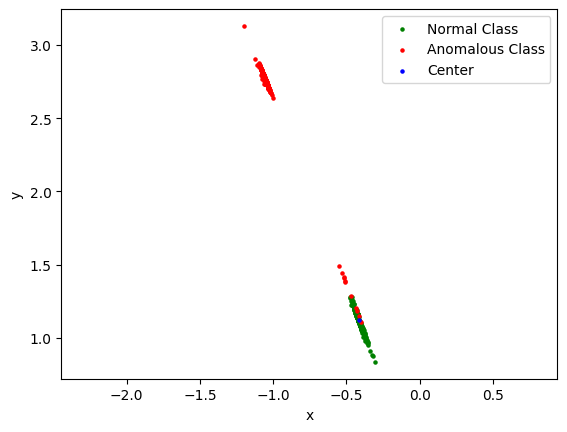

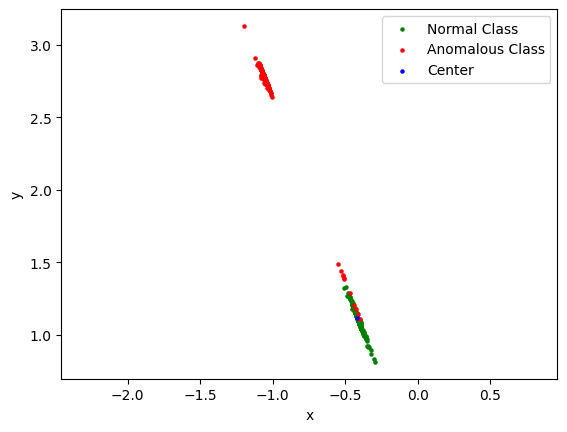

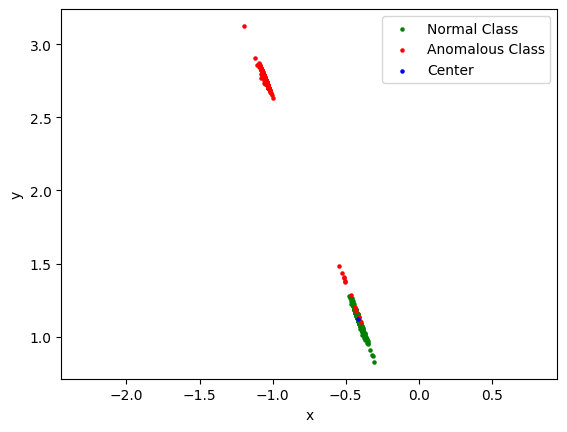

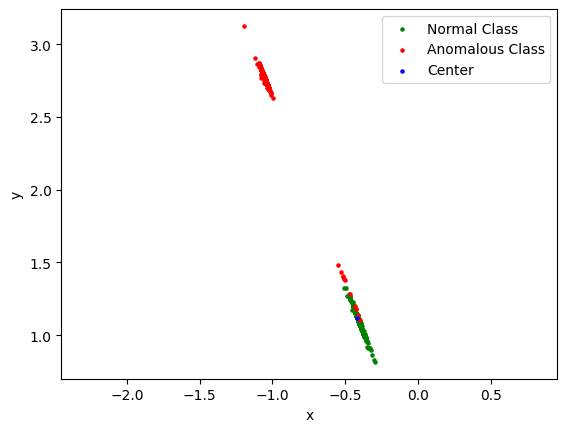

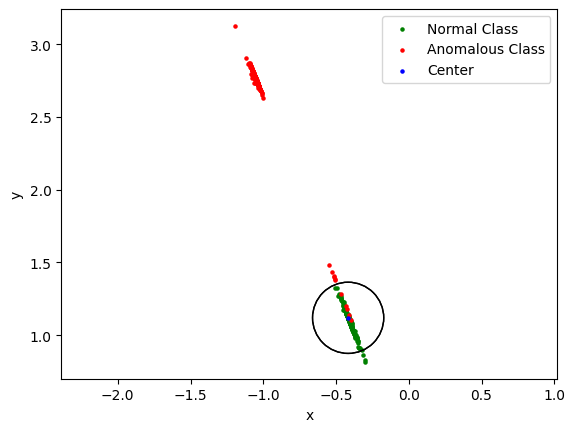

In [95]:
from numpy import sqrt, quantile


class DeepSVDD(nn.Module):
    def __init__(self, autoencoder, bias=False):
        """
        Inits a Deep SVDD model
        :param autoencoder: Pretrained autoencoder, weights of the encoder part will be copied to this model
        :param bias: Controls biases, should be False by default
        """
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 10, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(10, 5, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(5, 5, bias=bias),
            nn.LeakyReLU(),
            nn.Linear(5, 2, bias=bias),
        ).to(device)
        net_dict = self.state_dict()
        ae_dict = autoencoder.state_dict()
        ae_dict = {k: v for k, v in ae_dict.items() if k in net_dict}
        net_dict.update(ae_dict)
        self.load_state_dict(net_dict)

    def forward(self, x):
        return self.layers(x)


# Trainer can train models for either soft-boundary Deep SVDD or One-Class Deep SVDD
class DeepSVDDTrainer:
    """
    Deep SVDD Trainer for a Deep SVDD model. Trains either one-class or soft-boundary goals. 
    Keeps track of center as well as Radius during training 
    
    """
    def __init__(self, model, goal, c_size):
        self.model = model
        self.goal = goal
        self.c = torch.tensor([0, 0], dtype=torch.float32, device=device)
        self.R = torch.tensor(0, dtype=torch.float32, device=device)

    def train(self, training_data):
        optimizer = torch.optim.Adam(dsvdd.parameters(), lr=1e-2 / 2, weight_decay=1e-5)
        train_loader = torch.utils.data.DataLoader(list(zip(training_data, training_data)), batch_size=50)
        warmup_epoch = 5
        nu = 0.01

        losses = []

        for epoch in range(100):
            epoch_loss = []
            for data in train_loader:
                inputs, targets = data
                optimizer.zero_grad()
                outputs = dsvdd.forward(inputs)
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                if self.goal == 'one-class':
                    loss = torch.mean(dist)
                else:
                    scores = dist - self.R ** 2
                    loss = self.R ** 2 + (1 / nu) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())
                # For soft-boundary after an amount of warmup_epochs set the radius on minibatches for every training step
                if epoch >= warmup_epoch and self.goal == 'soft-boundary':
                    self.R = torch.tensor(quantile(sqrt(dist.clone().data.cpu().numpy()), 1 - nu), device=device)
                    
            losses.append(sum(epoch_loss) / len(epoch_loss))
            # Plot state after every epoch
            plot(self, tensors_circle)
            plot(self, tensor_validation_circle)
        return losses

    def set_center(self, transformed_data):
        # Sets the center as mean of the training data representation before training
        eps = 0.1
        with torch.no_grad():
            self.c = torch.zeros(2, device='cuda')
            for x in transformed_data:
                self.c += dsvdd.forward(x)

            self.c /= len(transformed_data)
            self.c[(abs(self.c) < eps) & (self.c < 0)] = -eps
            self.c[(abs(self.c) < eps) & (self.c > 0)] = eps

    # First copy weights from autoencoder to DeepSVDD network


#mixin outliers with transformed data


dsvdd = DeepSVDD(ae, False)
dsvdd_trainer = DeepSVDDTrainer(dsvdd, 'one-class', 2)
dsvdd_trainer.set_center(tensors_circle)

plot(dsvdd_trainer, tensor_validation_circle)
dsvdd_trainer.train(tensors_circle)
dists = dsvdd.forward(torch.stack(tensors_circle)) - dsvdd_trainer.c
dists = dists ** 2
dsvdd_trainer.R = torch.quantile(torch.sum(dists,dim=1).sqrt(), 0.99)
plot(dsvdd_trainer, tensor_validation_circle)


In [96]:
def in_sphere(c, r, vec):
    """
    Checks if a point is inside the hpyer sphere
    :param c: Center of the hyper sphere
    :param r: Radius of the hyper sphere
    :param vec: Point to check
    :return: True if inside sphere else False
    """
    return np.sum((c.cpu().detach().numpy() - vec.cpu().detach().numpy()) ** 2) < r ** 2


points = dsvdd_trainer.model.forward(torch.stack(tensors_torus))

is_in_sphere = 0
not_in_sphere = 0

for p in points:
    if in_sphere(dsvdd_trainer.c, dsvdd_trainer.R, p):
        is_in_sphere += 1
    else:
        not_in_sphere += 1


tp = not_in_sphere
fn = is_in_sphere
print(is_in_sphere)
print(not_in_sphere)

5
245


In [97]:
points = dsvdd_trainer.model.forward(torch.stack(tensor_validation_circle))

is_in_sphere = 0
not_in_sphere = 0

for p in points:
    if in_sphere(dsvdd_trainer.c, dsvdd_trainer.R, p):
        is_in_sphere += 1
    else:
        not_in_sphere += 1

tn = is_in_sphere
fp = not_in_sphere
print(is_in_sphere)
print(not_in_sphere)

print("f1", (2 * tp) / (2 * tp + fp + fn))
print("mcc",((tp * tn) - (fp * fn)) / np.sqrt(
    (tp + fp) * (tp + fn) * (tn + fp) * (
            tn + fp)) )

247
3
f1 0.9839357429718876
mcc 0.9718953879720237
